In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 1012)
(4629816, 8)
validation
(621056, 1012)
(621056, 8)
test
(624904, 1012)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1012)]            0         


 dense (Dense)               (None, 1024)              1037312   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1727368 (6.59 MB)


Trainable params: 1727368 (6.59 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:23 - loss: 2.1598 - STD: 0.0692 - MAE: 0.2151

  3/463 [..............................] - ETA: 11s - loss: 2.0942 - STD: 0.0420 - MAE: 0.2165  

  5/463 [..............................] - ETA: 11s - loss: 2.0887 - STD: 0.0401 - MAE: 0.2168

  7/463 [..............................] - ETA: 11s - loss: 2.0846 - STD: 0.0401 - MAE: 0.2168

  9/463 [..............................] - ETA: 11s - loss: 2.0784 - STD: 0.0383 - MAE: 0.2168

 11/463 [..............................] - ETA: 11s - loss: 2.0728 - STD: 0.0366 - MAE: 0.2168

 13/463 [..............................] - ETA: 11s - loss: 2.0700 - STD: 0.0366 - MAE: 0.2167

 15/463 [..............................] - ETA: 11s - loss: 2.0677 - STD: 0.0371 - MAE: 0.2167

 17/463 [>.............................] - ETA: 11s - loss: 2.0641 - STD: 0.0370 - MAE: 0.2166

 19/463 [>.............................] - ETA: 11s - loss: 2.0607 - STD: 0.0364 - MAE: 0.2165

 21/463 [>.............................] - ETA: 11s - loss: 2.0574 - STD: 0.0358 - MAE: 0.2165

 23/463 [>.............................] - ETA: 11s - loss: 2.0534 - STD: 0.0356 - MAE: 0.2163

 25/463 [>.............................] - ETA: 31s - loss: 2.0483 - STD: 0.0358 - MAE: 0.2162

 27/463 [>.............................] - ETA: 29s - loss: 2.0420 - STD: 0.0365 - MAE: 0.2159

 29/463 [>.............................] - ETA: 28s - loss: 2.0349 - STD: 0.0375 - MAE: 0.2156

 31/463 [=>............................] - ETA: 27s - loss: 2.0268 - STD: 0.0389 - MAE: 0.2152

 33/463 [=>............................] - ETA: 26s - loss: 2.0185 - STD: 0.0405 - MAE: 0.2148

 35/463 [=>............................] - ETA: 25s - loss: 2.0096 - STD: 0.0423 - MAE: 0.2144

 37/463 [=>............................] - ETA: 24s - loss: 2.0005 - STD: 0.0441 - MAE: 0.2139

 39/463 [=>............................] - ETA: 23s - loss: 1.9919 - STD: 0.0459 - MAE: 0.2134

 41/463 [=>............................] - ETA: 22s - loss: 1.9832 - STD: 0.0475 - MAE: 0.2130

 43/463 [=>............................] - ETA: 22s - loss: 1.9746 - STD: 0.0490 - MAE: 0.2126

 45/463 [=>............................] - ETA: 21s - loss: 1.9659 - STD: 0.0504 - MAE: 0.2121

 47/463 [==>...........................] - ETA: 20s - loss: 1.9568 - STD: 0.0518 - MAE: 0.2117

 49/463 [==>...........................] - ETA: 20s - loss: 1.9477 - STD: 0.0532 - MAE: 0.2112

 51/463 [==>...........................] - ETA: 19s - loss: 1.9379 - STD: 0.0546 - MAE: 0.2108

 53/463 [==>...........................] - ETA: 19s - loss: 1.9276 - STD: 0.0559 - MAE: 0.2102

 55/463 [==>...........................] - ETA: 18s - loss: 1.9164 - STD: 0.0574 - MAE: 0.2097

 57/463 [==>...........................] - ETA: 18s - loss: 1.9051 - STD: 0.0589 - MAE: 0.2091

 59/463 [==>...........................] - ETA: 18s - loss: 1.8934 - STD: 0.0606 - MAE: 0.2084

 61/463 [==>...........................] - ETA: 17s - loss: 1.8818 - STD: 0.0623 - MAE: 0.2078

 63/463 [===>..........................] - ETA: 17s - loss: 1.8701 - STD: 0.0640 - MAE: 0.2071

 65/463 [===>..........................] - ETA: 17s - loss: 1.8589 - STD: 0.0658 - MAE: 0.2064

 67/463 [===>..........................] - ETA: 16s - loss: 1.8470 - STD: 0.0676 - MAE: 0.2057

 69/463 [===>..........................] - ETA: 16s - loss: 1.8357 - STD: 0.0694 - MAE: 0.2049

 71/463 [===>..........................] - ETA: 16s - loss: 1.8247 - STD: 0.0712 - MAE: 0.2042

 73/463 [===>..........................] - ETA: 16s - loss: 1.8139 - STD: 0.0729 - MAE: 0.2035

 75/463 [===>..........................] - ETA: 15s - loss: 1.8031 - STD: 0.0746 - MAE: 0.2028

 77/463 [===>..........................] - ETA: 15s - loss: 1.7925 - STD: 0.0763 - MAE: 0.2021

 79/463 [====>.........................] - ETA: 15s - loss: 1.7828 - STD: 0.0780 - MAE: 0.2014

 81/463 [====>.........................] - ETA: 15s - loss: 1.7731 - STD: 0.0796 - MAE: 0.2007

 83/463 [====>.........................] - ETA: 15s - loss: 1.7633 - STD: 0.0812 - MAE: 0.2000

 85/463 [====>.........................] - ETA: 14s - loss: 1.7537 - STD: 0.0828 - MAE: 0.1994

 87/463 [====>.........................] - ETA: 14s - loss: 1.7445 - STD: 0.0843 - MAE: 0.1987

 89/463 [====>.........................] - ETA: 14s - loss: 1.7353 - STD: 0.0858 - MAE: 0.1980

 91/463 [====>.........................] - ETA: 14s - loss: 1.7265 - STD: 0.0873 - MAE: 0.1974

 93/463 [=====>........................] - ETA: 14s - loss: 1.7180 - STD: 0.0887 - MAE: 0.1968

 95/463 [=====>........................] - ETA: 13s - loss: 1.7096 - STD: 0.0901 - MAE: 0.1961

 97/463 [=====>........................] - ETA: 13s - loss: 1.7015 - STD: 0.0915 - MAE: 0.1955

 99/463 [=====>........................] - ETA: 13s - loss: 1.6936 - STD: 0.0929 - MAE: 0.1949

101/463 [=====>........................] - ETA: 13s - loss: 1.6858 - STD: 0.0942 - MAE: 0.1944

103/463 [=====>........................] - ETA: 13s - loss: 1.6783 - STD: 0.0955 - MAE: 0.1938

105/463 [=====>........................] - ETA: 13s - loss: 1.6710 - STD: 0.0967 - MAE: 0.1932

107/463 [=====>........................] - ETA: 12s - loss: 1.6638 - STD: 0.0979 - MAE: 0.1927

109/463 [======>.......................] - ETA: 12s - loss: 1.6569 - STD: 0.0991 - MAE: 0.1921

111/463 [======>.......................] - ETA: 12s - loss: 1.6501 - STD: 0.1002 - MAE: 0.1916

113/463 [======>.......................] - ETA: 12s - loss: 1.6434 - STD: 0.1014 - MAE: 0.1911

115/463 [======>.......................] - ETA: 12s - loss: 1.6370 - STD: 0.1024 - MAE: 0.1906

117/463 [======>.......................] - ETA: 12s - loss: 1.6306 - STD: 0.1035 - MAE: 0.1901

119/463 [======>.......................] - ETA: 12s - loss: 1.6244 - STD: 0.1045 - MAE: 0.1896

121/463 [======>.......................] - ETA: 12s - loss: 1.6185 - STD: 0.1056 - MAE: 0.1892

123/463 [======>.......................] - ETA: 11s - loss: 1.6126 - STD: 0.1065 - MAE: 0.1887

125/463 [=======>......................] - ETA: 11s - loss: 1.6066 - STD: 0.1075 - MAE: 0.1882

127/463 [=======>......................] - ETA: 11s - loss: 1.6011 - STD: 0.1084 - MAE: 0.1878

129/463 [=======>......................] - ETA: 11s - loss: 1.5958 - STD: 0.1093 - MAE: 0.1874

131/463 [=======>......................] - ETA: 11s - loss: 1.5904 - STD: 0.1102 - MAE: 0.1870

133/463 [=======>......................] - ETA: 11s - loss: 1.5851 - STD: 0.1111 - MAE: 0.1866

135/463 [=======>......................] - ETA: 11s - loss: 1.5800 - STD: 0.1119 - MAE: 0.1861

137/463 [=======>......................] - ETA: 11s - loss: 1.5748 - STD: 0.1128 - MAE: 0.1857

139/463 [========>.....................] - ETA: 10s - loss: 1.5697 - STD: 0.1136 - MAE: 0.1853

141/463 [========>.....................] - ETA: 10s - loss: 1.5650 - STD: 0.1144 - MAE: 0.1849

143/463 [========>.....................] - ETA: 10s - loss: 1.5601 - STD: 0.1152 - MAE: 0.1846

145/463 [========>.....................] - ETA: 10s - loss: 1.5555 - STD: 0.1159 - MAE: 0.1842

147/463 [========>.....................] - ETA: 10s - loss: 1.5510 - STD: 0.1167 - MAE: 0.1838

149/463 [========>.....................] - ETA: 10s - loss: 1.5464 - STD: 0.1174 - MAE: 0.1834

151/463 [========>.....................] - ETA: 10s - loss: 1.5417 - STD: 0.1182 - MAE: 0.1831

153/463 [========>.....................] - ETA: 10s - loss: 1.5374 - STD: 0.1189 - MAE: 0.1827

155/463 [=========>....................] - ETA: 10s - loss: 1.5332 - STD: 0.1196 - MAE: 0.1824

157/463 [=========>....................] - ETA: 10s - loss: 1.5290 - STD: 0.1203 - MAE: 0.1820

159/463 [=========>....................] - ETA: 10s - loss: 1.5248 - STD: 0.1210 - MAE: 0.1817

161/463 [=========>....................] - ETA: 9s - loss: 1.5206 - STD: 0.1216 - MAE: 0.1813 

163/463 [=========>....................] - ETA: 9s - loss: 1.5165 - STD: 0.1223 - MAE: 0.1810

165/463 [=========>....................] - ETA: 9s - loss: 1.5124 - STD: 0.1229 - MAE: 0.1807

167/463 [=========>....................] - ETA: 9s - loss: 1.5087 - STD: 0.1236 - MAE: 0.1803

169/463 [=========>....................] - ETA: 9s - loss: 1.5050 - STD: 0.1242 - MAE: 0.1800

171/463 [==========>...................] - ETA: 9s - loss: 1.5012 - STD: 0.1249 - MAE: 0.1797

173/463 [==========>...................] - ETA: 9s - loss: 1.4977 - STD: 0.1255 - MAE: 0.1794

175/463 [==========>...................] - ETA: 9s - loss: 1.4941 - STD: 0.1261 - MAE: 0.1791

177/463 [==========>...................] - ETA: 9s - loss: 1.4907 - STD: 0.1267 - MAE: 0.1788

179/463 [==========>...................] - ETA: 9s - loss: 1.4873 - STD: 0.1272 - MAE: 0.1785

181/463 [==========>...................] - ETA: 9s - loss: 1.4838 - STD: 0.1278 - MAE: 0.1782

183/463 [==========>...................] - ETA: 8s - loss: 1.4803 - STD: 0.1283 - MAE: 0.1779

185/463 [==========>...................] - ETA: 8s - loss: 1.4771 - STD: 0.1289 - MAE: 0.1776

187/463 [===========>..................] - ETA: 8s - loss: 1.4736 - STD: 0.1294 - MAE: 0.1774

189/463 [===========>..................] - ETA: 8s - loss: 1.4704 - STD: 0.1300 - MAE: 0.1771

191/463 [===========>..................] - ETA: 8s - loss: 1.4671 - STD: 0.1305 - MAE: 0.1768

193/463 [===========>..................] - ETA: 8s - loss: 1.4640 - STD: 0.1310 - MAE: 0.1765

195/463 [===========>..................] - ETA: 8s - loss: 1.4608 - STD: 0.1316 - MAE: 0.1762

197/463 [===========>..................] - ETA: 8s - loss: 1.4579 - STD: 0.1321 - MAE: 0.1760

199/463 [===========>..................] - ETA: 8s - loss: 1.4549 - STD: 0.1325 - MAE: 0.1757

201/463 [============>.................] - ETA: 8s - loss: 1.4518 - STD: 0.1330 - MAE: 0.1755

203/463 [============>.................] - ETA: 8s - loss: 1.4489 - STD: 0.1335 - MAE: 0.1752

205/463 [============>.................] - ETA: 8s - loss: 1.4459 - STD: 0.1340 - MAE: 0.1750

207/463 [============>.................] - ETA: 7s - loss: 1.4429 - STD: 0.1345 - MAE: 0.1747

209/463 [============>.................] - ETA: 7s - loss: 1.4401 - STD: 0.1349 - MAE: 0.1744

211/463 [============>.................] - ETA: 7s - loss: 1.4374 - STD: 0.1354 - MAE: 0.1742

213/463 [============>.................] - ETA: 7s - loss: 1.4347 - STD: 0.1359 - MAE: 0.1740

215/463 [============>.................] - ETA: 7s - loss: 1.4321 - STD: 0.1363 - MAE: 0.1737

217/463 [=============>................] - ETA: 7s - loss: 1.4294 - STD: 0.1368 - MAE: 0.1735

219/463 [=============>................] - ETA: 7s - loss: 1.4270 - STD: 0.1372 - MAE: 0.1733

221/463 [=============>................] - ETA: 7s - loss: 1.4245 - STD: 0.1377 - MAE: 0.1730

223/463 [=============>................] - ETA: 7s - loss: 1.4219 - STD: 0.1381 - MAE: 0.1728

225/463 [=============>................] - ETA: 7s - loss: 1.4194 - STD: 0.1385 - MAE: 0.1726

227/463 [=============>................] - ETA: 7s - loss: 1.4169 - STD: 0.1389 - MAE: 0.1724

229/463 [=============>................] - ETA: 7s - loss: 1.4145 - STD: 0.1393 - MAE: 0.1722

231/463 [=============>................] - ETA: 7s - loss: 1.4121 - STD: 0.1397 - MAE: 0.1719

233/463 [==============>...............] - ETA: 7s - loss: 1.4096 - STD: 0.1401 - MAE: 0.1717

235/463 [==============>...............] - ETA: 6s - loss: 1.4072 - STD: 0.1405 - MAE: 0.1715

237/463 [==============>...............] - ETA: 6s - loss: 1.4048 - STD: 0.1409 - MAE: 0.1713

239/463 [==============>...............] - ETA: 6s - loss: 1.4025 - STD: 0.1413 - MAE: 0.1711

241/463 [==============>...............] - ETA: 6s - loss: 1.4003 - STD: 0.1417 - MAE: 0.1709

243/463 [==============>...............] - ETA: 6s - loss: 1.3980 - STD: 0.1421 - MAE: 0.1706

245/463 [==============>...............] - ETA: 6s - loss: 1.3957 - STD: 0.1425 - MAE: 0.1704

247/463 [===============>..............] - ETA: 6s - loss: 1.3934 - STD: 0.1428 - MAE: 0.1702

249/463 [===============>..............] - ETA: 6s - loss: 1.3913 - STD: 0.1432 - MAE: 0.1700

251/463 [===============>..............] - ETA: 6s - loss: 1.3893 - STD: 0.1436 - MAE: 0.1698

253/463 [===============>..............] - ETA: 6s - loss: 1.3871 - STD: 0.1439 - MAE: 0.1696

255/463 [===============>..............] - ETA: 6s - loss: 1.3851 - STD: 0.1443 - MAE: 0.1695

257/463 [===============>..............] - ETA: 6s - loss: 1.3829 - STD: 0.1446 - MAE: 0.1693

259/463 [===============>..............] - ETA: 6s - loss: 1.3808 - STD: 0.1450 - MAE: 0.1691

261/463 [===============>..............] - ETA: 6s - loss: 1.3788 - STD: 0.1453 - MAE: 0.1689

263/463 [================>.............] - ETA: 6s - loss: 1.3767 - STD: 0.1457 - MAE: 0.1687

265/463 [================>.............] - ETA: 5s - loss: 1.3748 - STD: 0.1460 - MAE: 0.1685

267/463 [================>.............] - ETA: 5s - loss: 1.3727 - STD: 0.1463 - MAE: 0.1683

269/463 [================>.............] - ETA: 5s - loss: 1.3707 - STD: 0.1467 - MAE: 0.1681

271/463 [================>.............] - ETA: 5s - loss: 1.3686 - STD: 0.1470 - MAE: 0.1679

273/463 [================>.............] - ETA: 5s - loss: 1.3666 - STD: 0.1473 - MAE: 0.1678

275/463 [================>.............] - ETA: 5s - loss: 1.3648 - STD: 0.1477 - MAE: 0.1676

277/463 [================>.............] - ETA: 5s - loss: 1.3628 - STD: 0.1480 - MAE: 0.1674

279/463 [=================>............] - ETA: 5s - loss: 1.3609 - STD: 0.1483 - MAE: 0.1672

281/463 [=================>............] - ETA: 5s - loss: 1.3590 - STD: 0.1486 - MAE: 0.1670

283/463 [=================>............] - ETA: 5s - loss: 1.3572 - STD: 0.1489 - MAE: 0.1669

285/463 [=================>............] - ETA: 5s - loss: 1.3553 - STD: 0.1492 - MAE: 0.1667

287/463 [=================>............] - ETA: 5s - loss: 1.3535 - STD: 0.1495 - MAE: 0.1665

289/463 [=================>............] - ETA: 5s - loss: 1.3517 - STD: 0.1498 - MAE: 0.1664

291/463 [=================>............] - ETA: 5s - loss: 1.3500 - STD: 0.1501 - MAE: 0.1662

293/463 [=================>............] - ETA: 5s - loss: 1.3482 - STD: 0.1504 - MAE: 0.1660

295/463 [==================>...........] - ETA: 4s - loss: 1.3464 - STD: 0.1507 - MAE: 0.1659

297/463 [==================>...........] - ETA: 4s - loss: 1.3448 - STD: 0.1510 - MAE: 0.1657

299/463 [==================>...........] - ETA: 4s - loss: 1.3430 - STD: 0.1513 - MAE: 0.1655

301/463 [==================>...........] - ETA: 4s - loss: 1.3413 - STD: 0.1516 - MAE: 0.1654

303/463 [==================>...........] - ETA: 4s - loss: 1.3396 - STD: 0.1519 - MAE: 0.1652

305/463 [==================>...........] - ETA: 4s - loss: 1.3379 - STD: 0.1521 - MAE: 0.1651

307/463 [==================>...........] - ETA: 4s - loss: 1.3362 - STD: 0.1524 - MAE: 0.1649

309/463 [===================>..........] - ETA: 4s - loss: 1.3345 - STD: 0.1527 - MAE: 0.1647

311/463 [===================>..........] - ETA: 4s - loss: 1.3329 - STD: 0.1530 - MAE: 0.1646

313/463 [===================>..........] - ETA: 4s - loss: 1.3313 - STD: 0.1532 - MAE: 0.1644

315/463 [===================>..........] - ETA: 4s - loss: 1.3298 - STD: 0.1535 - MAE: 0.1643

317/463 [===================>..........] - ETA: 4s - loss: 1.3282 - STD: 0.1538 - MAE: 0.1641

319/463 [===================>..........] - ETA: 4s - loss: 1.3267 - STD: 0.1540 - MAE: 0.1640

321/463 [===================>..........] - ETA: 4s - loss: 1.3251 - STD: 0.1543 - MAE: 0.1638

323/463 [===================>..........] - ETA: 4s - loss: 1.3235 - STD: 0.1546 - MAE: 0.1637

325/463 [====================>.........] - ETA: 4s - loss: 1.3220 - STD: 0.1548 - MAE: 0.1635

327/463 [====================>.........] - ETA: 3s - loss: 1.3205 - STD: 0.1551 - MAE: 0.1634

329/463 [====================>.........] - ETA: 3s - loss: 1.3189 - STD: 0.1553 - MAE: 0.1632

331/463 [====================>.........] - ETA: 3s - loss: 1.3173 - STD: 0.1556 - MAE: 0.1631

333/463 [====================>.........] - ETA: 3s - loss: 1.3159 - STD: 0.1558 - MAE: 0.1629

335/463 [====================>.........] - ETA: 3s - loss: 1.3146 - STD: 0.1561 - MAE: 0.1628

337/463 [====================>.........] - ETA: 3s - loss: 1.3131 - STD: 0.1563 - MAE: 0.1627

339/463 [====================>.........] - ETA: 3s - loss: 1.3117 - STD: 0.1566 - MAE: 0.1625

341/463 [=====================>........] - ETA: 3s - loss: 1.3102 - STD: 0.1568 - MAE: 0.1624

343/463 [=====================>........] - ETA: 3s - loss: 1.3089 - STD: 0.1570 - MAE: 0.1623

345/463 [=====================>........] - ETA: 3s - loss: 1.3076 - STD: 0.1573 - MAE: 0.1621

347/463 [=====================>........] - ETA: 3s - loss: 1.3063 - STD: 0.1575 - MAE: 0.1620

349/463 [=====================>........] - ETA: 3s - loss: 1.3049 - STD: 0.1577 - MAE: 0.1619

351/463 [=====================>........] - ETA: 3s - loss: 1.3036 - STD: 0.1579 - MAE: 0.1617

353/463 [=====================>........] - ETA: 3s - loss: 1.3023 - STD: 0.1582 - MAE: 0.1616

355/463 [======================>.......] - ETA: 3s - loss: 1.3009 - STD: 0.1584 - MAE: 0.1615

357/463 [======================>.......] - ETA: 3s - loss: 1.2996 - STD: 0.1586 - MAE: 0.1614

359/463 [======================>.......] - ETA: 3s - loss: 1.2983 - STD: 0.1588 - MAE: 0.1612

361/463 [======================>.......] - ETA: 2s - loss: 1.2969 - STD: 0.1590 - MAE: 0.1611

363/463 [======================>.......] - ETA: 2s - loss: 1.2956 - STD: 0.1593 - MAE: 0.1610

365/463 [======================>.......] - ETA: 2s - loss: 1.2942 - STD: 0.1595 - MAE: 0.1608

367/463 [======================>.......] - ETA: 2s - loss: 1.2929 - STD: 0.1597 - MAE: 0.1607

369/463 [======================>.......] - ETA: 2s - loss: 1.2916 - STD: 0.1599 - MAE: 0.1606

371/463 [=======================>......] - ETA: 2s - loss: 1.2903 - STD: 0.1601 - MAE: 0.1604

373/463 [=======================>......] - ETA: 2s - loss: 1.2891 - STD: 0.1603 - MAE: 0.1603

375/463 [=======================>......] - ETA: 2s - loss: 1.2879 - STD: 0.1606 - MAE: 0.1602

377/463 [=======================>......] - ETA: 2s - loss: 1.2866 - STD: 0.1608 - MAE: 0.1601

379/463 [=======================>......] - ETA: 2s - loss: 1.2854 - STD: 0.1610 - MAE: 0.1600

381/463 [=======================>......] - ETA: 2s - loss: 1.2842 - STD: 0.1612 - MAE: 0.1598

383/463 [=======================>......] - ETA: 2s - loss: 1.2828 - STD: 0.1614 - MAE: 0.1597

385/463 [=======================>......] - ETA: 2s - loss: 1.2816 - STD: 0.1616 - MAE: 0.1596

387/463 [========================>.....] - ETA: 2s - loss: 1.2804 - STD: 0.1618 - MAE: 0.1595

389/463 [========================>.....] - ETA: 2s - loss: 1.2791 - STD: 0.1620 - MAE: 0.1593

391/463 [========================>.....] - ETA: 2s - loss: 1.2780 - STD: 0.1622 - MAE: 0.1592

393/463 [========================>.....] - ETA: 2s - loss: 1.2768 - STD: 0.1624 - MAE: 0.1591

395/463 [========================>.....] - ETA: 1s - loss: 1.2757 - STD: 0.1626 - MAE: 0.1590

397/463 [========================>.....] - ETA: 1s - loss: 1.2745 - STD: 0.1628 - MAE: 0.1589

399/463 [========================>.....] - ETA: 1s - loss: 1.2735 - STD: 0.1630 - MAE: 0.1588

401/463 [========================>.....] - ETA: 1s - loss: 1.2723 - STD: 0.1631 - MAE: 0.1587

403/463 [=========================>....] - ETA: 1s - loss: 1.2713 - STD: 0.1633 - MAE: 0.1586

405/463 [=========================>....] - ETA: 1s - loss: 1.2702 - STD: 0.1635 - MAE: 0.1585

407/463 [=========================>....] - ETA: 1s - loss: 1.2691 - STD: 0.1637 - MAE: 0.1583

409/463 [=========================>....] - ETA: 1s - loss: 1.2679 - STD: 0.1639 - MAE: 0.1582

411/463 [=========================>....] - ETA: 1s - loss: 1.2668 - STD: 0.1641 - MAE: 0.1581

413/463 [=========================>....] - ETA: 1s - loss: 1.2657 - STD: 0.1642 - MAE: 0.1580

415/463 [=========================>....] - ETA: 1s - loss: 1.2645 - STD: 0.1644 - MAE: 0.1579

417/463 [==========================>...] - ETA: 1s - loss: 1.2635 - STD: 0.1646 - MAE: 0.1578

419/463 [==========================>...] - ETA: 1s - loss: 1.2624 - STD: 0.1648 - MAE: 0.1577

421/463 [==========================>...] - ETA: 1s - loss: 1.2613 - STD: 0.1650 - MAE: 0.1576

423/463 [==========================>...] - ETA: 1s - loss: 1.2603 - STD: 0.1652 - MAE: 0.1575

425/463 [==========================>...] - ETA: 1s - loss: 1.2592 - STD: 0.1653 - MAE: 0.1574

427/463 [==========================>...] - ETA: 1s - loss: 1.2581 - STD: 0.1655 - MAE: 0.1572

429/463 [==========================>...] - ETA: 0s - loss: 1.2570 - STD: 0.1657 - MAE: 0.1571

431/463 [==========================>...] - ETA: 0s - loss: 1.2559 - STD: 0.1659 - MAE: 0.1570

433/463 [===========================>..] - ETA: 0s - loss: 1.2549 - STD: 0.1660 - MAE: 0.1569

435/463 [===========================>..] - ETA: 0s - loss: 1.2538 - STD: 0.1662 - MAE: 0.1568

437/463 [===========================>..] - ETA: 0s - loss: 1.2528 - STD: 0.1664 - MAE: 0.1567

439/463 [===========================>..] - ETA: 0s - loss: 1.2517 - STD: 0.1666 - MAE: 0.1566

441/463 [===========================>..] - ETA: 0s - loss: 1.2507 - STD: 0.1667 - MAE: 0.1565

443/463 [===========================>..] - ETA: 0s - loss: 1.2496 - STD: 0.1669 - MAE: 0.1564

445/463 [===========================>..] - ETA: 0s - loss: 1.2485 - STD: 0.1671 - MAE: 0.1563

447/463 [===========================>..] - ETA: 0s - loss: 1.2474 - STD: 0.1672 - MAE: 0.1562

449/463 [============================>.] - ETA: 0s - loss: 1.2464 - STD: 0.1674 - MAE: 0.1561

451/463 [============================>.] - ETA: 0s - loss: 1.2455 - STD: 0.1676 - MAE: 0.1560

453/463 [============================>.] - ETA: 0s - loss: 1.2445 - STD: 0.1677 - MAE: 0.1559

455/463 [============================>.] - ETA: 0s - loss: 1.2435 - STD: 0.1679 - MAE: 0.1558

457/463 [============================>.] - ETA: 0s - loss: 1.2426 - STD: 0.1680 - MAE: 0.1557

459/463 [============================>.] - ETA: 0s - loss: 1.2416 - STD: 0.1682 - MAE: 0.1556

461/463 [============================>.] - ETA: 0s - loss: 1.2406 - STD: 0.1684 - MAE: 0.1555

463/463 [==============================] - ETA: 0s - loss: 1.2397 - STD: 0.1685 - MAE: 0.1554

463/463 [==============================] - 17s 32ms/step - loss: 1.2397 - STD: 0.1685 - MAE: 0.1554 - val_loss: 1.1229 - val_STD: 0.2025 - val_MAE: 0.1399


Epoch 2/10000


  1/463 [..............................] - ETA: 31s - loss: 1.0476 - STD: 0.2085 - MAE: 0.1333

  3/463 [..............................] - ETA: 12s - loss: 1.0276 - STD: 0.2060 - MAE: 0.1333

  5/463 [..............................] - ETA: 11s - loss: 1.0211 - STD: 0.2053 - MAE: 0.1332

  7/463 [..............................] - ETA: 11s - loss: 1.0194 - STD: 0.2051 - MAE: 0.1331

  9/463 [..............................] - ETA: 11s - loss: 1.0169 - STD: 0.2052 - MAE: 0.1329

 11/463 [..............................] - ETA: 11s - loss: 1.0152 - STD: 0.2054 - MAE: 0.1327

 13/463 [..............................] - ETA: 11s - loss: 1.0158 - STD: 0.2054 - MAE: 0.1327

 15/463 [..............................] - ETA: 11s - loss: 1.0144 - STD: 0.2054 - MAE: 0.1326

 17/463 [>.............................] - ETA: 11s - loss: 1.0149 - STD: 0.2055 - MAE: 0.1326

 19/463 [>.............................] - ETA: 11s - loss: 1.0136 - STD: 0.2057 - MAE: 0.1325

 21/463 [>.............................] - ETA: 11s - loss: 1.0152 - STD: 0.2058 - MAE: 0.1325

 23/463 [>.............................] - ETA: 11s - loss: 1.0156 - STD: 0.2057 - MAE: 0.1326

 25/463 [>.............................] - ETA: 11s - loss: 1.0169 - STD: 0.2057 - MAE: 0.1327

 27/463 [>.............................] - ETA: 11s - loss: 1.0197 - STD: 0.2057 - MAE: 0.1328

 29/463 [>.............................] - ETA: 11s - loss: 1.0200 - STD: 0.2057 - MAE: 0.1329

 31/463 [=>............................] - ETA: 11s - loss: 1.0218 - STD: 0.2056 - MAE: 0.1330

 33/463 [=>............................] - ETA: 11s - loss: 1.0229 - STD: 0.2055 - MAE: 0.1331

 35/463 [=>............................] - ETA: 11s - loss: 1.0243 - STD: 0.2057 - MAE: 0.1331

 37/463 [=>............................] - ETA: 11s - loss: 1.0263 - STD: 0.2058 - MAE: 0.1332

 39/463 [=>............................] - ETA: 11s - loss: 1.0271 - STD: 0.2057 - MAE: 0.1333

 41/463 [=>............................] - ETA: 10s - loss: 1.0273 - STD: 0.2058 - MAE: 0.1332

 43/463 [=>............................] - ETA: 10s - loss: 1.0288 - STD: 0.2056 - MAE: 0.1334

 45/463 [=>............................] - ETA: 10s - loss: 1.0294 - STD: 0.2055 - MAE: 0.1335

 47/463 [==>...........................] - ETA: 10s - loss: 1.0292 - STD: 0.2054 - MAE: 0.1335

 49/463 [==>...........................] - ETA: 10s - loss: 1.0288 - STD: 0.2053 - MAE: 0.1335

 51/463 [==>...........................] - ETA: 10s - loss: 1.0278 - STD: 0.2054 - MAE: 0.1334

 53/463 [==>...........................] - ETA: 10s - loss: 1.0267 - STD: 0.2054 - MAE: 0.1334

 55/463 [==>...........................] - ETA: 10s - loss: 1.0263 - STD: 0.2055 - MAE: 0.1333

 57/463 [==>...........................] - ETA: 10s - loss: 1.0256 - STD: 0.2055 - MAE: 0.1332

 59/463 [==>...........................] - ETA: 10s - loss: 1.0249 - STD: 0.2056 - MAE: 0.1332

 61/463 [==>...........................] - ETA: 10s - loss: 1.0240 - STD: 0.2056 - MAE: 0.1331

 63/463 [===>..........................] - ETA: 10s - loss: 1.0231 - STD: 0.2056 - MAE: 0.1331

 65/463 [===>..........................] - ETA: 10s - loss: 1.0223 - STD: 0.2057 - MAE: 0.1330

 67/463 [===>..........................] - ETA: 10s - loss: 1.0217 - STD: 0.2057 - MAE: 0.1329

 69/463 [===>..........................] - ETA: 10s - loss: 1.0210 - STD: 0.2058 - MAE: 0.1329

 71/463 [===>..........................] - ETA: 10s - loss: 1.0201 - STD: 0.2059 - MAE: 0.1328

 73/463 [===>..........................] - ETA: 10s - loss: 1.0193 - STD: 0.2059 - MAE: 0.1327

 75/463 [===>..........................] - ETA: 10s - loss: 1.0187 - STD: 0.2060 - MAE: 0.1326

 77/463 [===>..........................] - ETA: 10s - loss: 1.0184 - STD: 0.2061 - MAE: 0.1326

 79/463 [====>.........................] - ETA: 10s - loss: 1.0175 - STD: 0.2061 - MAE: 0.1325

 81/463 [====>.........................] - ETA: 10s - loss: 1.0167 - STD: 0.2062 - MAE: 0.1325

 83/463 [====>.........................] - ETA: 9s - loss: 1.0161 - STD: 0.2063 - MAE: 0.1324 

 85/463 [====>.........................] - ETA: 9s - loss: 1.0156 - STD: 0.2064 - MAE: 0.1323

 87/463 [====>.........................] - ETA: 9s - loss: 1.0152 - STD: 0.2064 - MAE: 0.1323

 89/463 [====>.........................] - ETA: 9s - loss: 1.0145 - STD: 0.2065 - MAE: 0.1322

 91/463 [====>.........................] - ETA: 9s - loss: 1.0140 - STD: 0.2065 - MAE: 0.1321

 93/463 [=====>........................] - ETA: 9s - loss: 1.0135 - STD: 0.2066 - MAE: 0.1321

 95/463 [=====>........................] - ETA: 9s - loss: 1.0132 - STD: 0.2067 - MAE: 0.1320

 97/463 [=====>........................] - ETA: 9s - loss: 1.0125 - STD: 0.2067 - MAE: 0.1320

 99/463 [=====>........................] - ETA: 9s - loss: 1.0121 - STD: 0.2068 - MAE: 0.1319

101/463 [=====>........................] - ETA: 9s - loss: 1.0115 - STD: 0.2068 - MAE: 0.1319

103/463 [=====>........................] - ETA: 9s - loss: 1.0113 - STD: 0.2069 - MAE: 0.1318

105/463 [=====>........................] - ETA: 9s - loss: 1.0108 - STD: 0.2069 - MAE: 0.1318

107/463 [=====>........................] - ETA: 9s - loss: 1.0103 - STD: 0.2070 - MAE: 0.1318

109/463 [======>.......................] - ETA: 9s - loss: 1.0099 - STD: 0.2070 - MAE: 0.1317

111/463 [======>.......................] - ETA: 9s - loss: 1.0091 - STD: 0.2071 - MAE: 0.1316

113/463 [======>.......................] - ETA: 9s - loss: 1.0086 - STD: 0.2072 - MAE: 0.1316

115/463 [======>.......................] - ETA: 9s - loss: 1.0081 - STD: 0.2072 - MAE: 0.1315

117/463 [======>.......................] - ETA: 9s - loss: 1.0077 - STD: 0.2073 - MAE: 0.1315

119/463 [======>.......................] - ETA: 9s - loss: 1.0073 - STD: 0.2074 - MAE: 0.1314

121/463 [======>.......................] - ETA: 9s - loss: 1.0067 - STD: 0.2074 - MAE: 0.1314

123/463 [======>.......................] - ETA: 8s - loss: 1.0062 - STD: 0.2074 - MAE: 0.1313

125/463 [=======>......................] - ETA: 8s - loss: 1.0056 - STD: 0.2075 - MAE: 0.1313

127/463 [=======>......................] - ETA: 8s - loss: 1.0052 - STD: 0.2075 - MAE: 0.1312

129/463 [=======>......................] - ETA: 8s - loss: 1.0049 - STD: 0.2076 - MAE: 0.1312

131/463 [=======>......................] - ETA: 8s - loss: 1.0044 - STD: 0.2076 - MAE: 0.1311

133/463 [=======>......................] - ETA: 8s - loss: 1.0045 - STD: 0.2077 - MAE: 0.1311

135/463 [=======>......................] - ETA: 8s - loss: 1.0040 - STD: 0.2077 - MAE: 0.1311

137/463 [=======>......................] - ETA: 8s - loss: 1.0038 - STD: 0.2077 - MAE: 0.1311

139/463 [========>.....................] - ETA: 8s - loss: 1.0034 - STD: 0.2078 - MAE: 0.1310

141/463 [========>.....................] - ETA: 8s - loss: 1.0032 - STD: 0.2078 - MAE: 0.1310

143/463 [========>.....................] - ETA: 8s - loss: 1.0027 - STD: 0.2079 - MAE: 0.1309

145/463 [========>.....................] - ETA: 8s - loss: 1.0024 - STD: 0.2080 - MAE: 0.1309

147/463 [========>.....................] - ETA: 8s - loss: 1.0020 - STD: 0.2080 - MAE: 0.1309

149/463 [========>.....................] - ETA: 8s - loss: 1.0018 - STD: 0.2080 - MAE: 0.1308

151/463 [========>.....................] - ETA: 8s - loss: 1.0017 - STD: 0.2081 - MAE: 0.1308

153/463 [========>.....................] - ETA: 8s - loss: 1.0014 - STD: 0.2081 - MAE: 0.1308

155/463 [=========>....................] - ETA: 8s - loss: 1.0011 - STD: 0.2082 - MAE: 0.1307

157/463 [=========>....................] - ETA: 8s - loss: 1.0006 - STD: 0.2082 - MAE: 0.1307

159/463 [=========>....................] - ETA: 8s - loss: 1.0002 - STD: 0.2083 - MAE: 0.1306

161/463 [=========>....................] - ETA: 7s - loss: 0.9999 - STD: 0.2083 - MAE: 0.1306

163/463 [=========>....................] - ETA: 7s - loss: 0.9996 - STD: 0.2084 - MAE: 0.1306

165/463 [=========>....................] - ETA: 7s - loss: 0.9992 - STD: 0.2084 - MAE: 0.1305

167/463 [=========>....................] - ETA: 7s - loss: 0.9988 - STD: 0.2084 - MAE: 0.1305

169/463 [=========>....................] - ETA: 7s - loss: 0.9984 - STD: 0.2085 - MAE: 0.1304

171/463 [==========>...................] - ETA: 7s - loss: 0.9980 - STD: 0.2085 - MAE: 0.1304

173/463 [==========>...................] - ETA: 7s - loss: 0.9976 - STD: 0.2086 - MAE: 0.1304

175/463 [==========>...................] - ETA: 7s - loss: 0.9972 - STD: 0.2086 - MAE: 0.1303

177/463 [==========>...................] - ETA: 7s - loss: 0.9968 - STD: 0.2087 - MAE: 0.1303

179/463 [==========>...................] - ETA: 7s - loss: 0.9964 - STD: 0.2087 - MAE: 0.1302

181/463 [==========>...................] - ETA: 7s - loss: 0.9960 - STD: 0.2088 - MAE: 0.1302

183/463 [==========>...................] - ETA: 7s - loss: 0.9958 - STD: 0.2088 - MAE: 0.1301

185/463 [==========>...................] - ETA: 7s - loss: 0.9954 - STD: 0.2089 - MAE: 0.1301

187/463 [===========>..................] - ETA: 7s - loss: 0.9949 - STD: 0.2089 - MAE: 0.1301

189/463 [===========>..................] - ETA: 7s - loss: 0.9946 - STD: 0.2089 - MAE: 0.1300

191/463 [===========>..................] - ETA: 7s - loss: 0.9943 - STD: 0.2090 - MAE: 0.1300

193/463 [===========>..................] - ETA: 7s - loss: 0.9939 - STD: 0.2090 - MAE: 0.1300

195/463 [===========>..................] - ETA: 7s - loss: 0.9936 - STD: 0.2091 - MAE: 0.1299

197/463 [===========>..................] - ETA: 6s - loss: 0.9934 - STD: 0.2091 - MAE: 0.1299

199/463 [===========>..................] - ETA: 6s - loss: 0.9930 - STD: 0.2092 - MAE: 0.1298

201/463 [============>.................] - ETA: 6s - loss: 0.9928 - STD: 0.2092 - MAE: 0.1298

203/463 [============>.................] - ETA: 6s - loss: 0.9925 - STD: 0.2093 - MAE: 0.1298

205/463 [============>.................] - ETA: 6s - loss: 0.9922 - STD: 0.2093 - MAE: 0.1297

207/463 [============>.................] - ETA: 6s - loss: 0.9918 - STD: 0.2094 - MAE: 0.1297

209/463 [============>.................] - ETA: 6s - loss: 0.9915 - STD: 0.2094 - MAE: 0.1297

211/463 [============>.................] - ETA: 6s - loss: 0.9911 - STD: 0.2094 - MAE: 0.1296

213/463 [============>.................] - ETA: 6s - loss: 0.9907 - STD: 0.2095 - MAE: 0.1296

215/463 [============>.................] - ETA: 6s - loss: 0.9903 - STD: 0.2095 - MAE: 0.1295

217/463 [=============>................] - ETA: 6s - loss: 0.9900 - STD: 0.2096 - MAE: 0.1295

219/463 [=============>................] - ETA: 6s - loss: 0.9897 - STD: 0.2096 - MAE: 0.1295

221/463 [=============>................] - ETA: 6s - loss: 0.9896 - STD: 0.2097 - MAE: 0.1294

223/463 [=============>................] - ETA: 6s - loss: 0.9893 - STD: 0.2097 - MAE: 0.1294

225/463 [=============>................] - ETA: 6s - loss: 0.9890 - STD: 0.2097 - MAE: 0.1294

227/463 [=============>................] - ETA: 6s - loss: 0.9887 - STD: 0.2098 - MAE: 0.1293

229/463 [=============>................] - ETA: 6s - loss: 0.9883 - STD: 0.2098 - MAE: 0.1293

231/463 [=============>................] - ETA: 6s - loss: 0.9880 - STD: 0.2099 - MAE: 0.1293

233/463 [==============>...............] - ETA: 6s - loss: 0.9876 - STD: 0.2099 - MAE: 0.1292

235/463 [==============>...............] - ETA: 5s - loss: 0.9873 - STD: 0.2100 - MAE: 0.1292

237/463 [==============>...............] - ETA: 5s - loss: 0.9872 - STD: 0.2100 - MAE: 0.1292

239/463 [==============>...............] - ETA: 5s - loss: 0.9868 - STD: 0.2100 - MAE: 0.1291

241/463 [==============>...............] - ETA: 5s - loss: 0.9864 - STD: 0.2101 - MAE: 0.1291

243/463 [==============>...............] - ETA: 5s - loss: 0.9863 - STD: 0.2101 - MAE: 0.1291

245/463 [==============>...............] - ETA: 5s - loss: 0.9861 - STD: 0.2102 - MAE: 0.1290

247/463 [===============>..............] - ETA: 5s - loss: 0.9858 - STD: 0.2102 - MAE: 0.1290

249/463 [===============>..............] - ETA: 5s - loss: 0.9855 - STD: 0.2102 - MAE: 0.1290

251/463 [===============>..............] - ETA: 5s - loss: 0.9851 - STD: 0.2103 - MAE: 0.1289

253/463 [===============>..............] - ETA: 5s - loss: 0.9851 - STD: 0.2103 - MAE: 0.1289

255/463 [===============>..............] - ETA: 5s - loss: 0.9848 - STD: 0.2104 - MAE: 0.1289

257/463 [===============>..............] - ETA: 5s - loss: 0.9847 - STD: 0.2104 - MAE: 0.1288

259/463 [===============>..............] - ETA: 5s - loss: 0.9844 - STD: 0.2104 - MAE: 0.1288

261/463 [===============>..............] - ETA: 5s - loss: 0.9843 - STD: 0.2105 - MAE: 0.1288

263/463 [================>.............] - ETA: 5s - loss: 0.9841 - STD: 0.2105 - MAE: 0.1288

265/463 [================>.............] - ETA: 5s - loss: 0.9839 - STD: 0.2105 - MAE: 0.1287

267/463 [================>.............] - ETA: 5s - loss: 0.9837 - STD: 0.2106 - MAE: 0.1287

269/463 [================>.............] - ETA: 5s - loss: 0.9837 - STD: 0.2106 - MAE: 0.1287

271/463 [================>.............] - ETA: 5s - loss: 0.9837 - STD: 0.2106 - MAE: 0.1287

273/463 [================>.............] - ETA: 4s - loss: 0.9836 - STD: 0.2107 - MAE: 0.1287

275/463 [================>.............] - ETA: 4s - loss: 0.9834 - STD: 0.2107 - MAE: 0.1287

277/463 [================>.............] - ETA: 4s - loss: 0.9834 - STD: 0.2107 - MAE: 0.1286

279/463 [=================>............] - ETA: 4s - loss: 0.9833 - STD: 0.2107 - MAE: 0.1286

281/463 [=================>............] - ETA: 4s - loss: 0.9831 - STD: 0.2108 - MAE: 0.1286

283/463 [=================>............] - ETA: 4s - loss: 0.9828 - STD: 0.2108 - MAE: 0.1286

285/463 [=================>............] - ETA: 4s - loss: 0.9826 - STD: 0.2108 - MAE: 0.1286

287/463 [=================>............] - ETA: 4s - loss: 0.9825 - STD: 0.2109 - MAE: 0.1285

289/463 [=================>............] - ETA: 4s - loss: 0.9823 - STD: 0.2109 - MAE: 0.1285

291/463 [=================>............] - ETA: 4s - loss: 0.9821 - STD: 0.2109 - MAE: 0.1285

293/463 [=================>............] - ETA: 4s - loss: 0.9819 - STD: 0.2109 - MAE: 0.1285

295/463 [==================>...........] - ETA: 4s - loss: 0.9815 - STD: 0.2110 - MAE: 0.1284

297/463 [==================>...........] - ETA: 4s - loss: 0.9813 - STD: 0.2110 - MAE: 0.1284

299/463 [==================>...........] - ETA: 4s - loss: 0.9810 - STD: 0.2110 - MAE: 0.1284

301/463 [==================>...........] - ETA: 4s - loss: 0.9809 - STD: 0.2110 - MAE: 0.1284

303/463 [==================>...........] - ETA: 4s - loss: 0.9808 - STD: 0.2111 - MAE: 0.1283

305/463 [==================>...........] - ETA: 4s - loss: 0.9805 - STD: 0.2111 - MAE: 0.1283

307/463 [==================>...........] - ETA: 4s - loss: 0.9803 - STD: 0.2111 - MAE: 0.1283

309/463 [===================>..........] - ETA: 4s - loss: 0.9800 - STD: 0.2112 - MAE: 0.1283

311/463 [===================>..........] - ETA: 3s - loss: 0.9798 - STD: 0.2112 - MAE: 0.1282

313/463 [===================>..........] - ETA: 3s - loss: 0.9796 - STD: 0.2112 - MAE: 0.1282

315/463 [===================>..........] - ETA: 3s - loss: 0.9793 - STD: 0.2113 - MAE: 0.1282

317/463 [===================>..........] - ETA: 3s - loss: 0.9791 - STD: 0.2113 - MAE: 0.1282

319/463 [===================>..........] - ETA: 3s - loss: 0.9787 - STD: 0.2113 - MAE: 0.1281

321/463 [===================>..........] - ETA: 3s - loss: 0.9785 - STD: 0.2114 - MAE: 0.1281

323/463 [===================>..........] - ETA: 3s - loss: 0.9782 - STD: 0.2114 - MAE: 0.1281

325/463 [====================>.........] - ETA: 3s - loss: 0.9780 - STD: 0.2114 - MAE: 0.1280

327/463 [====================>.........] - ETA: 3s - loss: 0.9778 - STD: 0.2115 - MAE: 0.1280

329/463 [====================>.........] - ETA: 3s - loss: 0.9777 - STD: 0.2115 - MAE: 0.1280

331/463 [====================>.........] - ETA: 3s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1280

333/463 [====================>.........] - ETA: 3s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1280

335/463 [====================>.........] - ETA: 3s - loss: 0.9769 - STD: 0.2116 - MAE: 0.1279

337/463 [====================>.........] - ETA: 3s - loss: 0.9767 - STD: 0.2116 - MAE: 0.1279

339/463 [====================>.........] - ETA: 3s - loss: 0.9764 - STD: 0.2116 - MAE: 0.1279

341/463 [=====================>........] - ETA: 3s - loss: 0.9762 - STD: 0.2117 - MAE: 0.1278

343/463 [=====================>........] - ETA: 3s - loss: 0.9759 - STD: 0.2117 - MAE: 0.1278

345/463 [=====================>........] - ETA: 3s - loss: 0.9757 - STD: 0.2117 - MAE: 0.1278

347/463 [=====================>........] - ETA: 3s - loss: 0.9755 - STD: 0.2118 - MAE: 0.1278

349/463 [=====================>........] - ETA: 2s - loss: 0.9753 - STD: 0.2118 - MAE: 0.1277

351/463 [=====================>........] - ETA: 2s - loss: 0.9751 - STD: 0.2118 - MAE: 0.1277

353/463 [=====================>........] - ETA: 2s - loss: 0.9749 - STD: 0.2119 - MAE: 0.1277

355/463 [======================>.......] - ETA: 2s - loss: 0.9746 - STD: 0.2119 - MAE: 0.1277

357/463 [======================>.......] - ETA: 2s - loss: 0.9745 - STD: 0.2119 - MAE: 0.1276

359/463 [======================>.......] - ETA: 2s - loss: 0.9744 - STD: 0.2120 - MAE: 0.1276

361/463 [======================>.......] - ETA: 2s - loss: 0.9742 - STD: 0.2120 - MAE: 0.1276

363/463 [======================>.......] - ETA: 2s - loss: 0.9740 - STD: 0.2120 - MAE: 0.1276

365/463 [======================>.......] - ETA: 2s - loss: 0.9739 - STD: 0.2120 - MAE: 0.1275

367/463 [======================>.......] - ETA: 2s - loss: 0.9737 - STD: 0.2121 - MAE: 0.1275

369/463 [======================>.......] - ETA: 2s - loss: 0.9736 - STD: 0.2121 - MAE: 0.1275

371/463 [=======================>......] - ETA: 2s - loss: 0.9734 - STD: 0.2121 - MAE: 0.1275

373/463 [=======================>......] - ETA: 2s - loss: 0.9732 - STD: 0.2122 - MAE: 0.1275

375/463 [=======================>......] - ETA: 2s - loss: 0.9729 - STD: 0.2122 - MAE: 0.1274

377/463 [=======================>......] - ETA: 2s - loss: 0.9727 - STD: 0.2122 - MAE: 0.1274

379/463 [=======================>......] - ETA: 2s - loss: 0.9725 - STD: 0.2122 - MAE: 0.1274

381/463 [=======================>......] - ETA: 2s - loss: 0.9723 - STD: 0.2123 - MAE: 0.1274

383/463 [=======================>......] - ETA: 2s - loss: 0.9720 - STD: 0.2123 - MAE: 0.1273

385/463 [=======================>......] - ETA: 2s - loss: 0.9718 - STD: 0.2123 - MAE: 0.1273

387/463 [========================>.....] - ETA: 1s - loss: 0.9715 - STD: 0.2123 - MAE: 0.1273

389/463 [========================>.....] - ETA: 1s - loss: 0.9713 - STD: 0.2124 - MAE: 0.1273

391/463 [========================>.....] - ETA: 1s - loss: 0.9709 - STD: 0.2124 - MAE: 0.1272

393/463 [========================>.....] - ETA: 1s - loss: 0.9707 - STD: 0.2124 - MAE: 0.1272

395/463 [========================>.....] - ETA: 1s - loss: 0.9704 - STD: 0.2124 - MAE: 0.1272

397/463 [========================>.....] - ETA: 1s - loss: 0.9702 - STD: 0.2125 - MAE: 0.1272

399/463 [========================>.....] - ETA: 1s - loss: 0.9699 - STD: 0.2125 - MAE: 0.1271

401/463 [========================>.....] - ETA: 1s - loss: 0.9697 - STD: 0.2125 - MAE: 0.1271

403/463 [=========================>....] - ETA: 1s - loss: 0.9694 - STD: 0.2126 - MAE: 0.1271

405/463 [=========================>....] - ETA: 1s - loss: 0.9692 - STD: 0.2126 - MAE: 0.1270

407/463 [=========================>....] - ETA: 1s - loss: 0.9690 - STD: 0.2126 - MAE: 0.1270

409/463 [=========================>....] - ETA: 1s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1270

411/463 [=========================>....] - ETA: 1s - loss: 0.9687 - STD: 0.2127 - MAE: 0.1270

413/463 [=========================>....] - ETA: 1s - loss: 0.9685 - STD: 0.2127 - MAE: 0.1270

415/463 [=========================>....] - ETA: 1s - loss: 0.9683 - STD: 0.2127 - MAE: 0.1269

417/463 [==========================>...] - ETA: 1s - loss: 0.9681 - STD: 0.2128 - MAE: 0.1269

419/463 [==========================>...] - ETA: 1s - loss: 0.9678 - STD: 0.2128 - MAE: 0.1269

421/463 [==========================>...] - ETA: 1s - loss: 0.9676 - STD: 0.2128 - MAE: 0.1269

423/463 [==========================>...] - ETA: 1s - loss: 0.9673 - STD: 0.2128 - MAE: 0.1268

425/463 [==========================>...] - ETA: 0s - loss: 0.9671 - STD: 0.2129 - MAE: 0.1268

427/463 [==========================>...] - ETA: 0s - loss: 0.9669 - STD: 0.2129 - MAE: 0.1268

429/463 [==========================>...] - ETA: 0s - loss: 0.9666 - STD: 0.2129 - MAE: 0.1268

431/463 [==========================>...] - ETA: 0s - loss: 0.9664 - STD: 0.2130 - MAE: 0.1267

433/463 [===========================>..] - ETA: 0s - loss: 0.9662 - STD: 0.2130 - MAE: 0.1267

435/463 [===========================>..] - ETA: 0s - loss: 0.9659 - STD: 0.2130 - MAE: 0.1267

437/463 [===========================>..] - ETA: 0s - loss: 0.9656 - STD: 0.2131 - MAE: 0.1266

439/463 [===========================>..] - ETA: 0s - loss: 0.9654 - STD: 0.2131 - MAE: 0.1266

441/463 [===========================>..] - ETA: 0s - loss: 0.9651 - STD: 0.2131 - MAE: 0.1266

443/463 [===========================>..] - ETA: 0s - loss: 0.9649 - STD: 0.2131 - MAE: 0.1266

445/463 [===========================>..] - ETA: 0s - loss: 0.9647 - STD: 0.2132 - MAE: 0.1265

447/463 [===========================>..] - ETA: 0s - loss: 0.9645 - STD: 0.2132 - MAE: 0.1265

449/463 [============================>.] - ETA: 0s - loss: 0.9644 - STD: 0.2132 - MAE: 0.1265

451/463 [============================>.] - ETA: 0s - loss: 0.9642 - STD: 0.2133 - MAE: 0.1265

453/463 [============================>.] - ETA: 0s - loss: 0.9639 - STD: 0.2133 - MAE: 0.1265

455/463 [============================>.] - ETA: 0s - loss: 0.9637 - STD: 0.2133 - MAE: 0.1264

457/463 [============================>.] - ETA: 0s - loss: 0.9635 - STD: 0.2133 - MAE: 0.1264

459/463 [============================>.] - ETA: 0s - loss: 0.9634 - STD: 0.2134 - MAE: 0.1264

461/463 [============================>.] - ETA: 0s - loss: 0.9633 - STD: 0.2134 - MAE: 0.1264

463/463 [==============================] - ETA: 0s - loss: 0.9631 - STD: 0.2134 - MAE: 0.1263

463/463 [==============================] - 13s 29ms/step - loss: 0.9631 - STD: 0.2134 - MAE: 0.1263 - val_loss: 1.0433 - val_STD: 0.2152 - val_MAE: 0.1303


Epoch 3/10000


  1/463 [..............................] - ETA: 26s - loss: 0.9389 - STD: 0.2202 - MAE: 0.1223

  3/463 [..............................] - ETA: 13s - loss: 0.9576 - STD: 0.2203 - MAE: 0.1233

  5/463 [..............................] - ETA: 12s - loss: 0.9405 - STD: 0.2205 - MAE: 0.1221

  7/463 [..............................] - ETA: 12s - loss: 0.9345 - STD: 0.2202 - MAE: 0.1219

  9/463 [..............................] - ETA: 12s - loss: 0.9322 - STD: 0.2200 - MAE: 0.1218

 11/463 [..............................] - ETA: 12s - loss: 0.9332 - STD: 0.2199 - MAE: 0.1219

 13/463 [..............................] - ETA: 11s - loss: 0.9295 - STD: 0.2198 - MAE: 0.1218

 15/463 [..............................] - ETA: 11s - loss: 0.9299 - STD: 0.2197 - MAE: 0.1218

 17/463 [>.............................] - ETA: 11s - loss: 0.9268 - STD: 0.2196 - MAE: 0.1217

 19/463 [>.............................] - ETA: 11s - loss: 0.9249 - STD: 0.2195 - MAE: 0.1216

 21/463 [>.............................] - ETA: 11s - loss: 0.9229 - STD: 0.2195 - MAE: 0.1214

 23/463 [>.............................] - ETA: 11s - loss: 0.9220 - STD: 0.2196 - MAE: 0.1214

 25/463 [>.............................] - ETA: 11s - loss: 0.9212 - STD: 0.2196 - MAE: 0.1213

 27/463 [>.............................] - ETA: 11s - loss: 0.9221 - STD: 0.2196 - MAE: 0.1214

 29/463 [>.............................] - ETA: 11s - loss: 0.9209 - STD: 0.2197 - MAE: 0.1213

 31/463 [=>............................] - ETA: 11s - loss: 0.9205 - STD: 0.2197 - MAE: 0.1212

 33/463 [=>............................] - ETA: 11s - loss: 0.9206 - STD: 0.2197 - MAE: 0.1213

 35/463 [=>............................] - ETA: 11s - loss: 0.9216 - STD: 0.2197 - MAE: 0.1213

 37/463 [=>............................] - ETA: 11s - loss: 0.9216 - STD: 0.2197 - MAE: 0.1213

 39/463 [=>............................] - ETA: 11s - loss: 0.9221 - STD: 0.2197 - MAE: 0.1213

 41/463 [=>............................] - ETA: 11s - loss: 0.9224 - STD: 0.2198 - MAE: 0.1213

 43/463 [=>............................] - ETA: 10s - loss: 0.9232 - STD: 0.2198 - MAE: 0.1214

 45/463 [=>............................] - ETA: 10s - loss: 0.9226 - STD: 0.2198 - MAE: 0.1214

 47/463 [==>...........................] - ETA: 10s - loss: 0.9233 - STD: 0.2197 - MAE: 0.1214

 49/463 [==>...........................] - ETA: 10s - loss: 0.9231 - STD: 0.2197 - MAE: 0.1214

 51/463 [==>...........................] - ETA: 10s - loss: 0.9234 - STD: 0.2198 - MAE: 0.1214

 53/463 [==>...........................] - ETA: 10s - loss: 0.9235 - STD: 0.2198 - MAE: 0.1214

 55/463 [==>...........................] - ETA: 10s - loss: 0.9231 - STD: 0.2198 - MAE: 0.1214

 57/463 [==>...........................] - ETA: 10s - loss: 0.9229 - STD: 0.2198 - MAE: 0.1214

 59/463 [==>...........................] - ETA: 10s - loss: 0.9225 - STD: 0.2198 - MAE: 0.1213

 61/463 [==>...........................] - ETA: 10s - loss: 0.9225 - STD: 0.2198 - MAE: 0.1213

 63/463 [===>..........................] - ETA: 10s - loss: 0.9223 - STD: 0.2197 - MAE: 0.1213

 65/463 [===>..........................] - ETA: 10s - loss: 0.9219 - STD: 0.2198 - MAE: 0.1213

 67/463 [===>..........................] - ETA: 10s - loss: 0.9214 - STD: 0.2198 - MAE: 0.1213

 69/463 [===>..........................] - ETA: 10s - loss: 0.9207 - STD: 0.2198 - MAE: 0.1212

 71/463 [===>..........................] - ETA: 10s - loss: 0.9204 - STD: 0.2199 - MAE: 0.1212

 73/463 [===>..........................] - ETA: 10s - loss: 0.9200 - STD: 0.2199 - MAE: 0.1212

 75/463 [===>..........................] - ETA: 10s - loss: 0.9192 - STD: 0.2199 - MAE: 0.1211

 77/463 [===>..........................] - ETA: 10s - loss: 0.9187 - STD: 0.2199 - MAE: 0.1211

 79/463 [====>.........................] - ETA: 9s - loss: 0.9185 - STD: 0.2199 - MAE: 0.1211 

 81/463 [====>.........................] - ETA: 9s - loss: 0.9177 - STD: 0.2199 - MAE: 0.1210

 83/463 [====>.........................] - ETA: 9s - loss: 0.9173 - STD: 0.2199 - MAE: 0.1210

 85/463 [====>.........................] - ETA: 9s - loss: 0.9168 - STD: 0.2200 - MAE: 0.1209

 87/463 [====>.........................] - ETA: 9s - loss: 0.9166 - STD: 0.2200 - MAE: 0.1209

 89/463 [====>.........................] - ETA: 9s - loss: 0.9162 - STD: 0.2201 - MAE: 0.1209

 91/463 [====>.........................] - ETA: 9s - loss: 0.9156 - STD: 0.2201 - MAE: 0.1208

 93/463 [=====>........................] - ETA: 9s - loss: 0.9153 - STD: 0.2201 - MAE: 0.1208

 95/463 [=====>........................] - ETA: 9s - loss: 0.9150 - STD: 0.2202 - MAE: 0.1207

 97/463 [=====>........................] - ETA: 9s - loss: 0.9146 - STD: 0.2202 - MAE: 0.1207

 99/463 [=====>........................] - ETA: 9s - loss: 0.9141 - STD: 0.2202 - MAE: 0.1207

101/463 [=====>........................] - ETA: 9s - loss: 0.9139 - STD: 0.2202 - MAE: 0.1206

103/463 [=====>........................] - ETA: 9s - loss: 0.9135 - STD: 0.2203 - MAE: 0.1206

105/463 [=====>........................] - ETA: 9s - loss: 0.9133 - STD: 0.2203 - MAE: 0.1206

107/463 [=====>........................] - ETA: 9s - loss: 0.9129 - STD: 0.2203 - MAE: 0.1206

109/463 [======>.......................] - ETA: 9s - loss: 0.9124 - STD: 0.2203 - MAE: 0.1205

111/463 [======>.......................] - ETA: 9s - loss: 0.9121 - STD: 0.2204 - MAE: 0.1205

113/463 [======>.......................] - ETA: 9s - loss: 0.9117 - STD: 0.2204 - MAE: 0.1204

115/463 [======>.......................] - ETA: 9s - loss: 0.9114 - STD: 0.2204 - MAE: 0.1204

117/463 [======>.......................] - ETA: 8s - loss: 0.9111 - STD: 0.2204 - MAE: 0.1204

119/463 [======>.......................] - ETA: 8s - loss: 0.9111 - STD: 0.2204 - MAE: 0.1204

121/463 [======>.......................] - ETA: 8s - loss: 0.9109 - STD: 0.2205 - MAE: 0.1204

123/463 [======>.......................] - ETA: 8s - loss: 0.9107 - STD: 0.2205 - MAE: 0.1203

125/463 [=======>......................] - ETA: 8s - loss: 0.9103 - STD: 0.2205 - MAE: 0.1203

127/463 [=======>......................] - ETA: 8s - loss: 0.9101 - STD: 0.2206 - MAE: 0.1203

129/463 [=======>......................] - ETA: 8s - loss: 0.9098 - STD: 0.2206 - MAE: 0.1203

131/463 [=======>......................] - ETA: 8s - loss: 0.9095 - STD: 0.2206 - MAE: 0.1202

133/463 [=======>......................] - ETA: 8s - loss: 0.9093 - STD: 0.2206 - MAE: 0.1202

135/463 [=======>......................] - ETA: 8s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1202

137/463 [=======>......................] - ETA: 8s - loss: 0.9089 - STD: 0.2207 - MAE: 0.1202

139/463 [========>.....................] - ETA: 8s - loss: 0.9087 - STD: 0.2207 - MAE: 0.1201

141/463 [========>.....................] - ETA: 8s - loss: 0.9085 - STD: 0.2208 - MAE: 0.1201

143/463 [========>.....................] - ETA: 8s - loss: 0.9086 - STD: 0.2208 - MAE: 0.1201

145/463 [========>.....................] - ETA: 8s - loss: 0.9089 - STD: 0.2208 - MAE: 0.1201

147/463 [========>.....................] - ETA: 8s - loss: 0.9087 - STD: 0.2208 - MAE: 0.1201

149/463 [========>.....................] - ETA: 8s - loss: 0.9087 - STD: 0.2208 - MAE: 0.1201

151/463 [========>.....................] - ETA: 8s - loss: 0.9084 - STD: 0.2209 - MAE: 0.1200

153/463 [========>.....................] - ETA: 8s - loss: 0.9081 - STD: 0.2209 - MAE: 0.1200

155/463 [=========>....................] - ETA: 8s - loss: 0.9079 - STD: 0.2209 - MAE: 0.1200

157/463 [=========>....................] - ETA: 7s - loss: 0.9079 - STD: 0.2209 - MAE: 0.1200

159/463 [=========>....................] - ETA: 7s - loss: 0.9080 - STD: 0.2209 - MAE: 0.1200

161/463 [=========>....................] - ETA: 7s - loss: 0.9077 - STD: 0.2209 - MAE: 0.1200

163/463 [=========>....................] - ETA: 7s - loss: 0.9074 - STD: 0.2210 - MAE: 0.1200

165/463 [=========>....................] - ETA: 7s - loss: 0.9071 - STD: 0.2210 - MAE: 0.1199

167/463 [=========>....................] - ETA: 7s - loss: 0.9069 - STD: 0.2210 - MAE: 0.1199

169/463 [=========>....................] - ETA: 7s - loss: 0.9066 - STD: 0.2210 - MAE: 0.1199

171/463 [==========>...................] - ETA: 7s - loss: 0.9064 - STD: 0.2211 - MAE: 0.1198

173/463 [==========>...................] - ETA: 7s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1198

175/463 [==========>...................] - ETA: 7s - loss: 0.9059 - STD: 0.2211 - MAE: 0.1198

177/463 [==========>...................] - ETA: 7s - loss: 0.9057 - STD: 0.2211 - MAE: 0.1198

179/463 [==========>...................] - ETA: 7s - loss: 0.9055 - STD: 0.2211 - MAE: 0.1198

181/463 [==========>...................] - ETA: 7s - loss: 0.9053 - STD: 0.2211 - MAE: 0.1197

183/463 [==========>...................] - ETA: 7s - loss: 0.9051 - STD: 0.2212 - MAE: 0.1197

185/463 [==========>...................] - ETA: 7s - loss: 0.9048 - STD: 0.2212 - MAE: 0.1197

187/463 [===========>..................] - ETA: 7s - loss: 0.9045 - STD: 0.2212 - MAE: 0.1197

189/463 [===========>..................] - ETA: 7s - loss: 0.9043 - STD: 0.2212 - MAE: 0.1196

191/463 [===========>..................] - ETA: 7s - loss: 0.9042 - STD: 0.2212 - MAE: 0.1196

193/463 [===========>..................] - ETA: 7s - loss: 0.9039 - STD: 0.2213 - MAE: 0.1196

195/463 [===========>..................] - ETA: 6s - loss: 0.9040 - STD: 0.2213 - MAE: 0.1196

197/463 [===========>..................] - ETA: 6s - loss: 0.9041 - STD: 0.2213 - MAE: 0.1196

199/463 [===========>..................] - ETA: 6s - loss: 0.9040 - STD: 0.2214 - MAE: 0.1196

201/463 [============>.................] - ETA: 6s - loss: 0.9041 - STD: 0.2214 - MAE: 0.1196

203/463 [============>.................] - ETA: 6s - loss: 0.9039 - STD: 0.2214 - MAE: 0.1196

205/463 [============>.................] - ETA: 6s - loss: 0.9037 - STD: 0.2214 - MAE: 0.1195

207/463 [============>.................] - ETA: 6s - loss: 0.9037 - STD: 0.2214 - MAE: 0.1195

209/463 [============>.................] - ETA: 6s - loss: 0.9036 - STD: 0.2215 - MAE: 0.1195

211/463 [============>.................] - ETA: 6s - loss: 0.9039 - STD: 0.2215 - MAE: 0.1195

213/463 [============>.................] - ETA: 6s - loss: 0.9038 - STD: 0.2215 - MAE: 0.1195

215/463 [============>.................] - ETA: 6s - loss: 0.9041 - STD: 0.2215 - MAE: 0.1195

217/463 [=============>................] - ETA: 6s - loss: 0.9040 - STD: 0.2215 - MAE: 0.1195

219/463 [=============>................] - ETA: 6s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1195

221/463 [=============>................] - ETA: 6s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1195

223/463 [=============>................] - ETA: 6s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1195

225/463 [=============>................] - ETA: 6s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1195

227/463 [=============>................] - ETA: 6s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1195

229/463 [=============>................] - ETA: 6s - loss: 0.9042 - STD: 0.2216 - MAE: 0.1195

231/463 [=============>................] - ETA: 6s - loss: 0.9042 - STD: 0.2216 - MAE: 0.1195

233/463 [==============>...............] - ETA: 5s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1195

235/463 [==============>...............] - ETA: 5s - loss: 0.9039 - STD: 0.2216 - MAE: 0.1195

237/463 [==============>...............] - ETA: 5s - loss: 0.9038 - STD: 0.2216 - MAE: 0.1194

239/463 [==============>...............] - ETA: 5s - loss: 0.9037 - STD: 0.2216 - MAE: 0.1194

241/463 [==============>...............] - ETA: 5s - loss: 0.9035 - STD: 0.2216 - MAE: 0.1194

243/463 [==============>...............] - ETA: 5s - loss: 0.9033 - STD: 0.2217 - MAE: 0.1194

245/463 [==============>...............] - ETA: 5s - loss: 0.9031 - STD: 0.2217 - MAE: 0.1194

247/463 [===============>..............] - ETA: 5s - loss: 0.9030 - STD: 0.2217 - MAE: 0.1194

249/463 [===============>..............] - ETA: 5s - loss: 0.9027 - STD: 0.2217 - MAE: 0.1194

251/463 [===============>..............] - ETA: 5s - loss: 0.9027 - STD: 0.2217 - MAE: 0.1193

253/463 [===============>..............] - ETA: 5s - loss: 0.9025 - STD: 0.2217 - MAE: 0.1193

255/463 [===============>..............] - ETA: 5s - loss: 0.9025 - STD: 0.2218 - MAE: 0.1193

257/463 [===============>..............] - ETA: 5s - loss: 0.9023 - STD: 0.2218 - MAE: 0.1193

259/463 [===============>..............] - ETA: 5s - loss: 0.9022 - STD: 0.2218 - MAE: 0.1193

261/463 [===============>..............] - ETA: 5s - loss: 0.9021 - STD: 0.2218 - MAE: 0.1193

263/463 [================>.............] - ETA: 5s - loss: 0.9018 - STD: 0.2218 - MAE: 0.1193

265/463 [================>.............] - ETA: 5s - loss: 0.9017 - STD: 0.2218 - MAE: 0.1192

267/463 [================>.............] - ETA: 5s - loss: 0.9014 - STD: 0.2218 - MAE: 0.1192

269/463 [================>.............] - ETA: 5s - loss: 0.9013 - STD: 0.2219 - MAE: 0.1192

271/463 [================>.............] - ETA: 4s - loss: 0.9011 - STD: 0.2219 - MAE: 0.1192

273/463 [================>.............] - ETA: 4s - loss: 0.9009 - STD: 0.2219 - MAE: 0.1192

275/463 [================>.............] - ETA: 4s - loss: 0.9008 - STD: 0.2219 - MAE: 0.1192

277/463 [================>.............] - ETA: 4s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1191

279/463 [=================>............] - ETA: 4s - loss: 0.9005 - STD: 0.2219 - MAE: 0.1191

281/463 [=================>............] - ETA: 4s - loss: 0.9004 - STD: 0.2219 - MAE: 0.1191

283/463 [=================>............] - ETA: 4s - loss: 0.9004 - STD: 0.2220 - MAE: 0.1191

285/463 [=================>............] - ETA: 4s - loss: 0.9002 - STD: 0.2220 - MAE: 0.1191

287/463 [=================>............] - ETA: 4s - loss: 0.9001 - STD: 0.2220 - MAE: 0.1191

289/463 [=================>............] - ETA: 4s - loss: 0.9000 - STD: 0.2220 - MAE: 0.1191

291/463 [=================>............] - ETA: 4s - loss: 0.8999 - STD: 0.2220 - MAE: 0.1191

293/463 [=================>............] - ETA: 4s - loss: 0.8997 - STD: 0.2221 - MAE: 0.1190

295/463 [==================>...........] - ETA: 4s - loss: 0.8996 - STD: 0.2221 - MAE: 0.1190

297/463 [==================>...........] - ETA: 4s - loss: 0.8994 - STD: 0.2221 - MAE: 0.1190

299/463 [==================>...........] - ETA: 4s - loss: 0.8992 - STD: 0.2221 - MAE: 0.1190

301/463 [==================>...........] - ETA: 4s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1190

303/463 [==================>...........] - ETA: 4s - loss: 0.8987 - STD: 0.2221 - MAE: 0.1189

305/463 [==================>...........] - ETA: 4s - loss: 0.8984 - STD: 0.2222 - MAE: 0.1189

307/463 [==================>...........] - ETA: 4s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1189

309/463 [===================>..........] - ETA: 3s - loss: 0.8981 - STD: 0.2222 - MAE: 0.1189

311/463 [===================>..........] - ETA: 3s - loss: 0.8979 - STD: 0.2222 - MAE: 0.1188

313/463 [===================>..........] - ETA: 3s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1188

315/463 [===================>..........] - ETA: 3s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1188

317/463 [===================>..........] - ETA: 3s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1188

319/463 [===================>..........] - ETA: 3s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1188

321/463 [===================>..........] - ETA: 3s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1188

323/463 [===================>..........] - ETA: 3s - loss: 0.8971 - STD: 0.2223 - MAE: 0.1188

325/463 [====================>.........] - ETA: 3s - loss: 0.8969 - STD: 0.2224 - MAE: 0.1187

327/463 [====================>.........] - ETA: 3s - loss: 0.8968 - STD: 0.2224 - MAE: 0.1187

329/463 [====================>.........] - ETA: 3s - loss: 0.8967 - STD: 0.2224 - MAE: 0.1187

331/463 [====================>.........] - ETA: 3s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1187

333/463 [====================>.........] - ETA: 3s - loss: 0.8965 - STD: 0.2224 - MAE: 0.1187

335/463 [====================>.........] - ETA: 3s - loss: 0.8963 - STD: 0.2225 - MAE: 0.1187

337/463 [====================>.........] - ETA: 3s - loss: 0.8962 - STD: 0.2225 - MAE: 0.1186

339/463 [====================>.........] - ETA: 3s - loss: 0.8961 - STD: 0.2225 - MAE: 0.1186

341/463 [=====================>........] - ETA: 3s - loss: 0.8959 - STD: 0.2225 - MAE: 0.1186

343/463 [=====================>........] - ETA: 3s - loss: 0.8958 - STD: 0.2225 - MAE: 0.1186

345/463 [=====================>........] - ETA: 3s - loss: 0.8956 - STD: 0.2225 - MAE: 0.1186

347/463 [=====================>........] - ETA: 3s - loss: 0.8954 - STD: 0.2226 - MAE: 0.1186

349/463 [=====================>........] - ETA: 2s - loss: 0.8952 - STD: 0.2226 - MAE: 0.1185

351/463 [=====================>........] - ETA: 2s - loss: 0.8950 - STD: 0.2226 - MAE: 0.1185

353/463 [=====================>........] - ETA: 2s - loss: 0.8948 - STD: 0.2226 - MAE: 0.1185

355/463 [======================>.......] - ETA: 2s - loss: 0.8946 - STD: 0.2226 - MAE: 0.1185

357/463 [======================>.......] - ETA: 2s - loss: 0.8944 - STD: 0.2227 - MAE: 0.1185

359/463 [======================>.......] - ETA: 2s - loss: 0.8943 - STD: 0.2227 - MAE: 0.1184

361/463 [======================>.......] - ETA: 2s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1184

363/463 [======================>.......] - ETA: 2s - loss: 0.8939 - STD: 0.2227 - MAE: 0.1184

365/463 [======================>.......] - ETA: 2s - loss: 0.8938 - STD: 0.2227 - MAE: 0.1184

367/463 [======================>.......] - ETA: 2s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1184

369/463 [======================>.......] - ETA: 2s - loss: 0.8935 - STD: 0.2228 - MAE: 0.1184

371/463 [=======================>......] - ETA: 2s - loss: 0.8933 - STD: 0.2228 - MAE: 0.1183

373/463 [=======================>......] - ETA: 2s - loss: 0.8934 - STD: 0.2228 - MAE: 0.1183

375/463 [=======================>......] - ETA: 2s - loss: 0.8933 - STD: 0.2228 - MAE: 0.1183

377/463 [=======================>......] - ETA: 2s - loss: 0.8933 - STD: 0.2228 - MAE: 0.1183

379/463 [=======================>......] - ETA: 2s - loss: 0.8931 - STD: 0.2229 - MAE: 0.1183

381/463 [=======================>......] - ETA: 2s - loss: 0.8931 - STD: 0.2229 - MAE: 0.1183

383/463 [=======================>......] - ETA: 2s - loss: 0.8931 - STD: 0.2229 - MAE: 0.1183

385/463 [=======================>......] - ETA: 2s - loss: 0.8931 - STD: 0.2229 - MAE: 0.1183

387/463 [========================>.....] - ETA: 1s - loss: 0.8930 - STD: 0.2229 - MAE: 0.1183

389/463 [========================>.....] - ETA: 1s - loss: 0.8928 - STD: 0.2229 - MAE: 0.1182

391/463 [========================>.....] - ETA: 1s - loss: 0.8928 - STD: 0.2229 - MAE: 0.1182

393/463 [========================>.....] - ETA: 1s - loss: 0.8927 - STD: 0.2229 - MAE: 0.1182

395/463 [========================>.....] - ETA: 1s - loss: 0.8927 - STD: 0.2230 - MAE: 0.1182

397/463 [========================>.....] - ETA: 1s - loss: 0.8926 - STD: 0.2230 - MAE: 0.1182

399/463 [========================>.....] - ETA: 1s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1182

401/463 [========================>.....] - ETA: 1s - loss: 0.8923 - STD: 0.2230 - MAE: 0.1182

403/463 [=========================>....] - ETA: 1s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1182

405/463 [=========================>....] - ETA: 1s - loss: 0.8921 - STD: 0.2230 - MAE: 0.1181

407/463 [=========================>....] - ETA: 1s - loss: 0.8919 - STD: 0.2231 - MAE: 0.1181

409/463 [=========================>....] - ETA: 1s - loss: 0.8918 - STD: 0.2231 - MAE: 0.1181

411/463 [=========================>....] - ETA: 1s - loss: 0.8917 - STD: 0.2231 - MAE: 0.1181

413/463 [=========================>....] - ETA: 1s - loss: 0.8915 - STD: 0.2231 - MAE: 0.1181

415/463 [=========================>....] - ETA: 1s - loss: 0.8914 - STD: 0.2231 - MAE: 0.1181

417/463 [==========================>...] - ETA: 1s - loss: 0.8912 - STD: 0.2231 - MAE: 0.1181

419/463 [==========================>...] - ETA: 1s - loss: 0.8910 - STD: 0.2231 - MAE: 0.1180

421/463 [==========================>...] - ETA: 1s - loss: 0.8908 - STD: 0.2232 - MAE: 0.1180

423/463 [==========================>...] - ETA: 1s - loss: 0.8907 - STD: 0.2232 - MAE: 0.1180

425/463 [==========================>...] - ETA: 0s - loss: 0.8905 - STD: 0.2232 - MAE: 0.1180

427/463 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2232 - MAE: 0.1180

429/463 [==========================>...] - ETA: 0s - loss: 0.8902 - STD: 0.2232 - MAE: 0.1179

431/463 [==========================>...] - ETA: 0s - loss: 0.8901 - STD: 0.2233 - MAE: 0.1179

433/463 [===========================>..] - ETA: 0s - loss: 0.8900 - STD: 0.2233 - MAE: 0.1179

435/463 [===========================>..] - ETA: 0s - loss: 0.8899 - STD: 0.2233 - MAE: 0.1179

437/463 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2233 - MAE: 0.1179

439/463 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2233 - MAE: 0.1179

441/463 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2233 - MAE: 0.1179

443/463 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2233 - MAE: 0.1179

445/463 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2234 - MAE: 0.1179

447/463 [===========================>..] - ETA: 0s - loss: 0.8896 - STD: 0.2234 - MAE: 0.1179

449/463 [============================>.] - ETA: 0s - loss: 0.8895 - STD: 0.2234 - MAE: 0.1178

451/463 [============================>.] - ETA: 0s - loss: 0.8894 - STD: 0.2234 - MAE: 0.1178

453/463 [============================>.] - ETA: 0s - loss: 0.8892 - STD: 0.2234 - MAE: 0.1178

455/463 [============================>.] - ETA: 0s - loss: 0.8891 - STD: 0.2234 - MAE: 0.1178

457/463 [============================>.] - ETA: 0s - loss: 0.8890 - STD: 0.2234 - MAE: 0.1178

459/463 [============================>.] - ETA: 0s - loss: 0.8889 - STD: 0.2234 - MAE: 0.1178

461/463 [============================>.] - ETA: 0s - loss: 0.8887 - STD: 0.2235 - MAE: 0.1178

463/463 [==============================] - ETA: 0s - loss: 0.8886 - STD: 0.2235 - MAE: 0.1177

463/463 [==============================] - 13s 29ms/step - loss: 0.8886 - STD: 0.2235 - MAE: 0.1177 - val_loss: 1.0384 - val_STD: 0.2233 - val_MAE: 0.1271


Epoch 4/10000


  1/463 [..............................] - ETA: 28s - loss: 0.8694 - STD: 0.2279 - MAE: 0.1148

  3/463 [..............................] - ETA: 11s - loss: 0.8633 - STD: 0.2274 - MAE: 0.1144

  5/463 [..............................] - ETA: 11s - loss: 0.8646 - STD: 0.2273 - MAE: 0.1145

  7/463 [..............................] - ETA: 11s - loss: 0.8640 - STD: 0.2270 - MAE: 0.1146

  9/463 [..............................] - ETA: 11s - loss: 0.8622 - STD: 0.2270 - MAE: 0.1145

 11/463 [..............................] - ETA: 11s - loss: 0.8614 - STD: 0.2269 - MAE: 0.1146

 13/463 [..............................] - ETA: 11s - loss: 0.8622 - STD: 0.2270 - MAE: 0.1146

 15/463 [..............................] - ETA: 11s - loss: 0.8626 - STD: 0.2270 - MAE: 0.1146

 17/463 [>.............................] - ETA: 11s - loss: 0.8639 - STD: 0.2269 - MAE: 0.1148

 19/463 [>.............................] - ETA: 11s - loss: 0.8629 - STD: 0.2269 - MAE: 0.1147

 21/463 [>.............................] - ETA: 11s - loss: 0.8620 - STD: 0.2270 - MAE: 0.1146

 23/463 [>.............................] - ETA: 11s - loss: 0.8606 - STD: 0.2271 - MAE: 0.1145

 25/463 [>.............................] - ETA: 11s - loss: 0.8617 - STD: 0.2271 - MAE: 0.1146

 27/463 [>.............................] - ETA: 11s - loss: 0.8619 - STD: 0.2271 - MAE: 0.1146

 29/463 [>.............................] - ETA: 11s - loss: 0.8629 - STD: 0.2270 - MAE: 0.1147

 31/463 [=>............................] - ETA: 11s - loss: 0.8629 - STD: 0.2271 - MAE: 0.1147

 33/463 [=>............................] - ETA: 11s - loss: 0.8629 - STD: 0.2271 - MAE: 0.1147

 35/463 [=>............................] - ETA: 11s - loss: 0.8621 - STD: 0.2271 - MAE: 0.1146

 37/463 [=>............................] - ETA: 11s - loss: 0.8620 - STD: 0.2271 - MAE: 0.1146

 39/463 [=>............................] - ETA: 10s - loss: 0.8615 - STD: 0.2271 - MAE: 0.1146

 41/463 [=>............................] - ETA: 10s - loss: 0.8603 - STD: 0.2271 - MAE: 0.1145

 43/463 [=>............................] - ETA: 10s - loss: 0.8601 - STD: 0.2272 - MAE: 0.1145

 45/463 [=>............................] - ETA: 10s - loss: 0.8599 - STD: 0.2272 - MAE: 0.1145

 47/463 [==>...........................] - ETA: 10s - loss: 0.8593 - STD: 0.2272 - MAE: 0.1144

 49/463 [==>...........................] - ETA: 10s - loss: 0.8594 - STD: 0.2273 - MAE: 0.1144

 51/463 [==>...........................] - ETA: 10s - loss: 0.8595 - STD: 0.2273 - MAE: 0.1144

 53/463 [==>...........................] - ETA: 10s - loss: 0.8600 - STD: 0.2273 - MAE: 0.1144

 55/463 [==>...........................] - ETA: 10s - loss: 0.8607 - STD: 0.2273 - MAE: 0.1144

 57/463 [==>...........................] - ETA: 10s - loss: 0.8607 - STD: 0.2273 - MAE: 0.1144

 59/463 [==>...........................] - ETA: 10s - loss: 0.8609 - STD: 0.2273 - MAE: 0.1144

 61/463 [==>...........................] - ETA: 10s - loss: 0.8608 - STD: 0.2273 - MAE: 0.1144

 63/463 [===>..........................] - ETA: 10s - loss: 0.8605 - STD: 0.2273 - MAE: 0.1144

 65/463 [===>..........................] - ETA: 10s - loss: 0.8604 - STD: 0.2273 - MAE: 0.1144

 67/463 [===>..........................] - ETA: 10s - loss: 0.8599 - STD: 0.2273 - MAE: 0.1144

 69/463 [===>..........................] - ETA: 10s - loss: 0.8594 - STD: 0.2273 - MAE: 0.1143

 71/463 [===>..........................] - ETA: 10s - loss: 0.8590 - STD: 0.2273 - MAE: 0.1143

 73/463 [===>..........................] - ETA: 10s - loss: 0.8585 - STD: 0.2273 - MAE: 0.1143

 75/463 [===>..........................] - ETA: 10s - loss: 0.8581 - STD: 0.2274 - MAE: 0.1142

 77/463 [===>..........................] - ETA: 10s - loss: 0.8579 - STD: 0.2274 - MAE: 0.1142

 79/463 [====>.........................] - ETA: 10s - loss: 0.8582 - STD: 0.2274 - MAE: 0.1142

 81/463 [====>.........................] - ETA: 9s - loss: 0.8589 - STD: 0.2274 - MAE: 0.1143 

 83/463 [====>.........................] - ETA: 9s - loss: 0.8588 - STD: 0.2274 - MAE: 0.1143

 85/463 [====>.........................] - ETA: 9s - loss: 0.8589 - STD: 0.2274 - MAE: 0.1143

 87/463 [====>.........................] - ETA: 9s - loss: 0.8590 - STD: 0.2274 - MAE: 0.1143

 89/463 [====>.........................] - ETA: 9s - loss: 0.8586 - STD: 0.2274 - MAE: 0.1143

 91/463 [====>.........................] - ETA: 9s - loss: 0.8588 - STD: 0.2274 - MAE: 0.1143

 93/463 [=====>........................] - ETA: 9s - loss: 0.8586 - STD: 0.2274 - MAE: 0.1143

 95/463 [=====>........................] - ETA: 9s - loss: 0.8579 - STD: 0.2274 - MAE: 0.1142

 97/463 [=====>........................] - ETA: 9s - loss: 0.8577 - STD: 0.2274 - MAE: 0.1142

 99/463 [=====>........................] - ETA: 9s - loss: 0.8574 - STD: 0.2275 - MAE: 0.1142

101/463 [=====>........................] - ETA: 9s - loss: 0.8574 - STD: 0.2275 - MAE: 0.1141

103/463 [=====>........................] - ETA: 9s - loss: 0.8574 - STD: 0.2275 - MAE: 0.1141

105/463 [=====>........................] - ETA: 9s - loss: 0.8578 - STD: 0.2276 - MAE: 0.1141

107/463 [=====>........................] - ETA: 9s - loss: 0.8578 - STD: 0.2276 - MAE: 0.1141

109/463 [======>.......................] - ETA: 9s - loss: 0.8580 - STD: 0.2276 - MAE: 0.1142

111/463 [======>.......................] - ETA: 9s - loss: 0.8579 - STD: 0.2276 - MAE: 0.1141

113/463 [======>.......................] - ETA: 9s - loss: 0.8580 - STD: 0.2276 - MAE: 0.1141

115/463 [======>.......................] - ETA: 9s - loss: 0.8578 - STD: 0.2277 - MAE: 0.1141

117/463 [======>.......................] - ETA: 9s - loss: 0.8578 - STD: 0.2277 - MAE: 0.1141

119/463 [======>.......................] - ETA: 8s - loss: 0.8577 - STD: 0.2276 - MAE: 0.1141

121/463 [======>.......................] - ETA: 8s - loss: 0.8574 - STD: 0.2277 - MAE: 0.1141

123/463 [======>.......................] - ETA: 8s - loss: 0.8574 - STD: 0.2277 - MAE: 0.1141

125/463 [=======>......................] - ETA: 8s - loss: 0.8571 - STD: 0.2277 - MAE: 0.1140

127/463 [=======>......................] - ETA: 8s - loss: 0.8569 - STD: 0.2277 - MAE: 0.1140

129/463 [=======>......................] - ETA: 8s - loss: 0.8566 - STD: 0.2277 - MAE: 0.1140

131/463 [=======>......................] - ETA: 8s - loss: 0.8565 - STD: 0.2277 - MAE: 0.1140

133/463 [=======>......................] - ETA: 8s - loss: 0.8564 - STD: 0.2278 - MAE: 0.1140

135/463 [=======>......................] - ETA: 8s - loss: 0.8563 - STD: 0.2278 - MAE: 0.1140

137/463 [=======>......................] - ETA: 8s - loss: 0.8565 - STD: 0.2277 - MAE: 0.1140

139/463 [========>.....................] - ETA: 8s - loss: 0.8563 - STD: 0.2278 - MAE: 0.1140

141/463 [========>.....................] - ETA: 8s - loss: 0.8561 - STD: 0.2278 - MAE: 0.1139

143/463 [========>.....................] - ETA: 8s - loss: 0.8560 - STD: 0.2278 - MAE: 0.1139

145/463 [========>.....................] - ETA: 8s - loss: 0.8560 - STD: 0.2278 - MAE: 0.1139

147/463 [========>.....................] - ETA: 8s - loss: 0.8558 - STD: 0.2278 - MAE: 0.1139

149/463 [========>.....................] - ETA: 8s - loss: 0.8556 - STD: 0.2279 - MAE: 0.1139

151/463 [========>.....................] - ETA: 8s - loss: 0.8556 - STD: 0.2279 - MAE: 0.1139

153/463 [========>.....................] - ETA: 8s - loss: 0.8553 - STD: 0.2279 - MAE: 0.1138

155/463 [=========>....................] - ETA: 8s - loss: 0.8550 - STD: 0.2279 - MAE: 0.1138

157/463 [=========>....................] - ETA: 7s - loss: 0.8548 - STD: 0.2279 - MAE: 0.1138

159/463 [=========>....................] - ETA: 7s - loss: 0.8546 - STD: 0.2279 - MAE: 0.1138

161/463 [=========>....................] - ETA: 7s - loss: 0.8544 - STD: 0.2279 - MAE: 0.1138

163/463 [=========>....................] - ETA: 7s - loss: 0.8542 - STD: 0.2279 - MAE: 0.1138

165/463 [=========>....................] - ETA: 7s - loss: 0.8539 - STD: 0.2280 - MAE: 0.1137

167/463 [=========>....................] - ETA: 7s - loss: 0.8537 - STD: 0.2280 - MAE: 0.1137

169/463 [=========>....................] - ETA: 7s - loss: 0.8536 - STD: 0.2280 - MAE: 0.1137

171/463 [==========>...................] - ETA: 7s - loss: 0.8536 - STD: 0.2280 - MAE: 0.1137

173/463 [==========>...................] - ETA: 7s - loss: 0.8534 - STD: 0.2280 - MAE: 0.1137

175/463 [==========>...................] - ETA: 7s - loss: 0.8531 - STD: 0.2280 - MAE: 0.1136

177/463 [==========>...................] - ETA: 7s - loss: 0.8530 - STD: 0.2281 - MAE: 0.1136

179/463 [==========>...................] - ETA: 7s - loss: 0.8528 - STD: 0.2281 - MAE: 0.1136

181/463 [==========>...................] - ETA: 7s - loss: 0.8526 - STD: 0.2281 - MAE: 0.1136

183/463 [==========>...................] - ETA: 7s - loss: 0.8524 - STD: 0.2281 - MAE: 0.1136

185/463 [==========>...................] - ETA: 7s - loss: 0.8523 - STD: 0.2281 - MAE: 0.1136

187/463 [===========>..................] - ETA: 7s - loss: 0.8520 - STD: 0.2281 - MAE: 0.1135

189/463 [===========>..................] - ETA: 7s - loss: 0.8517 - STD: 0.2282 - MAE: 0.1135

191/463 [===========>..................] - ETA: 7s - loss: 0.8519 - STD: 0.2282 - MAE: 0.1135

193/463 [===========>..................] - ETA: 7s - loss: 0.8519 - STD: 0.2282 - MAE: 0.1135

195/463 [===========>..................] - ETA: 7s - loss: 0.8517 - STD: 0.2282 - MAE: 0.1135

197/463 [===========>..................] - ETA: 6s - loss: 0.8515 - STD: 0.2282 - MAE: 0.1135

199/463 [===========>..................] - ETA: 6s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1134

201/463 [============>.................] - ETA: 6s - loss: 0.8511 - STD: 0.2283 - MAE: 0.1134

203/463 [============>.................] - ETA: 6s - loss: 0.8510 - STD: 0.2283 - MAE: 0.1134

205/463 [============>.................] - ETA: 6s - loss: 0.8509 - STD: 0.2283 - MAE: 0.1134

207/463 [============>.................] - ETA: 6s - loss: 0.8507 - STD: 0.2283 - MAE: 0.1134

209/463 [============>.................] - ETA: 6s - loss: 0.8506 - STD: 0.2283 - MAE: 0.1134

211/463 [============>.................] - ETA: 6s - loss: 0.8506 - STD: 0.2283 - MAE: 0.1134

213/463 [============>.................] - ETA: 6s - loss: 0.8504 - STD: 0.2284 - MAE: 0.1133

215/463 [============>.................] - ETA: 6s - loss: 0.8502 - STD: 0.2284 - MAE: 0.1133

217/463 [=============>................] - ETA: 6s - loss: 0.8502 - STD: 0.2284 - MAE: 0.1133

219/463 [=============>................] - ETA: 6s - loss: 0.8501 - STD: 0.2284 - MAE: 0.1133

221/463 [=============>................] - ETA: 6s - loss: 0.8500 - STD: 0.2284 - MAE: 0.1133

223/463 [=============>................] - ETA: 6s - loss: 0.8501 - STD: 0.2284 - MAE: 0.1133

225/463 [=============>................] - ETA: 6s - loss: 0.8503 - STD: 0.2284 - MAE: 0.1133

227/463 [=============>................] - ETA: 6s - loss: 0.8502 - STD: 0.2284 - MAE: 0.1133

229/463 [=============>................] - ETA: 6s - loss: 0.8505 - STD: 0.2284 - MAE: 0.1133

231/463 [=============>................] - ETA: 6s - loss: 0.8505 - STD: 0.2285 - MAE: 0.1133

233/463 [==============>...............] - ETA: 6s - loss: 0.8506 - STD: 0.2285 - MAE: 0.1133

235/463 [==============>...............] - ETA: 5s - loss: 0.8505 - STD: 0.2285 - MAE: 0.1133

237/463 [==============>...............] - ETA: 5s - loss: 0.8505 - STD: 0.2285 - MAE: 0.1133

239/463 [==============>...............] - ETA: 5s - loss: 0.8505 - STD: 0.2285 - MAE: 0.1133

241/463 [==============>...............] - ETA: 5s - loss: 0.8504 - STD: 0.2285 - MAE: 0.1133

243/463 [==============>...............] - ETA: 5s - loss: 0.8502 - STD: 0.2285 - MAE: 0.1132

245/463 [==============>...............] - ETA: 5s - loss: 0.8501 - STD: 0.2285 - MAE: 0.1132

247/463 [===============>..............] - ETA: 5s - loss: 0.8500 - STD: 0.2285 - MAE: 0.1132

249/463 [===============>..............] - ETA: 5s - loss: 0.8499 - STD: 0.2286 - MAE: 0.1132

251/463 [===============>..............] - ETA: 5s - loss: 0.8498 - STD: 0.2286 - MAE: 0.1132

253/463 [===============>..............] - ETA: 5s - loss: 0.8499 - STD: 0.2286 - MAE: 0.1132

255/463 [===============>..............] - ETA: 5s - loss: 0.8498 - STD: 0.2286 - MAE: 0.1132

257/463 [===============>..............] - ETA: 5s - loss: 0.8497 - STD: 0.2286 - MAE: 0.1132

259/463 [===============>..............] - ETA: 5s - loss: 0.8497 - STD: 0.2286 - MAE: 0.1132

261/463 [===============>..............] - ETA: 5s - loss: 0.8495 - STD: 0.2286 - MAE: 0.1132

263/463 [================>.............] - ETA: 5s - loss: 0.8496 - STD: 0.2286 - MAE: 0.1132

265/463 [================>.............] - ETA: 5s - loss: 0.8494 - STD: 0.2286 - MAE: 0.1131

267/463 [================>.............] - ETA: 5s - loss: 0.8493 - STD: 0.2286 - MAE: 0.1131

269/463 [================>.............] - ETA: 5s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1131

271/463 [================>.............] - ETA: 5s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1131

273/463 [================>.............] - ETA: 4s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1131

275/463 [================>.............] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1131

277/463 [================>.............] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1131

279/463 [=================>............] - ETA: 4s - loss: 0.8489 - STD: 0.2287 - MAE: 0.1131

281/463 [=================>............] - ETA: 4s - loss: 0.8489 - STD: 0.2287 - MAE: 0.1131

283/463 [=================>............] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1131

285/463 [=================>............] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1131

287/463 [=================>............] - ETA: 4s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1131

289/463 [=================>............] - ETA: 4s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1131

291/463 [=================>............] - ETA: 4s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1131

293/463 [=================>............] - ETA: 4s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1131

295/463 [==================>...........] - ETA: 4s - loss: 0.8489 - STD: 0.2288 - MAE: 0.1131

297/463 [==================>...........] - ETA: 4s - loss: 0.8489 - STD: 0.2288 - MAE: 0.1131

299/463 [==================>...........] - ETA: 4s - loss: 0.8487 - STD: 0.2288 - MAE: 0.1130

301/463 [==================>...........] - ETA: 4s - loss: 0.8486 - STD: 0.2288 - MAE: 0.1130

303/463 [==================>...........] - ETA: 4s - loss: 0.8485 - STD: 0.2288 - MAE: 0.1130

305/463 [==================>...........] - ETA: 4s - loss: 0.8484 - STD: 0.2288 - MAE: 0.1130

307/463 [==================>...........] - ETA: 4s - loss: 0.8483 - STD: 0.2288 - MAE: 0.1130

309/463 [===================>..........] - ETA: 4s - loss: 0.8481 - STD: 0.2288 - MAE: 0.1130

311/463 [===================>..........] - ETA: 3s - loss: 0.8480 - STD: 0.2288 - MAE: 0.1130

313/463 [===================>..........] - ETA: 3s - loss: 0.8478 - STD: 0.2288 - MAE: 0.1130

315/463 [===================>..........] - ETA: 3s - loss: 0.8477 - STD: 0.2288 - MAE: 0.1130

317/463 [===================>..........] - ETA: 3s - loss: 0.8477 - STD: 0.2288 - MAE: 0.1130

319/463 [===================>..........] - ETA: 3s - loss: 0.8475 - STD: 0.2288 - MAE: 0.1129

321/463 [===================>..........] - ETA: 3s - loss: 0.8473 - STD: 0.2288 - MAE: 0.1129

323/463 [===================>..........] - ETA: 3s - loss: 0.8472 - STD: 0.2289 - MAE: 0.1129

325/463 [====================>.........] - ETA: 3s - loss: 0.8471 - STD: 0.2289 - MAE: 0.1129

327/463 [====================>.........] - ETA: 3s - loss: 0.8470 - STD: 0.2289 - MAE: 0.1129

329/463 [====================>.........] - ETA: 3s - loss: 0.8469 - STD: 0.2289 - MAE: 0.1129

331/463 [====================>.........] - ETA: 3s - loss: 0.8468 - STD: 0.2289 - MAE: 0.1129

333/463 [====================>.........] - ETA: 3s - loss: 0.8468 - STD: 0.2289 - MAE: 0.1129

335/463 [====================>.........] - ETA: 3s - loss: 0.8466 - STD: 0.2289 - MAE: 0.1129

337/463 [====================>.........] - ETA: 3s - loss: 0.8465 - STD: 0.2289 - MAE: 0.1128

339/463 [====================>.........] - ETA: 3s - loss: 0.8463 - STD: 0.2290 - MAE: 0.1128

341/463 [=====================>........] - ETA: 3s - loss: 0.8462 - STD: 0.2290 - MAE: 0.1128

343/463 [=====================>........] - ETA: 3s - loss: 0.8460 - STD: 0.2290 - MAE: 0.1128

345/463 [=====================>........] - ETA: 3s - loss: 0.8459 - STD: 0.2290 - MAE: 0.1128

347/463 [=====================>........] - ETA: 3s - loss: 0.8457 - STD: 0.2290 - MAE: 0.1128

349/463 [=====================>........] - ETA: 2s - loss: 0.8456 - STD: 0.2290 - MAE: 0.1128

351/463 [=====================>........] - ETA: 2s - loss: 0.8454 - STD: 0.2290 - MAE: 0.1127

353/463 [=====================>........] - ETA: 2s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1127

355/463 [======================>.......] - ETA: 2s - loss: 0.8452 - STD: 0.2291 - MAE: 0.1127

357/463 [======================>.......] - ETA: 2s - loss: 0.8450 - STD: 0.2291 - MAE: 0.1127

359/463 [======================>.......] - ETA: 2s - loss: 0.8449 - STD: 0.2291 - MAE: 0.1127

361/463 [======================>.......] - ETA: 2s - loss: 0.8447 - STD: 0.2291 - MAE: 0.1127

363/463 [======================>.......] - ETA: 2s - loss: 0.8446 - STD: 0.2291 - MAE: 0.1126

365/463 [======================>.......] - ETA: 2s - loss: 0.8445 - STD: 0.2291 - MAE: 0.1126

367/463 [======================>.......] - ETA: 2s - loss: 0.8445 - STD: 0.2292 - MAE: 0.1126

369/463 [======================>.......] - ETA: 2s - loss: 0.8444 - STD: 0.2292 - MAE: 0.1126

371/463 [=======================>......] - ETA: 2s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1126

373/463 [=======================>......] - ETA: 2s - loss: 0.8442 - STD: 0.2292 - MAE: 0.1126

375/463 [=======================>......] - ETA: 2s - loss: 0.8442 - STD: 0.2292 - MAE: 0.1126

377/463 [=======================>......] - ETA: 2s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1126

379/463 [=======================>......] - ETA: 2s - loss: 0.8441 - STD: 0.2292 - MAE: 0.1126

381/463 [=======================>......] - ETA: 2s - loss: 0.8442 - STD: 0.2292 - MAE: 0.1126

383/463 [=======================>......] - ETA: 2s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1126

385/463 [=======================>......] - ETA: 2s - loss: 0.8441 - STD: 0.2293 - MAE: 0.1126

387/463 [========================>.....] - ETA: 1s - loss: 0.8441 - STD: 0.2293 - MAE: 0.1126

389/463 [========================>.....] - ETA: 1s - loss: 0.8440 - STD: 0.2293 - MAE: 0.1125

391/463 [========================>.....] - ETA: 1s - loss: 0.8440 - STD: 0.2293 - MAE: 0.1125

393/463 [========================>.....] - ETA: 1s - loss: 0.8439 - STD: 0.2293 - MAE: 0.1125

395/463 [========================>.....] - ETA: 1s - loss: 0.8440 - STD: 0.2293 - MAE: 0.1125

397/463 [========================>.....] - ETA: 1s - loss: 0.8439 - STD: 0.2293 - MAE: 0.1125

399/463 [========================>.....] - ETA: 1s - loss: 0.8438 - STD: 0.2293 - MAE: 0.1125

401/463 [========================>.....] - ETA: 1s - loss: 0.8438 - STD: 0.2293 - MAE: 0.1125

403/463 [=========================>....] - ETA: 1s - loss: 0.8437 - STD: 0.2293 - MAE: 0.1125

405/463 [=========================>....] - ETA: 1s - loss: 0.8436 - STD: 0.2293 - MAE: 0.1125

407/463 [=========================>....] - ETA: 1s - loss: 0.8435 - STD: 0.2293 - MAE: 0.1125

409/463 [=========================>....] - ETA: 1s - loss: 0.8434 - STD: 0.2294 - MAE: 0.1125

411/463 [=========================>....] - ETA: 1s - loss: 0.8433 - STD: 0.2294 - MAE: 0.1125

413/463 [=========================>....] - ETA: 1s - loss: 0.8432 - STD: 0.2294 - MAE: 0.1124

415/463 [=========================>....] - ETA: 1s - loss: 0.8431 - STD: 0.2294 - MAE: 0.1124

417/463 [==========================>...] - ETA: 1s - loss: 0.8430 - STD: 0.2294 - MAE: 0.1124

419/463 [==========================>...] - ETA: 1s - loss: 0.8428 - STD: 0.2294 - MAE: 0.1124

421/463 [==========================>...] - ETA: 1s - loss: 0.8427 - STD: 0.2294 - MAE: 0.1124

423/463 [==========================>...] - ETA: 1s - loss: 0.8425 - STD: 0.2294 - MAE: 0.1124

425/463 [==========================>...] - ETA: 0s - loss: 0.8424 - STD: 0.2294 - MAE: 0.1124

427/463 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2294 - MAE: 0.1124

429/463 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2295 - MAE: 0.1123

431/463 [==========================>...] - ETA: 0s - loss: 0.8421 - STD: 0.2295 - MAE: 0.1123

433/463 [===========================>..] - ETA: 0s - loss: 0.8420 - STD: 0.2295 - MAE: 0.1123

435/463 [===========================>..] - ETA: 0s - loss: 0.8419 - STD: 0.2295 - MAE: 0.1123

437/463 [===========================>..] - ETA: 0s - loss: 0.8418 - STD: 0.2295 - MAE: 0.1123

439/463 [===========================>..] - ETA: 0s - loss: 0.8416 - STD: 0.2295 - MAE: 0.1123

441/463 [===========================>..] - ETA: 0s - loss: 0.8416 - STD: 0.2295 - MAE: 0.1123

443/463 [===========================>..] - ETA: 0s - loss: 0.8415 - STD: 0.2296 - MAE: 0.1123

445/463 [===========================>..] - ETA: 0s - loss: 0.8414 - STD: 0.2296 - MAE: 0.1122

447/463 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2296 - MAE: 0.1122

449/463 [============================>.] - ETA: 0s - loss: 0.8412 - STD: 0.2296 - MAE: 0.1122

451/463 [============================>.] - ETA: 0s - loss: 0.8411 - STD: 0.2296 - MAE: 0.1122

453/463 [============================>.] - ETA: 0s - loss: 0.8410 - STD: 0.2296 - MAE: 0.1122

455/463 [============================>.] - ETA: 0s - loss: 0.8410 - STD: 0.2296 - MAE: 0.1122

457/463 [============================>.] - ETA: 0s - loss: 0.8409 - STD: 0.2296 - MAE: 0.1122

459/463 [============================>.] - ETA: 0s - loss: 0.8408 - STD: 0.2297 - MAE: 0.1122

461/463 [============================>.] - ETA: 0s - loss: 0.8407 - STD: 0.2297 - MAE: 0.1122

463/463 [==============================] - ETA: 0s - loss: 0.8406 - STD: 0.2297 - MAE: 0.1122

463/463 [==============================] - 14s 29ms/step - loss: 0.8406 - STD: 0.2297 - MAE: 0.1122 - val_loss: 1.0433 - val_STD: 0.2258 - val_MAE: 0.1265


Epoch 5/10000


  1/463 [..............................] - ETA: 29s - loss: 0.8274 - STD: 0.2318 - MAE: 0.1108

  3/463 [..............................] - ETA: 14s - loss: 0.8164 - STD: 0.2315 - MAE: 0.1099

  5/463 [..............................] - ETA: 13s - loss: 0.8149 - STD: 0.2316 - MAE: 0.1098

  7/463 [..............................] - ETA: 13s - loss: 0.8101 - STD: 0.2320 - MAE: 0.1093

  9/463 [..............................] - ETA: 12s - loss: 0.8109 - STD: 0.2321 - MAE: 0.1092

 11/463 [..............................] - ETA: 12s - loss: 0.8135 - STD: 0.2321 - MAE: 0.1093

 13/463 [..............................] - ETA: 12s - loss: 0.8150 - STD: 0.2321 - MAE: 0.1095

 15/463 [..............................] - ETA: 12s - loss: 0.8147 - STD: 0.2321 - MAE: 0.1094

 17/463 [>.............................] - ETA: 12s - loss: 0.8137 - STD: 0.2322 - MAE: 0.1093

 19/463 [>.............................] - ETA: 12s - loss: 0.8134 - STD: 0.2323 - MAE: 0.1093

 21/463 [>.............................] - ETA: 12s - loss: 0.8126 - STD: 0.2322 - MAE: 0.1092

 23/463 [>.............................] - ETA: 12s - loss: 0.8125 - STD: 0.2323 - MAE: 0.1092

 25/463 [>.............................] - ETA: 12s - loss: 0.8116 - STD: 0.2324 - MAE: 0.1091

 27/463 [>.............................] - ETA: 12s - loss: 0.8108 - STD: 0.2325 - MAE: 0.1090

 29/463 [>.............................] - ETA: 11s - loss: 0.8109 - STD: 0.2326 - MAE: 0.1089

 31/463 [=>............................] - ETA: 11s - loss: 0.8106 - STD: 0.2327 - MAE: 0.1089

 33/463 [=>............................] - ETA: 11s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1090

 35/463 [=>............................] - ETA: 11s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1090

 37/463 [=>............................] - ETA: 11s - loss: 0.8121 - STD: 0.2327 - MAE: 0.1090

 39/463 [=>............................] - ETA: 11s - loss: 0.8126 - STD: 0.2328 - MAE: 0.1090

 41/463 [=>............................] - ETA: 11s - loss: 0.8126 - STD: 0.2328 - MAE: 0.1090

 43/463 [=>............................] - ETA: 11s - loss: 0.8124 - STD: 0.2327 - MAE: 0.1090

 45/463 [=>............................] - ETA: 11s - loss: 0.8121 - STD: 0.2327 - MAE: 0.1090

 47/463 [==>...........................] - ETA: 11s - loss: 0.8118 - STD: 0.2327 - MAE: 0.1090

 49/463 [==>...........................] - ETA: 11s - loss: 0.8118 - STD: 0.2327 - MAE: 0.1090

 51/463 [==>...........................] - ETA: 11s - loss: 0.8113 - STD: 0.2328 - MAE: 0.1089

 53/463 [==>...........................] - ETA: 11s - loss: 0.8108 - STD: 0.2328 - MAE: 0.1089

 55/463 [==>...........................] - ETA: 11s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1089

 57/463 [==>...........................] - ETA: 11s - loss: 0.8104 - STD: 0.2328 - MAE: 0.1089

 59/463 [==>...........................] - ETA: 11s - loss: 0.8111 - STD: 0.2328 - MAE: 0.1089

 61/463 [==>...........................] - ETA: 10s - loss: 0.8134 - STD: 0.2328 - MAE: 0.1090

 63/463 [===>..........................] - ETA: 10s - loss: 0.8141 - STD: 0.2328 - MAE: 0.1091

 65/463 [===>..........................] - ETA: 10s - loss: 0.8144 - STD: 0.2328 - MAE: 0.1091

 67/463 [===>..........................] - ETA: 10s - loss: 0.8149 - STD: 0.2328 - MAE: 0.1091

 69/463 [===>..........................] - ETA: 10s - loss: 0.8151 - STD: 0.2329 - MAE: 0.1091

 71/463 [===>..........................] - ETA: 10s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1091

 73/463 [===>..........................] - ETA: 10s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1091

 75/463 [===>..........................] - ETA: 10s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1092

 77/463 [===>..........................] - ETA: 10s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1092

 79/463 [====>.........................] - ETA: 10s - loss: 0.8157 - STD: 0.2328 - MAE: 0.1092

 81/463 [====>.........................] - ETA: 10s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1092

 83/463 [====>.........................] - ETA: 10s - loss: 0.8159 - STD: 0.2328 - MAE: 0.1092

 85/463 [====>.........................] - ETA: 10s - loss: 0.8159 - STD: 0.2328 - MAE: 0.1092

 87/463 [====>.........................] - ETA: 10s - loss: 0.8155 - STD: 0.2328 - MAE: 0.1092

 89/463 [====>.........................] - ETA: 10s - loss: 0.8155 - STD: 0.2327 - MAE: 0.1092

 91/463 [====>.........................] - ETA: 10s - loss: 0.8152 - STD: 0.2328 - MAE: 0.1092

 93/463 [=====>........................] - ETA: 10s - loss: 0.8151 - STD: 0.2328 - MAE: 0.1091

 95/463 [=====>........................] - ETA: 9s - loss: 0.8149 - STD: 0.2328 - MAE: 0.1091 

 97/463 [=====>........................] - ETA: 9s - loss: 0.8147 - STD: 0.2328 - MAE: 0.1091

 99/463 [=====>........................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

101/463 [=====>........................] - ETA: 9s - loss: 0.8146 - STD: 0.2329 - MAE: 0.1091

103/463 [=====>........................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

105/463 [=====>........................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

107/463 [=====>........................] - ETA: 9s - loss: 0.8145 - STD: 0.2328 - MAE: 0.1091

109/463 [======>.......................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

111/463 [======>.......................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

113/463 [======>.......................] - ETA: 9s - loss: 0.8147 - STD: 0.2328 - MAE: 0.1091

115/463 [======>.......................] - ETA: 9s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1091

117/463 [======>.......................] - ETA: 9s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1091

119/463 [======>.......................] - ETA: 9s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1091

121/463 [======>.......................] - ETA: 9s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1091

123/463 [======>.......................] - ETA: 9s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1091

125/463 [=======>......................] - ETA: 9s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1091

127/463 [=======>......................] - ETA: 9s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1091

129/463 [=======>......................] - ETA: 9s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1091

131/463 [=======>......................] - ETA: 8s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1090

133/463 [=======>......................] - ETA: 8s - loss: 0.8146 - STD: 0.2329 - MAE: 0.1091

135/463 [=======>......................] - ETA: 8s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1091

137/463 [=======>......................] - ETA: 8s - loss: 0.8145 - STD: 0.2329 - MAE: 0.1091

139/463 [========>.....................] - ETA: 8s - loss: 0.8147 - STD: 0.2330 - MAE: 0.1091

141/463 [========>.....................] - ETA: 8s - loss: 0.8146 - STD: 0.2330 - MAE: 0.1090

143/463 [========>.....................] - ETA: 8s - loss: 0.8148 - STD: 0.2330 - MAE: 0.1091

145/463 [========>.....................] - ETA: 8s - loss: 0.8147 - STD: 0.2330 - MAE: 0.1090

147/463 [========>.....................] - ETA: 8s - loss: 0.8149 - STD: 0.2330 - MAE: 0.1091

149/463 [========>.....................] - ETA: 8s - loss: 0.8147 - STD: 0.2330 - MAE: 0.1090

151/463 [========>.....................] - ETA: 8s - loss: 0.8146 - STD: 0.2330 - MAE: 0.1090

153/463 [========>.....................] - ETA: 8s - loss: 0.8145 - STD: 0.2330 - MAE: 0.1090

155/463 [=========>....................] - ETA: 8s - loss: 0.8143 - STD: 0.2330 - MAE: 0.1090

157/463 [=========>....................] - ETA: 8s - loss: 0.8142 - STD: 0.2330 - MAE: 0.1090

159/463 [=========>....................] - ETA: 8s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1090

161/463 [=========>....................] - ETA: 8s - loss: 0.8138 - STD: 0.2330 - MAE: 0.1090

163/463 [=========>....................] - ETA: 8s - loss: 0.8136 - STD: 0.2330 - MAE: 0.1090

165/463 [=========>....................] - ETA: 8s - loss: 0.8134 - STD: 0.2330 - MAE: 0.1090

167/463 [=========>....................] - ETA: 8s - loss: 0.8135 - STD: 0.2330 - MAE: 0.1090

169/463 [=========>....................] - ETA: 7s - loss: 0.8134 - STD: 0.2330 - MAE: 0.1089

171/463 [==========>...................] - ETA: 7s - loss: 0.8133 - STD: 0.2330 - MAE: 0.1089

173/463 [==========>...................] - ETA: 7s - loss: 0.8131 - STD: 0.2330 - MAE: 0.1089

175/463 [==========>...................] - ETA: 7s - loss: 0.8129 - STD: 0.2330 - MAE: 0.1089

177/463 [==========>...................] - ETA: 7s - loss: 0.8127 - STD: 0.2330 - MAE: 0.1089

179/463 [==========>...................] - ETA: 7s - loss: 0.8124 - STD: 0.2331 - MAE: 0.1088

181/463 [==========>...................] - ETA: 7s - loss: 0.8122 - STD: 0.2331 - MAE: 0.1088

183/463 [==========>...................] - ETA: 7s - loss: 0.8120 - STD: 0.2331 - MAE: 0.1088

185/463 [==========>...................] - ETA: 7s - loss: 0.8119 - STD: 0.2331 - MAE: 0.1088

187/463 [===========>..................] - ETA: 7s - loss: 0.8119 - STD: 0.2331 - MAE: 0.1088

189/463 [===========>..................] - ETA: 7s - loss: 0.8118 - STD: 0.2331 - MAE: 0.1088

191/463 [===========>..................] - ETA: 7s - loss: 0.8117 - STD: 0.2331 - MAE: 0.1088

193/463 [===========>..................] - ETA: 7s - loss: 0.8118 - STD: 0.2331 - MAE: 0.1088

195/463 [===========>..................] - ETA: 7s - loss: 0.8119 - STD: 0.2332 - MAE: 0.1088

197/463 [===========>..................] - ETA: 7s - loss: 0.8119 - STD: 0.2332 - MAE: 0.1088

199/463 [===========>..................] - ETA: 7s - loss: 0.8118 - STD: 0.2332 - MAE: 0.1088

201/463 [============>.................] - ETA: 7s - loss: 0.8120 - STD: 0.2332 - MAE: 0.1088

203/463 [============>.................] - ETA: 7s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1088

205/463 [============>.................] - ETA: 6s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1088

207/463 [============>.................] - ETA: 6s - loss: 0.8125 - STD: 0.2332 - MAE: 0.1088

209/463 [============>.................] - ETA: 6s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1088

211/463 [============>.................] - ETA: 6s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1088

213/463 [============>.................] - ETA: 6s - loss: 0.8122 - STD: 0.2332 - MAE: 0.1088

215/463 [============>.................] - ETA: 6s - loss: 0.8120 - STD: 0.2333 - MAE: 0.1087

217/463 [=============>................] - ETA: 6s - loss: 0.8118 - STD: 0.2333 - MAE: 0.1087

219/463 [=============>................] - ETA: 6s - loss: 0.8116 - STD: 0.2333 - MAE: 0.1087

221/463 [=============>................] - ETA: 6s - loss: 0.8114 - STD: 0.2333 - MAE: 0.1087

223/463 [=============>................] - ETA: 6s - loss: 0.8113 - STD: 0.2333 - MAE: 0.1087

225/463 [=============>................] - ETA: 6s - loss: 0.8111 - STD: 0.2333 - MAE: 0.1087

227/463 [=============>................] - ETA: 6s - loss: 0.8108 - STD: 0.2333 - MAE: 0.1086

229/463 [=============>................] - ETA: 6s - loss: 0.8107 - STD: 0.2333 - MAE: 0.1086

231/463 [=============>................] - ETA: 6s - loss: 0.8105 - STD: 0.2334 - MAE: 0.1086

233/463 [==============>...............] - ETA: 6s - loss: 0.8105 - STD: 0.2334 - MAE: 0.1086

235/463 [==============>...............] - ETA: 6s - loss: 0.8102 - STD: 0.2334 - MAE: 0.1086

237/463 [==============>...............] - ETA: 6s - loss: 0.8101 - STD: 0.2334 - MAE: 0.1086

239/463 [==============>...............] - ETA: 6s - loss: 0.8100 - STD: 0.2334 - MAE: 0.1086

241/463 [==============>...............] - ETA: 6s - loss: 0.8100 - STD: 0.2334 - MAE: 0.1086

243/463 [==============>...............] - ETA: 5s - loss: 0.8101 - STD: 0.2334 - MAE: 0.1086

245/463 [==============>...............] - ETA: 5s - loss: 0.8102 - STD: 0.2334 - MAE: 0.1086

247/463 [===============>..............] - ETA: 5s - loss: 0.8101 - STD: 0.2334 - MAE: 0.1085

249/463 [===============>..............] - ETA: 5s - loss: 0.8101 - STD: 0.2334 - MAE: 0.1085

251/463 [===============>..............] - ETA: 5s - loss: 0.8101 - STD: 0.2335 - MAE: 0.1085

253/463 [===============>..............] - ETA: 5s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1085

255/463 [===============>..............] - ETA: 5s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1085

257/463 [===============>..............] - ETA: 5s - loss: 0.8101 - STD: 0.2335 - MAE: 0.1085

259/463 [===============>..............] - ETA: 5s - loss: 0.8099 - STD: 0.2335 - MAE: 0.1085

261/463 [===============>..............] - ETA: 5s - loss: 0.8099 - STD: 0.2335 - MAE: 0.1085

263/463 [================>.............] - ETA: 5s - loss: 0.8098 - STD: 0.2335 - MAE: 0.1085

265/463 [================>.............] - ETA: 5s - loss: 0.8100 - STD: 0.2335 - MAE: 0.1085

267/463 [================>.............] - ETA: 5s - loss: 0.8098 - STD: 0.2335 - MAE: 0.1085

269/463 [================>.............] - ETA: 5s - loss: 0.8097 - STD: 0.2335 - MAE: 0.1085

271/463 [================>.............] - ETA: 5s - loss: 0.8095 - STD: 0.2336 - MAE: 0.1084

273/463 [================>.............] - ETA: 5s - loss: 0.8094 - STD: 0.2336 - MAE: 0.1084

275/463 [================>.............] - ETA: 5s - loss: 0.8092 - STD: 0.2336 - MAE: 0.1084

277/463 [================>.............] - ETA: 5s - loss: 0.8091 - STD: 0.2336 - MAE: 0.1084

279/463 [=================>............] - ETA: 4s - loss: 0.8089 - STD: 0.2336 - MAE: 0.1084

281/463 [=================>............] - ETA: 4s - loss: 0.8088 - STD: 0.2336 - MAE: 0.1084

283/463 [=================>............] - ETA: 4s - loss: 0.8086 - STD: 0.2336 - MAE: 0.1084

285/463 [=================>............] - ETA: 4s - loss: 0.8084 - STD: 0.2336 - MAE: 0.1083

287/463 [=================>............] - ETA: 4s - loss: 0.8084 - STD: 0.2336 - MAE: 0.1083

289/463 [=================>............] - ETA: 4s - loss: 0.8083 - STD: 0.2337 - MAE: 0.1083

291/463 [=================>............] - ETA: 4s - loss: 0.8081 - STD: 0.2337 - MAE: 0.1083

293/463 [=================>............] - ETA: 4s - loss: 0.8080 - STD: 0.2337 - MAE: 0.1083

295/463 [==================>...........] - ETA: 4s - loss: 0.8079 - STD: 0.2337 - MAE: 0.1083

297/463 [==================>...........] - ETA: 4s - loss: 0.8076 - STD: 0.2337 - MAE: 0.1083

299/463 [==================>...........] - ETA: 4s - loss: 0.8074 - STD: 0.2337 - MAE: 0.1082

301/463 [==================>...........] - ETA: 4s - loss: 0.8072 - STD: 0.2337 - MAE: 0.1082

303/463 [==================>...........] - ETA: 4s - loss: 0.8071 - STD: 0.2337 - MAE: 0.1082

305/463 [==================>...........] - ETA: 4s - loss: 0.8070 - STD: 0.2337 - MAE: 0.1082

307/463 [==================>...........] - ETA: 4s - loss: 0.8069 - STD: 0.2338 - MAE: 0.1082

309/463 [===================>..........] - ETA: 4s - loss: 0.8068 - STD: 0.2338 - MAE: 0.1082

311/463 [===================>..........] - ETA: 4s - loss: 0.8067 - STD: 0.2338 - MAE: 0.1082

313/463 [===================>..........] - ETA: 4s - loss: 0.8066 - STD: 0.2338 - MAE: 0.1081

315/463 [===================>..........] - ETA: 3s - loss: 0.8065 - STD: 0.2338 - MAE: 0.1081

317/463 [===================>..........] - ETA: 3s - loss: 0.8065 - STD: 0.2338 - MAE: 0.1081

319/463 [===================>..........] - ETA: 3s - loss: 0.8064 - STD: 0.2338 - MAE: 0.1081

321/463 [===================>..........] - ETA: 3s - loss: 0.8064 - STD: 0.2339 - MAE: 0.1081

323/463 [===================>..........] - ETA: 3s - loss: 0.8062 - STD: 0.2339 - MAE: 0.1081

325/463 [====================>.........] - ETA: 3s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1081

327/463 [====================>.........] - ETA: 3s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1081

329/463 [====================>.........] - ETA: 3s - loss: 0.8060 - STD: 0.2339 - MAE: 0.1081

331/463 [====================>.........] - ETA: 3s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1081

333/463 [====================>.........] - ETA: 3s - loss: 0.8060 - STD: 0.2339 - MAE: 0.1081

335/463 [====================>.........] - ETA: 3s - loss: 0.8059 - STD: 0.2339 - MAE: 0.1080

337/463 [====================>.........] - ETA: 3s - loss: 0.8057 - STD: 0.2339 - MAE: 0.1080

339/463 [====================>.........] - ETA: 3s - loss: 0.8056 - STD: 0.2340 - MAE: 0.1080

341/463 [=====================>........] - ETA: 3s - loss: 0.8054 - STD: 0.2340 - MAE: 0.1080

343/463 [=====================>........] - ETA: 3s - loss: 0.8054 - STD: 0.2340 - MAE: 0.1080

345/463 [=====================>........] - ETA: 3s - loss: 0.8052 - STD: 0.2340 - MAE: 0.1080

347/463 [=====================>........] - ETA: 3s - loss: 0.8051 - STD: 0.2340 - MAE: 0.1080

349/463 [=====================>........] - ETA: 3s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1080

351/463 [=====================>........] - ETA: 3s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1079

353/463 [=====================>........] - ETA: 2s - loss: 0.8046 - STD: 0.2340 - MAE: 0.1079

355/463 [======================>.......] - ETA: 2s - loss: 0.8045 - STD: 0.2340 - MAE: 0.1079

357/463 [======================>.......] - ETA: 2s - loss: 0.8044 - STD: 0.2341 - MAE: 0.1079

359/463 [======================>.......] - ETA: 2s - loss: 0.8043 - STD: 0.2341 - MAE: 0.1079

361/463 [======================>.......] - ETA: 2s - loss: 0.8042 - STD: 0.2341 - MAE: 0.1079

363/463 [======================>.......] - ETA: 2s - loss: 0.8041 - STD: 0.2341 - MAE: 0.1079

365/463 [======================>.......] - ETA: 2s - loss: 0.8040 - STD: 0.2341 - MAE: 0.1079

367/463 [======================>.......] - ETA: 2s - loss: 0.8039 - STD: 0.2341 - MAE: 0.1078

369/463 [======================>.......] - ETA: 2s - loss: 0.8038 - STD: 0.2341 - MAE: 0.1078

371/463 [=======================>......] - ETA: 2s - loss: 0.8035 - STD: 0.2341 - MAE: 0.1078

373/463 [=======================>......] - ETA: 2s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1078

375/463 [=======================>......] - ETA: 2s - loss: 0.8032 - STD: 0.2342 - MAE: 0.1078

377/463 [=======================>......] - ETA: 2s - loss: 0.8031 - STD: 0.2342 - MAE: 0.1078

379/463 [=======================>......] - ETA: 2s - loss: 0.8030 - STD: 0.2342 - MAE: 0.1077

381/463 [=======================>......] - ETA: 2s - loss: 0.8029 - STD: 0.2342 - MAE: 0.1077

383/463 [=======================>......] - ETA: 2s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1077

385/463 [=======================>......] - ETA: 2s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1077

387/463 [========================>.....] - ETA: 2s - loss: 0.8027 - STD: 0.2343 - MAE: 0.1077

389/463 [========================>.....] - ETA: 2s - loss: 0.8025 - STD: 0.2343 - MAE: 0.1077

391/463 [========================>.....] - ETA: 1s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1077

393/463 [========================>.....] - ETA: 1s - loss: 0.8023 - STD: 0.2343 - MAE: 0.1077

395/463 [========================>.....] - ETA: 1s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1076

397/463 [========================>.....] - ETA: 1s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1076

399/463 [========================>.....] - ETA: 1s - loss: 0.8021 - STD: 0.2343 - MAE: 0.1076

401/463 [========================>.....] - ETA: 1s - loss: 0.8023 - STD: 0.2343 - MAE: 0.1076

403/463 [=========================>....] - ETA: 1s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1076

405/463 [=========================>....] - ETA: 1s - loss: 0.8024 - STD: 0.2344 - MAE: 0.1076

407/463 [=========================>....] - ETA: 1s - loss: 0.8024 - STD: 0.2344 - MAE: 0.1076

409/463 [=========================>....] - ETA: 1s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1076

411/463 [=========================>....] - ETA: 1s - loss: 0.8024 - STD: 0.2344 - MAE: 0.1076

413/463 [=========================>....] - ETA: 1s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1076

415/463 [=========================>....] - ETA: 1s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1076

417/463 [==========================>...] - ETA: 1s - loss: 0.8021 - STD: 0.2344 - MAE: 0.1076

419/463 [==========================>...] - ETA: 1s - loss: 0.8020 - STD: 0.2344 - MAE: 0.1076

421/463 [==========================>...] - ETA: 1s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1076

423/463 [==========================>...] - ETA: 1s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1076

425/463 [==========================>...] - ETA: 1s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1076

427/463 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1076

429/463 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1076

431/463 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1075

433/463 [===========================>..] - ETA: 0s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1075

435/463 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2345 - MAE: 0.1075

437/463 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2345 - MAE: 0.1075

439/463 [===========================>..] - ETA: 0s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1075

441/463 [===========================>..] - ETA: 0s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1075

443/463 [===========================>..] - ETA: 0s - loss: 0.8014 - STD: 0.2345 - MAE: 0.1075

445/463 [===========================>..] - ETA: 0s - loss: 0.8013 - STD: 0.2345 - MAE: 0.1075

447/463 [===========================>..] - ETA: 0s - loss: 0.8011 - STD: 0.2345 - MAE: 0.1075

449/463 [============================>.] - ETA: 0s - loss: 0.8010 - STD: 0.2345 - MAE: 0.1075

451/463 [============================>.] - ETA: 0s - loss: 0.8009 - STD: 0.2345 - MAE: 0.1074

453/463 [============================>.] - ETA: 0s - loss: 0.8008 - STD: 0.2346 - MAE: 0.1074

455/463 [============================>.] - ETA: 0s - loss: 0.8006 - STD: 0.2346 - MAE: 0.1074

457/463 [============================>.] - ETA: 0s - loss: 0.8005 - STD: 0.2346 - MAE: 0.1074

459/463 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2346 - MAE: 0.1074

461/463 [============================>.] - ETA: 0s - loss: 0.8002 - STD: 0.2346 - MAE: 0.1074

463/463 [==============================] - ETA: 0s - loss: 0.8001 - STD: 0.2346 - MAE: 0.1074

463/463 [==============================] - 14s 30ms/step - loss: 0.8001 - STD: 0.2346 - MAE: 0.1074 - val_loss: 1.0634 - val_STD: 0.2323 - val_MAE: 0.1249


Epoch 6/10000


  1/463 [..............................] - ETA: 25s - loss: 0.7797 - STD: 0.2356 - MAE: 0.1056

  3/463 [..............................] - ETA: 11s - loss: 0.7744 - STD: 0.2370 - MAE: 0.1046

  5/463 [..............................] - ETA: 11s - loss: 0.7704 - STD: 0.2378 - MAE: 0.1039

  7/463 [..............................] - ETA: 11s - loss: 0.7716 - STD: 0.2376 - MAE: 0.1041

  9/463 [..............................] - ETA: 11s - loss: 0.7743 - STD: 0.2376 - MAE: 0.1043

 11/463 [..............................] - ETA: 11s - loss: 0.7740 - STD: 0.2376 - MAE: 0.1043

 13/463 [..............................] - ETA: 11s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1045

 15/463 [..............................] - ETA: 11s - loss: 0.7790 - STD: 0.2375 - MAE: 0.1047

 17/463 [>.............................] - ETA: 11s - loss: 0.7809 - STD: 0.2375 - MAE: 0.1048

 19/463 [>.............................] - ETA: 11s - loss: 0.7814 - STD: 0.2375 - MAE: 0.1048

 21/463 [>.............................] - ETA: 11s - loss: 0.7840 - STD: 0.2373 - MAE: 0.1051

 23/463 [>.............................] - ETA: 11s - loss: 0.7858 - STD: 0.2372 - MAE: 0.1053

 25/463 [>.............................] - ETA: 11s - loss: 0.7852 - STD: 0.2371 - MAE: 0.1053

 27/463 [>.............................] - ETA: 11s - loss: 0.7861 - STD: 0.2372 - MAE: 0.1053

 29/463 [>.............................] - ETA: 11s - loss: 0.7861 - STD: 0.2372 - MAE: 0.1053

 31/463 [=>............................] - ETA: 11s - loss: 0.7859 - STD: 0.2371 - MAE: 0.1053

 33/463 [=>............................] - ETA: 11s - loss: 0.7855 - STD: 0.2371 - MAE: 0.1053

 35/463 [=>............................] - ETA: 11s - loss: 0.7847 - STD: 0.2371 - MAE: 0.1052

 37/463 [=>............................] - ETA: 11s - loss: 0.7855 - STD: 0.2371 - MAE: 0.1053

 39/463 [=>............................] - ETA: 11s - loss: 0.7851 - STD: 0.2371 - MAE: 0.1053

 41/463 [=>............................] - ETA: 10s - loss: 0.7857 - STD: 0.2371 - MAE: 0.1053

 43/463 [=>............................] - ETA: 10s - loss: 0.7853 - STD: 0.2370 - MAE: 0.1053

 45/463 [=>............................] - ETA: 10s - loss: 0.7842 - STD: 0.2371 - MAE: 0.1052

 47/463 [==>...........................] - ETA: 10s - loss: 0.7854 - STD: 0.2371 - MAE: 0.1053

 49/463 [==>...........................] - ETA: 10s - loss: 0.7859 - STD: 0.2372 - MAE: 0.1053

 51/463 [==>...........................] - ETA: 10s - loss: 0.7869 - STD: 0.2370 - MAE: 0.1054

 53/463 [==>...........................] - ETA: 10s - loss: 0.7868 - STD: 0.2370 - MAE: 0.1054

 55/463 [==>...........................] - ETA: 10s - loss: 0.7872 - STD: 0.2370 - MAE: 0.1055

 57/463 [==>...........................] - ETA: 10s - loss: 0.7868 - STD: 0.2370 - MAE: 0.1054

 59/463 [==>...........................] - ETA: 10s - loss: 0.7872 - STD: 0.2370 - MAE: 0.1055

 61/463 [==>...........................] - ETA: 10s - loss: 0.7867 - STD: 0.2370 - MAE: 0.1054

 63/463 [===>..........................] - ETA: 10s - loss: 0.7871 - STD: 0.2370 - MAE: 0.1055

 65/463 [===>..........................] - ETA: 10s - loss: 0.7868 - STD: 0.2370 - MAE: 0.1054

 67/463 [===>..........................] - ETA: 10s - loss: 0.7869 - STD: 0.2369 - MAE: 0.1055

 69/463 [===>..........................] - ETA: 10s - loss: 0.7872 - STD: 0.2369 - MAE: 0.1055

 71/463 [===>..........................] - ETA: 10s - loss: 0.7867 - STD: 0.2369 - MAE: 0.1054

 73/463 [===>..........................] - ETA: 10s - loss: 0.7865 - STD: 0.2369 - MAE: 0.1054

 75/463 [===>..........................] - ETA: 10s - loss: 0.7861 - STD: 0.2369 - MAE: 0.1054

 77/463 [===>..........................] - ETA: 10s - loss: 0.7859 - STD: 0.2368 - MAE: 0.1054

 79/463 [====>.........................] - ETA: 10s - loss: 0.7859 - STD: 0.2369 - MAE: 0.1054

 81/463 [====>.........................] - ETA: 9s - loss: 0.7858 - STD: 0.2369 - MAE: 0.1054 

 83/463 [====>.........................] - ETA: 9s - loss: 0.7856 - STD: 0.2369 - MAE: 0.1054

 85/463 [====>.........................] - ETA: 9s - loss: 0.7858 - STD: 0.2369 - MAE: 0.1054

 87/463 [====>.........................] - ETA: 9s - loss: 0.7857 - STD: 0.2369 - MAE: 0.1054

 89/463 [====>.........................] - ETA: 9s - loss: 0.7860 - STD: 0.2368 - MAE: 0.1054

 91/463 [====>.........................] - ETA: 9s - loss: 0.7859 - STD: 0.2369 - MAE: 0.1054

 93/463 [=====>........................] - ETA: 9s - loss: 0.7859 - STD: 0.2369 - MAE: 0.1054

 95/463 [=====>........................] - ETA: 9s - loss: 0.7856 - STD: 0.2369 - MAE: 0.1054

 97/463 [=====>........................] - ETA: 9s - loss: 0.7856 - STD: 0.2369 - MAE: 0.1054

 99/463 [=====>........................] - ETA: 9s - loss: 0.7855 - STD: 0.2369 - MAE: 0.1053

101/463 [=====>........................] - ETA: 9s - loss: 0.7857 - STD: 0.2370 - MAE: 0.1053

103/463 [=====>........................] - ETA: 9s - loss: 0.7855 - STD: 0.2370 - MAE: 0.1053

105/463 [=====>........................] - ETA: 9s - loss: 0.7851 - STD: 0.2370 - MAE: 0.1053

107/463 [=====>........................] - ETA: 9s - loss: 0.7852 - STD: 0.2370 - MAE: 0.1053

109/463 [======>.......................] - ETA: 9s - loss: 0.7849 - STD: 0.2370 - MAE: 0.1053

111/463 [======>.......................] - ETA: 9s - loss: 0.7849 - STD: 0.2370 - MAE: 0.1053

113/463 [======>.......................] - ETA: 9s - loss: 0.7848 - STD: 0.2370 - MAE: 0.1052

115/463 [======>.......................] - ETA: 9s - loss: 0.7849 - STD: 0.2370 - MAE: 0.1053

117/463 [======>.......................] - ETA: 9s - loss: 0.7848 - STD: 0.2370 - MAE: 0.1052

119/463 [======>.......................] - ETA: 9s - loss: 0.7846 - STD: 0.2370 - MAE: 0.1052

121/463 [======>.......................] - ETA: 9s - loss: 0.7848 - STD: 0.2371 - MAE: 0.1052

123/463 [======>.......................] - ETA: 8s - loss: 0.7844 - STD: 0.2371 - MAE: 0.1052

125/463 [=======>......................] - ETA: 8s - loss: 0.7843 - STD: 0.2371 - MAE: 0.1052

127/463 [=======>......................] - ETA: 8s - loss: 0.7840 - STD: 0.2371 - MAE: 0.1052

129/463 [=======>......................] - ETA: 8s - loss: 0.7840 - STD: 0.2371 - MAE: 0.1052

131/463 [=======>......................] - ETA: 8s - loss: 0.7836 - STD: 0.2371 - MAE: 0.1051

133/463 [=======>......................] - ETA: 8s - loss: 0.7834 - STD: 0.2371 - MAE: 0.1051

135/463 [=======>......................] - ETA: 8s - loss: 0.7832 - STD: 0.2371 - MAE: 0.1051

137/463 [=======>......................] - ETA: 8s - loss: 0.7830 - STD: 0.2371 - MAE: 0.1051

139/463 [========>.....................] - ETA: 8s - loss: 0.7827 - STD: 0.2371 - MAE: 0.1051

141/463 [========>.....................] - ETA: 8s - loss: 0.7825 - STD: 0.2371 - MAE: 0.1051

143/463 [========>.....................] - ETA: 8s - loss: 0.7820 - STD: 0.2371 - MAE: 0.1050

145/463 [========>.....................] - ETA: 8s - loss: 0.7818 - STD: 0.2372 - MAE: 0.1050

147/463 [========>.....................] - ETA: 8s - loss: 0.7816 - STD: 0.2372 - MAE: 0.1050

149/463 [========>.....................] - ETA: 8s - loss: 0.7813 - STD: 0.2372 - MAE: 0.1050

151/463 [========>.....................] - ETA: 8s - loss: 0.7811 - STD: 0.2372 - MAE: 0.1049

153/463 [========>.....................] - ETA: 8s - loss: 0.7807 - STD: 0.2372 - MAE: 0.1049

155/463 [=========>....................] - ETA: 8s - loss: 0.7806 - STD: 0.2372 - MAE: 0.1049

157/463 [=========>....................] - ETA: 8s - loss: 0.7803 - STD: 0.2372 - MAE: 0.1049

159/463 [=========>....................] - ETA: 8s - loss: 0.7801 - STD: 0.2372 - MAE: 0.1049

161/463 [=========>....................] - ETA: 8s - loss: 0.7797 - STD: 0.2372 - MAE: 0.1048

163/463 [=========>....................] - ETA: 8s - loss: 0.7794 - STD: 0.2373 - MAE: 0.1048

165/463 [=========>....................] - ETA: 8s - loss: 0.7792 - STD: 0.2373 - MAE: 0.1048

167/463 [=========>....................] - ETA: 7s - loss: 0.7790 - STD: 0.2373 - MAE: 0.1048

169/463 [=========>....................] - ETA: 7s - loss: 0.7789 - STD: 0.2373 - MAE: 0.1047

171/463 [==========>...................] - ETA: 7s - loss: 0.7786 - STD: 0.2374 - MAE: 0.1047

173/463 [==========>...................] - ETA: 7s - loss: 0.7785 - STD: 0.2374 - MAE: 0.1047

175/463 [==========>...................] - ETA: 7s - loss: 0.7785 - STD: 0.2374 - MAE: 0.1047

177/463 [==========>...................] - ETA: 7s - loss: 0.7784 - STD: 0.2374 - MAE: 0.1047

179/463 [==========>...................] - ETA: 7s - loss: 0.7784 - STD: 0.2374 - MAE: 0.1047

181/463 [==========>...................] - ETA: 7s - loss: 0.7782 - STD: 0.2374 - MAE: 0.1047

183/463 [==========>...................] - ETA: 7s - loss: 0.7778 - STD: 0.2375 - MAE: 0.1046

185/463 [==========>...................] - ETA: 7s - loss: 0.7775 - STD: 0.2375 - MAE: 0.1046

187/463 [===========>..................] - ETA: 7s - loss: 0.7773 - STD: 0.2375 - MAE: 0.1046

189/463 [===========>..................] - ETA: 7s - loss: 0.7773 - STD: 0.2375 - MAE: 0.1046

191/463 [===========>..................] - ETA: 7s - loss: 0.7771 - STD: 0.2375 - MAE: 0.1046

193/463 [===========>..................] - ETA: 7s - loss: 0.7768 - STD: 0.2375 - MAE: 0.1045

195/463 [===========>..................] - ETA: 7s - loss: 0.7767 - STD: 0.2375 - MAE: 0.1045

197/463 [===========>..................] - ETA: 7s - loss: 0.7768 - STD: 0.2376 - MAE: 0.1045

199/463 [===========>..................] - ETA: 7s - loss: 0.7767 - STD: 0.2376 - MAE: 0.1045

201/463 [============>.................] - ETA: 7s - loss: 0.7768 - STD: 0.2376 - MAE: 0.1045

203/463 [============>.................] - ETA: 7s - loss: 0.7766 - STD: 0.2376 - MAE: 0.1045

205/463 [============>.................] - ETA: 7s - loss: 0.7766 - STD: 0.2376 - MAE: 0.1045

207/463 [============>.................] - ETA: 7s - loss: 0.7764 - STD: 0.2376 - MAE: 0.1045

209/463 [============>.................] - ETA: 6s - loss: 0.7762 - STD: 0.2376 - MAE: 0.1044

211/463 [============>.................] - ETA: 6s - loss: 0.7761 - STD: 0.2377 - MAE: 0.1044

213/463 [============>.................] - ETA: 6s - loss: 0.7759 - STD: 0.2377 - MAE: 0.1044

215/463 [============>.................] - ETA: 6s - loss: 0.7759 - STD: 0.2377 - MAE: 0.1044

217/463 [=============>................] - ETA: 6s - loss: 0.7759 - STD: 0.2377 - MAE: 0.1044

219/463 [=============>................] - ETA: 6s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1044

221/463 [=============>................] - ETA: 6s - loss: 0.7759 - STD: 0.2377 - MAE: 0.1044

223/463 [=============>................] - ETA: 6s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1044

225/463 [=============>................] - ETA: 6s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1044

227/463 [=============>................] - ETA: 6s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1044

229/463 [=============>................] - ETA: 6s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1043

231/463 [=============>................] - ETA: 6s - loss: 0.7755 - STD: 0.2378 - MAE: 0.1043

233/463 [==============>...............] - ETA: 6s - loss: 0.7755 - STD: 0.2378 - MAE: 0.1043

235/463 [==============>...............] - ETA: 6s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1043

237/463 [==============>...............] - ETA: 6s - loss: 0.7757 - STD: 0.2378 - MAE: 0.1043

239/463 [==============>...............] - ETA: 6s - loss: 0.7758 - STD: 0.2378 - MAE: 0.1043

241/463 [==============>...............] - ETA: 6s - loss: 0.7758 - STD: 0.2378 - MAE: 0.1043

243/463 [==============>...............] - ETA: 6s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1043

245/463 [==============>...............] - ETA: 6s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1043

247/463 [===============>..............] - ETA: 6s - loss: 0.7755 - STD: 0.2378 - MAE: 0.1043

249/463 [===============>..............] - ETA: 5s - loss: 0.7753 - STD: 0.2378 - MAE: 0.1043

251/463 [===============>..............] - ETA: 5s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1043

253/463 [===============>..............] - ETA: 5s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1043

255/463 [===============>..............] - ETA: 5s - loss: 0.7749 - STD: 0.2379 - MAE: 0.1043

257/463 [===============>..............] - ETA: 5s - loss: 0.7749 - STD: 0.2379 - MAE: 0.1042

259/463 [===============>..............] - ETA: 5s - loss: 0.7748 - STD: 0.2379 - MAE: 0.1042

261/463 [===============>..............] - ETA: 5s - loss: 0.7748 - STD: 0.2379 - MAE: 0.1042

263/463 [================>.............] - ETA: 5s - loss: 0.7749 - STD: 0.2379 - MAE: 0.1042

265/463 [================>.............] - ETA: 5s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1042

267/463 [================>.............] - ETA: 5s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1042

269/463 [================>.............] - ETA: 5s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1042

271/463 [================>.............] - ETA: 5s - loss: 0.7751 - STD: 0.2379 - MAE: 0.1042

273/463 [================>.............] - ETA: 5s - loss: 0.7751 - STD: 0.2380 - MAE: 0.1042

275/463 [================>.............] - ETA: 5s - loss: 0.7751 - STD: 0.2380 - MAE: 0.1042

277/463 [================>.............] - ETA: 5s - loss: 0.7751 - STD: 0.2380 - MAE: 0.1042

279/463 [=================>............] - ETA: 5s - loss: 0.7751 - STD: 0.2380 - MAE: 0.1042

281/463 [=================>............] - ETA: 5s - loss: 0.7750 - STD: 0.2380 - MAE: 0.1042

283/463 [=================>............] - ETA: 5s - loss: 0.7750 - STD: 0.2380 - MAE: 0.1042

285/463 [=================>............] - ETA: 4s - loss: 0.7748 - STD: 0.2380 - MAE: 0.1042

287/463 [=================>............] - ETA: 4s - loss: 0.7747 - STD: 0.2380 - MAE: 0.1042

289/463 [=================>............] - ETA: 4s - loss: 0.7745 - STD: 0.2380 - MAE: 0.1042

291/463 [=================>............] - ETA: 4s - loss: 0.7744 - STD: 0.2380 - MAE: 0.1042

293/463 [=================>............] - ETA: 4s - loss: 0.7744 - STD: 0.2380 - MAE: 0.1042

295/463 [==================>...........] - ETA: 4s - loss: 0.7743 - STD: 0.2380 - MAE: 0.1041

297/463 [==================>...........] - ETA: 4s - loss: 0.7742 - STD: 0.2380 - MAE: 0.1041

299/463 [==================>...........] - ETA: 4s - loss: 0.7741 - STD: 0.2380 - MAE: 0.1041

301/463 [==================>...........] - ETA: 4s - loss: 0.7742 - STD: 0.2380 - MAE: 0.1041

303/463 [==================>...........] - ETA: 4s - loss: 0.7742 - STD: 0.2380 - MAE: 0.1041

305/463 [==================>...........] - ETA: 4s - loss: 0.7741 - STD: 0.2380 - MAE: 0.1041

307/463 [==================>...........] - ETA: 4s - loss: 0.7740 - STD: 0.2381 - MAE: 0.1041

309/463 [===================>..........] - ETA: 4s - loss: 0.7739 - STD: 0.2381 - MAE: 0.1041

311/463 [===================>..........] - ETA: 4s - loss: 0.7738 - STD: 0.2381 - MAE: 0.1041

313/463 [===================>..........] - ETA: 4s - loss: 0.7738 - STD: 0.2381 - MAE: 0.1041

315/463 [===================>..........] - ETA: 4s - loss: 0.7736 - STD: 0.2381 - MAE: 0.1041

317/463 [===================>..........] - ETA: 4s - loss: 0.7735 - STD: 0.2381 - MAE: 0.1041

319/463 [===================>..........] - ETA: 4s - loss: 0.7735 - STD: 0.2381 - MAE: 0.1040

321/463 [===================>..........] - ETA: 4s - loss: 0.7733 - STD: 0.2381 - MAE: 0.1040

323/463 [===================>..........] - ETA: 3s - loss: 0.7732 - STD: 0.2381 - MAE: 0.1040

325/463 [====================>.........] - ETA: 3s - loss: 0.7731 - STD: 0.2381 - MAE: 0.1040

327/463 [====================>.........] - ETA: 3s - loss: 0.7729 - STD: 0.2382 - MAE: 0.1040

329/463 [====================>.........] - ETA: 3s - loss: 0.7728 - STD: 0.2382 - MAE: 0.1040

331/463 [====================>.........] - ETA: 3s - loss: 0.7727 - STD: 0.2382 - MAE: 0.1040

333/463 [====================>.........] - ETA: 3s - loss: 0.7727 - STD: 0.2382 - MAE: 0.1040

335/463 [====================>.........] - ETA: 3s - loss: 0.7725 - STD: 0.2382 - MAE: 0.1040

337/463 [====================>.........] - ETA: 3s - loss: 0.7724 - STD: 0.2382 - MAE: 0.1039

339/463 [====================>.........] - ETA: 3s - loss: 0.7723 - STD: 0.2382 - MAE: 0.1039

341/463 [=====================>........] - ETA: 3s - loss: 0.7721 - STD: 0.2382 - MAE: 0.1039

343/463 [=====================>........] - ETA: 3s - loss: 0.7719 - STD: 0.2382 - MAE: 0.1039

345/463 [=====================>........] - ETA: 3s - loss: 0.7718 - STD: 0.2382 - MAE: 0.1039

347/463 [=====================>........] - ETA: 3s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1039

349/463 [=====================>........] - ETA: 3s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1038

351/463 [=====================>........] - ETA: 3s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1038

353/463 [=====================>........] - ETA: 3s - loss: 0.7715 - STD: 0.2383 - MAE: 0.1038

355/463 [======================>.......] - ETA: 3s - loss: 0.7714 - STD: 0.2383 - MAE: 0.1038

357/463 [======================>.......] - ETA: 3s - loss: 0.7714 - STD: 0.2383 - MAE: 0.1038

359/463 [======================>.......] - ETA: 2s - loss: 0.7713 - STD: 0.2383 - MAE: 0.1038

361/463 [======================>.......] - ETA: 2s - loss: 0.7711 - STD: 0.2383 - MAE: 0.1038

363/463 [======================>.......] - ETA: 2s - loss: 0.7710 - STD: 0.2383 - MAE: 0.1038

365/463 [======================>.......] - ETA: 2s - loss: 0.7709 - STD: 0.2384 - MAE: 0.1038

367/463 [======================>.......] - ETA: 2s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1037

369/463 [======================>.......] - ETA: 2s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1037

371/463 [=======================>......] - ETA: 2s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1037

373/463 [=======================>......] - ETA: 2s - loss: 0.7703 - STD: 0.2384 - MAE: 0.1037

375/463 [=======================>......] - ETA: 2s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1037

377/463 [=======================>......] - ETA: 2s - loss: 0.7700 - STD: 0.2384 - MAE: 0.1037

379/463 [=======================>......] - ETA: 2s - loss: 0.7699 - STD: 0.2384 - MAE: 0.1037

381/463 [=======================>......] - ETA: 2s - loss: 0.7698 - STD: 0.2384 - MAE: 0.1037

383/463 [=======================>......] - ETA: 2s - loss: 0.7697 - STD: 0.2385 - MAE: 0.1036

385/463 [=======================>......] - ETA: 2s - loss: 0.7696 - STD: 0.2385 - MAE: 0.1036

387/463 [========================>.....] - ETA: 2s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1036

389/463 [========================>.....] - ETA: 2s - loss: 0.7694 - STD: 0.2385 - MAE: 0.1036

391/463 [========================>.....] - ETA: 2s - loss: 0.7694 - STD: 0.2385 - MAE: 0.1036

393/463 [========================>.....] - ETA: 1s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1036

395/463 [========================>.....] - ETA: 1s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1036

397/463 [========================>.....] - ETA: 1s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1036

399/463 [========================>.....] - ETA: 1s - loss: 0.7693 - STD: 0.2386 - MAE: 0.1036

401/463 [========================>.....] - ETA: 1s - loss: 0.7692 - STD: 0.2386 - MAE: 0.1036

403/463 [=========================>....] - ETA: 1s - loss: 0.7692 - STD: 0.2386 - MAE: 0.1035

405/463 [=========================>....] - ETA: 1s - loss: 0.7691 - STD: 0.2386 - MAE: 0.1035

407/463 [=========================>....] - ETA: 1s - loss: 0.7691 - STD: 0.2386 - MAE: 0.1035

409/463 [=========================>....] - ETA: 1s - loss: 0.7690 - STD: 0.2386 - MAE: 0.1035

411/463 [=========================>....] - ETA: 1s - loss: 0.7689 - STD: 0.2386 - MAE: 0.1035

413/463 [=========================>....] - ETA: 1s - loss: 0.7688 - STD: 0.2386 - MAE: 0.1035

415/463 [=========================>....] - ETA: 1s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1035

417/463 [==========================>...] - ETA: 1s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1035

419/463 [==========================>...] - ETA: 1s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1035

421/463 [==========================>...] - ETA: 1s - loss: 0.7686 - STD: 0.2387 - MAE: 0.1035

423/463 [==========================>...] - ETA: 1s - loss: 0.7686 - STD: 0.2387 - MAE: 0.1035

425/463 [==========================>...] - ETA: 1s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1035

427/463 [==========================>...] - ETA: 1s - loss: 0.7684 - STD: 0.2387 - MAE: 0.1034

429/463 [==========================>...] - ETA: 0s - loss: 0.7684 - STD: 0.2387 - MAE: 0.1034

431/463 [==========================>...] - ETA: 0s - loss: 0.7684 - STD: 0.2387 - MAE: 0.1034

433/463 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2387 - MAE: 0.1034

435/463 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2387 - MAE: 0.1034

437/463 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2387 - MAE: 0.1034

439/463 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2387 - MAE: 0.1034

441/463 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2388 - MAE: 0.1034

443/463 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2388 - MAE: 0.1034

445/463 [===========================>..] - ETA: 0s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1034

447/463 [===========================>..] - ETA: 0s - loss: 0.7680 - STD: 0.2388 - MAE: 0.1034

449/463 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2388 - MAE: 0.1034

451/463 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2388 - MAE: 0.1034

453/463 [============================>.] - ETA: 0s - loss: 0.7678 - STD: 0.2388 - MAE: 0.1034

455/463 [============================>.] - ETA: 0s - loss: 0.7677 - STD: 0.2388 - MAE: 0.1034

457/463 [============================>.] - ETA: 0s - loss: 0.7676 - STD: 0.2388 - MAE: 0.1033

459/463 [============================>.] - ETA: 0s - loss: 0.7676 - STD: 0.2388 - MAE: 0.1033

461/463 [============================>.] - ETA: 0s - loss: 0.7674 - STD: 0.2388 - MAE: 0.1033

463/463 [==============================] - ETA: 0s - loss: 0.7673 - STD: 0.2388 - MAE: 0.1033

463/463 [==============================] - 15s 32ms/step - loss: 0.7673 - STD: 0.2388 - MAE: 0.1033 - val_loss: 1.1259 - val_STD: 0.2348 - val_MAE: 0.1271


Epoch 7/10000


  1/463 [..............................] - ETA: 32s - loss: 0.7471 - STD: 0.2403 - MAE: 0.1013

  3/463 [..............................] - ETA: 14s - loss: 0.7622 - STD: 0.2408 - MAE: 0.1021

  5/463 [..............................] - ETA: 14s - loss: 0.7564 - STD: 0.2404 - MAE: 0.1020

  7/463 [..............................] - ETA: 14s - loss: 0.7597 - STD: 0.2406 - MAE: 0.1021

  9/463 [..............................] - ETA: 14s - loss: 0.7589 - STD: 0.2411 - MAE: 0.1018

 11/463 [..............................] - ETA: 13s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1019

 13/463 [..............................] - ETA: 13s - loss: 0.7588 - STD: 0.2411 - MAE: 0.1018

 15/463 [..............................] - ETA: 13s - loss: 0.7569 - STD: 0.2410 - MAE: 0.1017

 17/463 [>.............................] - ETA: 13s - loss: 0.7545 - STD: 0.2410 - MAE: 0.1015

 19/463 [>.............................] - ETA: 13s - loss: 0.7526 - STD: 0.2410 - MAE: 0.1014

 21/463 [>.............................] - ETA: 13s - loss: 0.7521 - STD: 0.2411 - MAE: 0.1013

 23/463 [>.............................] - ETA: 13s - loss: 0.7501 - STD: 0.2410 - MAE: 0.1012

 25/463 [>.............................] - ETA: 13s - loss: 0.7495 - STD: 0.2410 - MAE: 0.1012

 27/463 [>.............................] - ETA: 13s - loss: 0.7498 - STD: 0.2410 - MAE: 0.1012

 29/463 [>.............................] - ETA: 13s - loss: 0.7495 - STD: 0.2411 - MAE: 0.1012

 31/463 [=>............................] - ETA: 13s - loss: 0.7503 - STD: 0.2411 - MAE: 0.1012

 33/463 [=>............................] - ETA: 12s - loss: 0.7510 - STD: 0.2410 - MAE: 0.1013

 35/463 [=>............................] - ETA: 12s - loss: 0.7522 - STD: 0.2410 - MAE: 0.1014

 37/463 [=>............................] - ETA: 12s - loss: 0.7523 - STD: 0.2411 - MAE: 0.1014

 39/463 [=>............................] - ETA: 12s - loss: 0.7528 - STD: 0.2410 - MAE: 0.1014

 41/463 [=>............................] - ETA: 12s - loss: 0.7536 - STD: 0.2411 - MAE: 0.1015

 43/463 [=>............................] - ETA: 12s - loss: 0.7537 - STD: 0.2410 - MAE: 0.1015

 45/463 [=>............................] - ETA: 12s - loss: 0.7536 - STD: 0.2411 - MAE: 0.1015

 47/463 [==>...........................] - ETA: 12s - loss: 0.7538 - STD: 0.2410 - MAE: 0.1015

 49/463 [==>...........................] - ETA: 12s - loss: 0.7533 - STD: 0.2411 - MAE: 0.1014

 51/463 [==>...........................] - ETA: 12s - loss: 0.7530 - STD: 0.2411 - MAE: 0.1014

 53/463 [==>...........................] - ETA: 12s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1014

 55/463 [==>...........................] - ETA: 12s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1014

 57/463 [==>...........................] - ETA: 12s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1014

 59/463 [==>...........................] - ETA: 12s - loss: 0.7529 - STD: 0.2411 - MAE: 0.1014

 61/463 [==>...........................] - ETA: 11s - loss: 0.7535 - STD: 0.2411 - MAE: 0.1014

 63/463 [===>..........................] - ETA: 11s - loss: 0.7533 - STD: 0.2411 - MAE: 0.1014

 65/463 [===>..........................] - ETA: 11s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1014

 67/463 [===>..........................] - ETA: 11s - loss: 0.7522 - STD: 0.2411 - MAE: 0.1014

 69/463 [===>..........................] - ETA: 11s - loss: 0.7525 - STD: 0.2411 - MAE: 0.1014

 71/463 [===>..........................] - ETA: 11s - loss: 0.7521 - STD: 0.2411 - MAE: 0.1014

 73/463 [===>..........................] - ETA: 11s - loss: 0.7519 - STD: 0.2411 - MAE: 0.1013

 75/463 [===>..........................] - ETA: 11s - loss: 0.7517 - STD: 0.2411 - MAE: 0.1013

 77/463 [===>..........................] - ETA: 11s - loss: 0.7515 - STD: 0.2411 - MAE: 0.1013

 79/463 [====>.........................] - ETA: 11s - loss: 0.7507 - STD: 0.2411 - MAE: 0.1012

 81/463 [====>.........................] - ETA: 11s - loss: 0.7502 - STD: 0.2411 - MAE: 0.1012

 83/463 [====>.........................] - ETA: 11s - loss: 0.7502 - STD: 0.2411 - MAE: 0.1012

 85/463 [====>.........................] - ETA: 11s - loss: 0.7501 - STD: 0.2412 - MAE: 0.1012

 87/463 [====>.........................] - ETA: 11s - loss: 0.7500 - STD: 0.2412 - MAE: 0.1012

 89/463 [====>.........................] - ETA: 11s - loss: 0.7498 - STD: 0.2412 - MAE: 0.1012

 91/463 [====>.........................] - ETA: 11s - loss: 0.7494 - STD: 0.2412 - MAE: 0.1011

 93/463 [=====>........................] - ETA: 10s - loss: 0.7489 - STD: 0.2412 - MAE: 0.1011

 95/463 [=====>........................] - ETA: 10s - loss: 0.7488 - STD: 0.2412 - MAE: 0.1011

 97/463 [=====>........................] - ETA: 10s - loss: 0.7490 - STD: 0.2413 - MAE: 0.1011

 99/463 [=====>........................] - ETA: 10s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1010

101/463 [=====>........................] - ETA: 10s - loss: 0.7493 - STD: 0.2413 - MAE: 0.1011

103/463 [=====>........................] - ETA: 10s - loss: 0.7492 - STD: 0.2413 - MAE: 0.1011

105/463 [=====>........................] - ETA: 10s - loss: 0.7493 - STD: 0.2413 - MAE: 0.1011

107/463 [=====>........................] - ETA: 10s - loss: 0.7494 - STD: 0.2413 - MAE: 0.1011

109/463 [======>.......................] - ETA: 10s - loss: 0.7492 - STD: 0.2413 - MAE: 0.1010

111/463 [======>.......................] - ETA: 10s - loss: 0.7493 - STD: 0.2413 - MAE: 0.1011

113/463 [======>.......................] - ETA: 10s - loss: 0.7490 - STD: 0.2413 - MAE: 0.1010

115/463 [======>.......................] - ETA: 10s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1010

117/463 [======>.......................] - ETA: 10s - loss: 0.7485 - STD: 0.2414 - MAE: 0.1010

119/463 [======>.......................] - ETA: 10s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1010

121/463 [======>.......................] - ETA: 10s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1009

123/463 [======>.......................] - ETA: 10s - loss: 0.7479 - STD: 0.2414 - MAE: 0.1009

125/463 [=======>......................] - ETA: 9s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1009 

127/463 [=======>......................] - ETA: 9s - loss: 0.7472 - STD: 0.2414 - MAE: 0.1009

129/463 [=======>......................] - ETA: 9s - loss: 0.7468 - STD: 0.2414 - MAE: 0.1008

131/463 [=======>......................] - ETA: 9s - loss: 0.7471 - STD: 0.2415 - MAE: 0.1008

133/463 [=======>......................] - ETA: 9s - loss: 0.7469 - STD: 0.2415 - MAE: 0.1008

135/463 [=======>......................] - ETA: 9s - loss: 0.7473 - STD: 0.2415 - MAE: 0.1008

137/463 [=======>......................] - ETA: 9s - loss: 0.7473 - STD: 0.2415 - MAE: 0.1008

139/463 [========>.....................] - ETA: 9s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1009

141/463 [========>.....................] - ETA: 9s - loss: 0.7477 - STD: 0.2415 - MAE: 0.1009

143/463 [========>.....................] - ETA: 9s - loss: 0.7483 - STD: 0.2415 - MAE: 0.1009

145/463 [========>.....................] - ETA: 9s - loss: 0.7482 - STD: 0.2415 - MAE: 0.1009

147/463 [========>.....................] - ETA: 9s - loss: 0.7485 - STD: 0.2415 - MAE: 0.1009

149/463 [========>.....................] - ETA: 9s - loss: 0.7484 - STD: 0.2415 - MAE: 0.1009

151/463 [========>.....................] - ETA: 9s - loss: 0.7485 - STD: 0.2415 - MAE: 0.1009

153/463 [========>.....................] - ETA: 9s - loss: 0.7486 - STD: 0.2415 - MAE: 0.1009

155/463 [=========>....................] - ETA: 9s - loss: 0.7484 - STD: 0.2415 - MAE: 0.1009

157/463 [=========>....................] - ETA: 9s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1009

159/463 [=========>....................] - ETA: 8s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1009

161/463 [=========>....................] - ETA: 8s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1009

163/463 [=========>....................] - ETA: 8s - loss: 0.7485 - STD: 0.2414 - MAE: 0.1009

165/463 [=========>....................] - ETA: 8s - loss: 0.7483 - STD: 0.2414 - MAE: 0.1009

167/463 [=========>....................] - ETA: 8s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1009

169/463 [=========>....................] - ETA: 8s - loss: 0.7481 - STD: 0.2414 - MAE: 0.1009

171/463 [==========>...................] - ETA: 8s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1009

173/463 [==========>...................] - ETA: 8s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1009

175/463 [==========>...................] - ETA: 8s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1009

177/463 [==========>...................] - ETA: 8s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1008

179/463 [==========>...................] - ETA: 8s - loss: 0.7472 - STD: 0.2415 - MAE: 0.1008

181/463 [==========>...................] - ETA: 8s - loss: 0.7472 - STD: 0.2415 - MAE: 0.1008

183/463 [==========>...................] - ETA: 8s - loss: 0.7471 - STD: 0.2415 - MAE: 0.1008

185/463 [==========>...................] - ETA: 8s - loss: 0.7471 - STD: 0.2415 - MAE: 0.1008

187/463 [===========>..................] - ETA: 8s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1008

189/463 [===========>..................] - ETA: 8s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1008

191/463 [===========>..................] - ETA: 8s - loss: 0.7469 - STD: 0.2415 - MAE: 0.1008

193/463 [===========>..................] - ETA: 7s - loss: 0.7468 - STD: 0.2415 - MAE: 0.1008

195/463 [===========>..................] - ETA: 7s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1008

197/463 [===========>..................] - ETA: 7s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1008

199/463 [===========>..................] - ETA: 7s - loss: 0.7464 - STD: 0.2415 - MAE: 0.1007

201/463 [============>.................] - ETA: 7s - loss: 0.7462 - STD: 0.2415 - MAE: 0.1007

203/463 [============>.................] - ETA: 7s - loss: 0.7460 - STD: 0.2415 - MAE: 0.1007

205/463 [============>.................] - ETA: 7s - loss: 0.7459 - STD: 0.2416 - MAE: 0.1007

207/463 [============>.................] - ETA: 7s - loss: 0.7457 - STD: 0.2416 - MAE: 0.1007

209/463 [============>.................] - ETA: 7s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1007

211/463 [============>.................] - ETA: 7s - loss: 0.7454 - STD: 0.2416 - MAE: 0.1007

213/463 [============>.................] - ETA: 7s - loss: 0.7451 - STD: 0.2416 - MAE: 0.1006

215/463 [============>.................] - ETA: 7s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1006

217/463 [=============>................] - ETA: 7s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1006

219/463 [=============>................] - ETA: 7s - loss: 0.7446 - STD: 0.2416 - MAE: 0.1006

221/463 [=============>................] - ETA: 7s - loss: 0.7445 - STD: 0.2416 - MAE: 0.1006

223/463 [=============>................] - ETA: 7s - loss: 0.7443 - STD: 0.2416 - MAE: 0.1006

225/463 [=============>................] - ETA: 7s - loss: 0.7442 - STD: 0.2416 - MAE: 0.1005

227/463 [=============>................] - ETA: 6s - loss: 0.7439 - STD: 0.2417 - MAE: 0.1005

229/463 [=============>................] - ETA: 6s - loss: 0.7438 - STD: 0.2417 - MAE: 0.1005

231/463 [=============>................] - ETA: 6s - loss: 0.7438 - STD: 0.2417 - MAE: 0.1005

233/463 [==============>...............] - ETA: 6s - loss: 0.7436 - STD: 0.2417 - MAE: 0.1005

235/463 [==============>...............] - ETA: 6s - loss: 0.7435 - STD: 0.2417 - MAE: 0.1005

237/463 [==============>...............] - ETA: 6s - loss: 0.7434 - STD: 0.2417 - MAE: 0.1005

239/463 [==============>...............] - ETA: 6s - loss: 0.7437 - STD: 0.2417 - MAE: 0.1005

241/463 [==============>...............] - ETA: 6s - loss: 0.7437 - STD: 0.2417 - MAE: 0.1005

243/463 [==============>...............] - ETA: 6s - loss: 0.7438 - STD: 0.2417 - MAE: 0.1005

245/463 [==============>...............] - ETA: 6s - loss: 0.7437 - STD: 0.2417 - MAE: 0.1005

247/463 [===============>..............] - ETA: 6s - loss: 0.7438 - STD: 0.2417 - MAE: 0.1005

249/463 [===============>..............] - ETA: 6s - loss: 0.7437 - STD: 0.2418 - MAE: 0.1005

251/463 [===============>..............] - ETA: 6s - loss: 0.7438 - STD: 0.2418 - MAE: 0.1004

253/463 [===============>..............] - ETA: 6s - loss: 0.7437 - STD: 0.2418 - MAE: 0.1004

255/463 [===============>..............] - ETA: 6s - loss: 0.7437 - STD: 0.2418 - MAE: 0.1004

257/463 [===============>..............] - ETA: 6s - loss: 0.7438 - STD: 0.2418 - MAE: 0.1004

259/463 [===============>..............] - ETA: 5s - loss: 0.7437 - STD: 0.2418 - MAE: 0.1004

261/463 [===============>..............] - ETA: 5s - loss: 0.7435 - STD: 0.2418 - MAE: 0.1004

263/463 [================>.............] - ETA: 5s - loss: 0.7434 - STD: 0.2418 - MAE: 0.1004

265/463 [================>.............] - ETA: 5s - loss: 0.7434 - STD: 0.2418 - MAE: 0.1004

267/463 [================>.............] - ETA: 5s - loss: 0.7432 - STD: 0.2418 - MAE: 0.1004

269/463 [================>.............] - ETA: 5s - loss: 0.7431 - STD: 0.2418 - MAE: 0.1004

271/463 [================>.............] - ETA: 5s - loss: 0.7429 - STD: 0.2418 - MAE: 0.1004

273/463 [================>.............] - ETA: 5s - loss: 0.7427 - STD: 0.2418 - MAE: 0.1003

275/463 [================>.............] - ETA: 5s - loss: 0.7426 - STD: 0.2418 - MAE: 0.1003

277/463 [================>.............] - ETA: 5s - loss: 0.7424 - STD: 0.2419 - MAE: 0.1003

279/463 [=================>............] - ETA: 5s - loss: 0.7423 - STD: 0.2419 - MAE: 0.1003

281/463 [=================>............] - ETA: 5s - loss: 0.7422 - STD: 0.2419 - MAE: 0.1003

283/463 [=================>............] - ETA: 5s - loss: 0.7421 - STD: 0.2419 - MAE: 0.1003

285/463 [=================>............] - ETA: 5s - loss: 0.7419 - STD: 0.2419 - MAE: 0.1003

287/463 [=================>............] - ETA: 5s - loss: 0.7418 - STD: 0.2419 - MAE: 0.1003

289/463 [=================>............] - ETA: 5s - loss: 0.7418 - STD: 0.2419 - MAE: 0.1002

291/463 [=================>............] - ETA: 5s - loss: 0.7417 - STD: 0.2419 - MAE: 0.1002

293/463 [=================>............] - ETA: 4s - loss: 0.7416 - STD: 0.2419 - MAE: 0.1002

295/463 [==================>...........] - ETA: 4s - loss: 0.7415 - STD: 0.2419 - MAE: 0.1002

297/463 [==================>...........] - ETA: 4s - loss: 0.7413 - STD: 0.2420 - MAE: 0.1002

299/463 [==================>...........] - ETA: 4s - loss: 0.7412 - STD: 0.2420 - MAE: 0.1002

301/463 [==================>...........] - ETA: 4s - loss: 0.7410 - STD: 0.2420 - MAE: 0.1002

303/463 [==================>...........] - ETA: 4s - loss: 0.7409 - STD: 0.2420 - MAE: 0.1002

305/463 [==================>...........] - ETA: 4s - loss: 0.7408 - STD: 0.2420 - MAE: 0.1002

307/463 [==================>...........] - ETA: 4s - loss: 0.7408 - STD: 0.2420 - MAE: 0.1001

309/463 [===================>..........] - ETA: 4s - loss: 0.7407 - STD: 0.2420 - MAE: 0.1001

311/463 [===================>..........] - ETA: 4s - loss: 0.7407 - STD: 0.2420 - MAE: 0.1001

313/463 [===================>..........] - ETA: 4s - loss: 0.7406 - STD: 0.2420 - MAE: 0.1001

315/463 [===================>..........] - ETA: 4s - loss: 0.7404 - STD: 0.2421 - MAE: 0.1001

317/463 [===================>..........] - ETA: 4s - loss: 0.7403 - STD: 0.2421 - MAE: 0.1001

319/463 [===================>..........] - ETA: 4s - loss: 0.7402 - STD: 0.2421 - MAE: 0.1001

321/463 [===================>..........] - ETA: 4s - loss: 0.7401 - STD: 0.2421 - MAE: 0.1001

323/463 [===================>..........] - ETA: 4s - loss: 0.7399 - STD: 0.2421 - MAE: 0.1000

325/463 [====================>.........] - ETA: 4s - loss: 0.7398 - STD: 0.2421 - MAE: 0.1000

327/463 [====================>.........] - ETA: 3s - loss: 0.7397 - STD: 0.2421 - MAE: 0.1000

329/463 [====================>.........] - ETA: 3s - loss: 0.7396 - STD: 0.2421 - MAE: 0.1000

331/463 [====================>.........] - ETA: 3s - loss: 0.7395 - STD: 0.2422 - MAE: 0.1000

333/463 [====================>.........] - ETA: 3s - loss: 0.7393 - STD: 0.2422 - MAE: 0.1000

335/463 [====================>.........] - ETA: 3s - loss: 0.7392 - STD: 0.2422 - MAE: 0.1000

337/463 [====================>.........] - ETA: 3s - loss: 0.7391 - STD: 0.2422 - MAE: 0.0999

339/463 [====================>.........] - ETA: 3s - loss: 0.7390 - STD: 0.2422 - MAE: 0.0999

341/463 [=====================>........] - ETA: 3s - loss: 0.7388 - STD: 0.2422 - MAE: 0.0999

343/463 [=====================>........] - ETA: 3s - loss: 0.7388 - STD: 0.2422 - MAE: 0.0999

345/463 [=====================>........] - ETA: 3s - loss: 0.7387 - STD: 0.2422 - MAE: 0.0999

347/463 [=====================>........] - ETA: 3s - loss: 0.7387 - STD: 0.2422 - MAE: 0.0999

349/463 [=====================>........] - ETA: 3s - loss: 0.7386 - STD: 0.2423 - MAE: 0.0999

351/463 [=====================>........] - ETA: 3s - loss: 0.7385 - STD: 0.2423 - MAE: 0.0999

353/463 [=====================>........] - ETA: 3s - loss: 0.7384 - STD: 0.2423 - MAE: 0.0999

355/463 [======================>.......] - ETA: 3s - loss: 0.7383 - STD: 0.2423 - MAE: 0.0998

357/463 [======================>.......] - ETA: 3s - loss: 0.7382 - STD: 0.2423 - MAE: 0.0998

359/463 [======================>.......] - ETA: 3s - loss: 0.7381 - STD: 0.2423 - MAE: 0.0998

361/463 [======================>.......] - ETA: 2s - loss: 0.7379 - STD: 0.2423 - MAE: 0.0998

363/463 [======================>.......] - ETA: 2s - loss: 0.7378 - STD: 0.2423 - MAE: 0.0998

365/463 [======================>.......] - ETA: 2s - loss: 0.7376 - STD: 0.2423 - MAE: 0.0998

367/463 [======================>.......] - ETA: 2s - loss: 0.7375 - STD: 0.2424 - MAE: 0.0998

369/463 [======================>.......] - ETA: 2s - loss: 0.7375 - STD: 0.2424 - MAE: 0.0998

371/463 [=======================>......] - ETA: 2s - loss: 0.7374 - STD: 0.2424 - MAE: 0.0997

373/463 [=======================>......] - ETA: 2s - loss: 0.7374 - STD: 0.2424 - MAE: 0.0997

375/463 [=======================>......] - ETA: 2s - loss: 0.7372 - STD: 0.2424 - MAE: 0.0997

377/463 [=======================>......] - ETA: 2s - loss: 0.7371 - STD: 0.2424 - MAE: 0.0997

379/463 [=======================>......] - ETA: 2s - loss: 0.7371 - STD: 0.2424 - MAE: 0.0997

381/463 [=======================>......] - ETA: 2s - loss: 0.7370 - STD: 0.2424 - MAE: 0.0997

383/463 [=======================>......] - ETA: 2s - loss: 0.7370 - STD: 0.2424 - MAE: 0.0997

385/463 [=======================>......] - ETA: 2s - loss: 0.7369 - STD: 0.2425 - MAE: 0.0997

387/463 [========================>.....] - ETA: 2s - loss: 0.7368 - STD: 0.2425 - MAE: 0.0997

389/463 [========================>.....] - ETA: 2s - loss: 0.7367 - STD: 0.2425 - MAE: 0.0996

391/463 [========================>.....] - ETA: 2s - loss: 0.7367 - STD: 0.2425 - MAE: 0.0996

393/463 [========================>.....] - ETA: 2s - loss: 0.7367 - STD: 0.2425 - MAE: 0.0996

395/463 [========================>.....] - ETA: 1s - loss: 0.7366 - STD: 0.2425 - MAE: 0.0996

397/463 [========================>.....] - ETA: 1s - loss: 0.7367 - STD: 0.2425 - MAE: 0.0996

399/463 [========================>.....] - ETA: 1s - loss: 0.7369 - STD: 0.2425 - MAE: 0.0996

401/463 [========================>.....] - ETA: 1s - loss: 0.7369 - STD: 0.2425 - MAE: 0.0996

403/463 [=========================>....] - ETA: 1s - loss: 0.7370 - STD: 0.2425 - MAE: 0.0996

405/463 [=========================>....] - ETA: 1s - loss: 0.7370 - STD: 0.2426 - MAE: 0.0996

407/463 [=========================>....] - ETA: 1s - loss: 0.7370 - STD: 0.2426 - MAE: 0.0996

409/463 [=========================>....] - ETA: 1s - loss: 0.7369 - STD: 0.2426 - MAE: 0.0996

411/463 [=========================>....] - ETA: 1s - loss: 0.7369 - STD: 0.2426 - MAE: 0.0996

413/463 [=========================>....] - ETA: 1s - loss: 0.7369 - STD: 0.2426 - MAE: 0.0996

415/463 [=========================>....] - ETA: 1s - loss: 0.7368 - STD: 0.2426 - MAE: 0.0996

417/463 [==========================>...] - ETA: 1s - loss: 0.7368 - STD: 0.2426 - MAE: 0.0996

419/463 [==========================>...] - ETA: 1s - loss: 0.7368 - STD: 0.2426 - MAE: 0.0996

421/463 [==========================>...] - ETA: 1s - loss: 0.7367 - STD: 0.2426 - MAE: 0.0996

423/463 [==========================>...] - ETA: 1s - loss: 0.7367 - STD: 0.2426 - MAE: 0.0996

425/463 [==========================>...] - ETA: 1s - loss: 0.7366 - STD: 0.2426 - MAE: 0.0996

427/463 [==========================>...] - ETA: 1s - loss: 0.7364 - STD: 0.2426 - MAE: 0.0995

429/463 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2427 - MAE: 0.0995

431/463 [==========================>...] - ETA: 0s - loss: 0.7362 - STD: 0.2427 - MAE: 0.0995

433/463 [===========================>..] - ETA: 0s - loss: 0.7361 - STD: 0.2427 - MAE: 0.0995

435/463 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2427 - MAE: 0.0995

437/463 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2427 - MAE: 0.0995

439/463 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2427 - MAE: 0.0995

441/463 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2427 - MAE: 0.0995

443/463 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2427 - MAE: 0.0995

445/463 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0995

447/463 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0995

449/463 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0995

451/463 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0994

453/463 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0994

455/463 [============================>.] - ETA: 0s - loss: 0.7356 - STD: 0.2427 - MAE: 0.0994

457/463 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0994

459/463 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0994

461/463 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0994

463/463 [==============================] - ETA: 0s - loss: 0.7353 - STD: 0.2428 - MAE: 0.0994

463/463 [==============================] - 15s 32ms/step - loss: 0.7353 - STD: 0.2428 - MAE: 0.0994 - val_loss: 1.1093 - val_STD: 0.2392 - val_MAE: 0.1242


Epoch 8/10000


  1/463 [..............................] - ETA: 32s - loss: 0.7121 - STD: 0.2438 - MAE: 0.0976

  3/463 [..............................] - ETA: 13s - loss: 0.7069 - STD: 0.2447 - MAE: 0.0966

  5/463 [..............................] - ETA: 13s - loss: 0.7162 - STD: 0.2443 - MAE: 0.0974

  7/463 [..............................] - ETA: 13s - loss: 0.7163 - STD: 0.2443 - MAE: 0.0975

  9/463 [..............................] - ETA: 13s - loss: 0.7217 - STD: 0.2442 - MAE: 0.0979

 11/463 [..............................] - ETA: 13s - loss: 0.7236 - STD: 0.2444 - MAE: 0.0979

 13/463 [..............................] - ETA: 13s - loss: 0.7225 - STD: 0.2443 - MAE: 0.0979

 15/463 [..............................] - ETA: 13s - loss: 0.7214 - STD: 0.2443 - MAE: 0.0978

 17/463 [>.............................] - ETA: 13s - loss: 0.7225 - STD: 0.2444 - MAE: 0.0978

 19/463 [>.............................] - ETA: 13s - loss: 0.7237 - STD: 0.2445 - MAE: 0.0979

 21/463 [>.............................] - ETA: 13s - loss: 0.7229 - STD: 0.2445 - MAE: 0.0978

 23/463 [>.............................] - ETA: 13s - loss: 0.7231 - STD: 0.2445 - MAE: 0.0978

 25/463 [>.............................] - ETA: 13s - loss: 0.7214 - STD: 0.2445 - MAE: 0.0977

 27/463 [>.............................] - ETA: 12s - loss: 0.7210 - STD: 0.2446 - MAE: 0.0976

 29/463 [>.............................] - ETA: 12s - loss: 0.7207 - STD: 0.2446 - MAE: 0.0976

 31/463 [=>............................] - ETA: 12s - loss: 0.7206 - STD: 0.2447 - MAE: 0.0976

 33/463 [=>............................] - ETA: 12s - loss: 0.7215 - STD: 0.2446 - MAE: 0.0976

 35/463 [=>............................] - ETA: 12s - loss: 0.7224 - STD: 0.2446 - MAE: 0.0977

 37/463 [=>............................] - ETA: 12s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0977

 39/463 [=>............................] - ETA: 12s - loss: 0.7226 - STD: 0.2446 - MAE: 0.0977

 41/463 [=>............................] - ETA: 12s - loss: 0.7216 - STD: 0.2446 - MAE: 0.0977

 43/463 [=>............................] - ETA: 12s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0976

 45/463 [=>............................] - ETA: 12s - loss: 0.7203 - STD: 0.2446 - MAE: 0.0976

 47/463 [==>...........................] - ETA: 12s - loss: 0.7193 - STD: 0.2447 - MAE: 0.0975

 49/463 [==>...........................] - ETA: 12s - loss: 0.7186 - STD: 0.2447 - MAE: 0.0974

 51/463 [==>...........................] - ETA: 12s - loss: 0.7183 - STD: 0.2447 - MAE: 0.0974

 53/463 [==>...........................] - ETA: 12s - loss: 0.7177 - STD: 0.2447 - MAE: 0.0974

 55/463 [==>...........................] - ETA: 12s - loss: 0.7180 - STD: 0.2447 - MAE: 0.0974

 57/463 [==>...........................] - ETA: 12s - loss: 0.7180 - STD: 0.2447 - MAE: 0.0974

 59/463 [==>...........................] - ETA: 12s - loss: 0.7190 - STD: 0.2448 - MAE: 0.0974

 61/463 [==>...........................] - ETA: 11s - loss: 0.7189 - STD: 0.2447 - MAE: 0.0974

 63/463 [===>..........................] - ETA: 11s - loss: 0.7200 - STD: 0.2447 - MAE: 0.0975

 65/463 [===>..........................] - ETA: 11s - loss: 0.7202 - STD: 0.2448 - MAE: 0.0975

 67/463 [===>..........................] - ETA: 11s - loss: 0.7220 - STD: 0.2447 - MAE: 0.0976

 69/463 [===>..........................] - ETA: 11s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0976

 71/463 [===>..........................] - ETA: 11s - loss: 0.7240 - STD: 0.2447 - MAE: 0.0978

 73/463 [===>..........................] - ETA: 11s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0979

 75/463 [===>..........................] - ETA: 11s - loss: 0.7263 - STD: 0.2447 - MAE: 0.0979

 77/463 [===>..........................] - ETA: 11s - loss: 0.7265 - STD: 0.2447 - MAE: 0.0979

 79/463 [====>.........................] - ETA: 11s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0980

 81/463 [====>.........................] - ETA: 11s - loss: 0.7270 - STD: 0.2447 - MAE: 0.0980

 83/463 [====>.........................] - ETA: 11s - loss: 0.7269 - STD: 0.2446 - MAE: 0.0980

 85/463 [====>.........................] - ETA: 11s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0980

 87/463 [====>.........................] - ETA: 11s - loss: 0.7265 - STD: 0.2447 - MAE: 0.0980

 89/463 [====>.........................] - ETA: 11s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0979

 91/463 [====>.........................] - ETA: 11s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0979

 93/463 [=====>........................] - ETA: 10s - loss: 0.7255 - STD: 0.2447 - MAE: 0.0979

 95/463 [=====>........................] - ETA: 10s - loss: 0.7252 - STD: 0.2447 - MAE: 0.0979

 97/463 [=====>........................] - ETA: 10s - loss: 0.7250 - STD: 0.2447 - MAE: 0.0979

 99/463 [=====>........................] - ETA: 10s - loss: 0.7247 - STD: 0.2447 - MAE: 0.0978

101/463 [=====>........................] - ETA: 10s - loss: 0.7244 - STD: 0.2447 - MAE: 0.0978

103/463 [=====>........................] - ETA: 10s - loss: 0.7244 - STD: 0.2447 - MAE: 0.0978

105/463 [=====>........................] - ETA: 10s - loss: 0.7242 - STD: 0.2447 - MAE: 0.0978

107/463 [=====>........................] - ETA: 10s - loss: 0.7238 - STD: 0.2447 - MAE: 0.0978

109/463 [======>.......................] - ETA: 10s - loss: 0.7235 - STD: 0.2447 - MAE: 0.0978

111/463 [======>.......................] - ETA: 10s - loss: 0.7233 - STD: 0.2447 - MAE: 0.0978

113/463 [======>.......................] - ETA: 10s - loss: 0.7230 - STD: 0.2447 - MAE: 0.0977

115/463 [======>.......................] - ETA: 10s - loss: 0.7230 - STD: 0.2447 - MAE: 0.0977

117/463 [======>.......................] - ETA: 10s - loss: 0.7227 - STD: 0.2447 - MAE: 0.0977

119/463 [======>.......................] - ETA: 10s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0977

121/463 [======>.......................] - ETA: 10s - loss: 0.7221 - STD: 0.2447 - MAE: 0.0977

123/463 [======>.......................] - ETA: 10s - loss: 0.7219 - STD: 0.2447 - MAE: 0.0976

125/463 [=======>......................] - ETA: 9s - loss: 0.7215 - STD: 0.2447 - MAE: 0.0976 

127/463 [=======>......................] - ETA: 9s - loss: 0.7213 - STD: 0.2447 - MAE: 0.0976

129/463 [=======>......................] - ETA: 9s - loss: 0.7210 - STD: 0.2447 - MAE: 0.0976

131/463 [=======>......................] - ETA: 9s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0976

133/463 [=======>......................] - ETA: 9s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

135/463 [=======>......................] - ETA: 9s - loss: 0.7204 - STD: 0.2448 - MAE: 0.0975

137/463 [=======>......................] - ETA: 9s - loss: 0.7201 - STD: 0.2448 - MAE: 0.0975

139/463 [========>.....................] - ETA: 9s - loss: 0.7199 - STD: 0.2448 - MAE: 0.0975

141/463 [========>.....................] - ETA: 9s - loss: 0.7195 - STD: 0.2448 - MAE: 0.0974

143/463 [========>.....................] - ETA: 9s - loss: 0.7192 - STD: 0.2448 - MAE: 0.0974

145/463 [========>.....................] - ETA: 9s - loss: 0.7190 - STD: 0.2448 - MAE: 0.0974

147/463 [========>.....................] - ETA: 9s - loss: 0.7188 - STD: 0.2448 - MAE: 0.0974

149/463 [========>.....................] - ETA: 9s - loss: 0.7186 - STD: 0.2448 - MAE: 0.0973

151/463 [========>.....................] - ETA: 9s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0973

153/463 [========>.....................] - ETA: 9s - loss: 0.7183 - STD: 0.2449 - MAE: 0.0973

155/463 [=========>....................] - ETA: 9s - loss: 0.7181 - STD: 0.2449 - MAE: 0.0973

157/463 [=========>....................] - ETA: 9s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0973

159/463 [=========>....................] - ETA: 8s - loss: 0.7178 - STD: 0.2449 - MAE: 0.0973

161/463 [=========>....................] - ETA: 8s - loss: 0.7181 - STD: 0.2449 - MAE: 0.0973

163/463 [=========>....................] - ETA: 8s - loss: 0.7182 - STD: 0.2449 - MAE: 0.0973

165/463 [=========>....................] - ETA: 8s - loss: 0.7188 - STD: 0.2449 - MAE: 0.0973

167/463 [=========>....................] - ETA: 8s - loss: 0.7187 - STD: 0.2450 - MAE: 0.0973

169/463 [=========>....................] - ETA: 8s - loss: 0.7188 - STD: 0.2450 - MAE: 0.0973

171/463 [==========>...................] - ETA: 8s - loss: 0.7188 - STD: 0.2450 - MAE: 0.0973

173/463 [==========>...................] - ETA: 8s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0973

175/463 [==========>...................] - ETA: 8s - loss: 0.7185 - STD: 0.2450 - MAE: 0.0973

177/463 [==========>...................] - ETA: 8s - loss: 0.7184 - STD: 0.2450 - MAE: 0.0973

179/463 [==========>...................] - ETA: 8s - loss: 0.7183 - STD: 0.2450 - MAE: 0.0972

181/463 [==========>...................] - ETA: 8s - loss: 0.7182 - STD: 0.2450 - MAE: 0.0972

183/463 [==========>...................] - ETA: 8s - loss: 0.7182 - STD: 0.2450 - MAE: 0.0972

185/463 [==========>...................] - ETA: 8s - loss: 0.7180 - STD: 0.2450 - MAE: 0.0972

187/463 [===========>..................] - ETA: 8s - loss: 0.7179 - STD: 0.2450 - MAE: 0.0972

189/463 [===========>..................] - ETA: 8s - loss: 0.7178 - STD: 0.2451 - MAE: 0.0972

191/463 [===========>..................] - ETA: 7s - loss: 0.7178 - STD: 0.2451 - MAE: 0.0972

193/463 [===========>..................] - ETA: 7s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0972

195/463 [===========>..................] - ETA: 7s - loss: 0.7176 - STD: 0.2451 - MAE: 0.0972

197/463 [===========>..................] - ETA: 7s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0972

199/463 [===========>..................] - ETA: 7s - loss: 0.7178 - STD: 0.2451 - MAE: 0.0972

201/463 [============>.................] - ETA: 7s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0972

203/463 [============>.................] - ETA: 7s - loss: 0.7176 - STD: 0.2451 - MAE: 0.0971

205/463 [============>.................] - ETA: 7s - loss: 0.7176 - STD: 0.2451 - MAE: 0.0971

207/463 [============>.................] - ETA: 7s - loss: 0.7175 - STD: 0.2452 - MAE: 0.0971

209/463 [============>.................] - ETA: 7s - loss: 0.7173 - STD: 0.2452 - MAE: 0.0971

211/463 [============>.................] - ETA: 7s - loss: 0.7172 - STD: 0.2452 - MAE: 0.0971

213/463 [============>.................] - ETA: 7s - loss: 0.7170 - STD: 0.2452 - MAE: 0.0971

215/463 [============>.................] - ETA: 7s - loss: 0.7168 - STD: 0.2452 - MAE: 0.0971

217/463 [=============>................] - ETA: 7s - loss: 0.7168 - STD: 0.2452 - MAE: 0.0971

219/463 [=============>................] - ETA: 7s - loss: 0.7166 - STD: 0.2452 - MAE: 0.0970

221/463 [=============>................] - ETA: 7s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0970

223/463 [=============>................] - ETA: 7s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0970

225/463 [=============>................] - ETA: 6s - loss: 0.7163 - STD: 0.2452 - MAE: 0.0970

227/463 [=============>................] - ETA: 6s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0970

229/463 [=============>................] - ETA: 6s - loss: 0.7160 - STD: 0.2452 - MAE: 0.0970

231/463 [=============>................] - ETA: 6s - loss: 0.7158 - STD: 0.2452 - MAE: 0.0970

233/463 [==============>...............] - ETA: 6s - loss: 0.7159 - STD: 0.2452 - MAE: 0.0970

235/463 [==============>...............] - ETA: 6s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0970

237/463 [==============>...............] - ETA: 6s - loss: 0.7156 - STD: 0.2453 - MAE: 0.0969

239/463 [==============>...............] - ETA: 6s - loss: 0.7155 - STD: 0.2453 - MAE: 0.0969

241/463 [==============>...............] - ETA: 6s - loss: 0.7154 - STD: 0.2453 - MAE: 0.0969

243/463 [==============>...............] - ETA: 6s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0969

245/463 [==============>...............] - ETA: 6s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0969

247/463 [===============>..............] - ETA: 6s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0969

249/463 [===============>..............] - ETA: 6s - loss: 0.7152 - STD: 0.2453 - MAE: 0.0969

251/463 [===============>..............] - ETA: 6s - loss: 0.7152 - STD: 0.2453 - MAE: 0.0969

253/463 [===============>..............] - ETA: 6s - loss: 0.7150 - STD: 0.2453 - MAE: 0.0969

255/463 [===============>..............] - ETA: 6s - loss: 0.7149 - STD: 0.2453 - MAE: 0.0969

257/463 [===============>..............] - ETA: 6s - loss: 0.7148 - STD: 0.2453 - MAE: 0.0969

259/463 [===============>..............] - ETA: 5s - loss: 0.7147 - STD: 0.2453 - MAE: 0.0968

261/463 [===============>..............] - ETA: 5s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0968

263/463 [================>.............] - ETA: 5s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0968

265/463 [================>.............] - ETA: 5s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0968

267/463 [================>.............] - ETA: 5s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0968

269/463 [================>.............] - ETA: 5s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0968

271/463 [================>.............] - ETA: 5s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0968

273/463 [================>.............] - ETA: 5s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0968

275/463 [================>.............] - ETA: 5s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0968

277/463 [================>.............] - ETA: 5s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0968

279/463 [=================>............] - ETA: 5s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0968

281/463 [=================>............] - ETA: 5s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0968

283/463 [=================>............] - ETA: 5s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0968

285/463 [=================>............] - ETA: 5s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0968

287/463 [=================>............] - ETA: 5s - loss: 0.7140 - STD: 0.2455 - MAE: 0.0967

289/463 [=================>............] - ETA: 5s - loss: 0.7137 - STD: 0.2455 - MAE: 0.0967

291/463 [=================>............] - ETA: 5s - loss: 0.7136 - STD: 0.2455 - MAE: 0.0967

293/463 [=================>............] - ETA: 4s - loss: 0.7136 - STD: 0.2455 - MAE: 0.0967

295/463 [==================>...........] - ETA: 4s - loss: 0.7135 - STD: 0.2455 - MAE: 0.0967

297/463 [==================>...........] - ETA: 4s - loss: 0.7133 - STD: 0.2455 - MAE: 0.0967

299/463 [==================>...........] - ETA: 4s - loss: 0.7132 - STD: 0.2455 - MAE: 0.0967

301/463 [==================>...........] - ETA: 4s - loss: 0.7131 - STD: 0.2455 - MAE: 0.0967

303/463 [==================>...........] - ETA: 4s - loss: 0.7131 - STD: 0.2455 - MAE: 0.0967

305/463 [==================>...........] - ETA: 4s - loss: 0.7130 - STD: 0.2455 - MAE: 0.0966

307/463 [==================>...........] - ETA: 4s - loss: 0.7128 - STD: 0.2455 - MAE: 0.0966

309/463 [===================>..........] - ETA: 4s - loss: 0.7127 - STD: 0.2455 - MAE: 0.0966

311/463 [===================>..........] - ETA: 4s - loss: 0.7126 - STD: 0.2455 - MAE: 0.0966

313/463 [===================>..........] - ETA: 4s - loss: 0.7124 - STD: 0.2456 - MAE: 0.0966

315/463 [===================>..........] - ETA: 4s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0966

317/463 [===================>..........] - ETA: 4s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0966

319/463 [===================>..........] - ETA: 4s - loss: 0.7120 - STD: 0.2456 - MAE: 0.0966

321/463 [===================>..........] - ETA: 4s - loss: 0.7119 - STD: 0.2456 - MAE: 0.0965

323/463 [===================>..........] - ETA: 4s - loss: 0.7118 - STD: 0.2456 - MAE: 0.0965

325/463 [====================>.........] - ETA: 4s - loss: 0.7118 - STD: 0.2456 - MAE: 0.0965

327/463 [====================>.........] - ETA: 3s - loss: 0.7117 - STD: 0.2456 - MAE: 0.0965

329/463 [====================>.........] - ETA: 3s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0965

331/463 [====================>.........] - ETA: 3s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0965

333/463 [====================>.........] - ETA: 3s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0965

335/463 [====================>.........] - ETA: 3s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0965

337/463 [====================>.........] - ETA: 3s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0965

339/463 [====================>.........] - ETA: 3s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0965

341/463 [=====================>........] - ETA: 3s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0965

343/463 [=====================>........] - ETA: 3s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0965

345/463 [=====================>........] - ETA: 3s - loss: 0.7117 - STD: 0.2458 - MAE: 0.0965

347/463 [=====================>........] - ETA: 3s - loss: 0.7117 - STD: 0.2458 - MAE: 0.0965

349/463 [=====================>........] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0965

351/463 [=====================>........] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0965

353/463 [=====================>........] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0965

355/463 [======================>.......] - ETA: 3s - loss: 0.7119 - STD: 0.2458 - MAE: 0.0965

357/463 [======================>.......] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0965

359/463 [======================>.......] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0965

361/463 [======================>.......] - ETA: 2s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0964

363/463 [======================>.......] - ETA: 2s - loss: 0.7117 - STD: 0.2458 - MAE: 0.0964

365/463 [======================>.......] - ETA: 2s - loss: 0.7117 - STD: 0.2458 - MAE: 0.0964

367/463 [======================>.......] - ETA: 2s - loss: 0.7115 - STD: 0.2458 - MAE: 0.0964

369/463 [======================>.......] - ETA: 2s - loss: 0.7114 - STD: 0.2458 - MAE: 0.0964

371/463 [=======================>......] - ETA: 2s - loss: 0.7113 - STD: 0.2458 - MAE: 0.0964

373/463 [=======================>......] - ETA: 2s - loss: 0.7112 - STD: 0.2458 - MAE: 0.0964

375/463 [=======================>......] - ETA: 2s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0964

377/463 [=======================>......] - ETA: 2s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0964

379/463 [=======================>......] - ETA: 2s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0964

381/463 [=======================>......] - ETA: 2s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0964

383/463 [=======================>......] - ETA: 2s - loss: 0.7107 - STD: 0.2459 - MAE: 0.0963

385/463 [=======================>......] - ETA: 2s - loss: 0.7106 - STD: 0.2459 - MAE: 0.0963

387/463 [========================>.....] - ETA: 2s - loss: 0.7105 - STD: 0.2459 - MAE: 0.0963

389/463 [========================>.....] - ETA: 2s - loss: 0.7104 - STD: 0.2459 - MAE: 0.0963

391/463 [========================>.....] - ETA: 2s - loss: 0.7102 - STD: 0.2459 - MAE: 0.0963

393/463 [========================>.....] - ETA: 2s - loss: 0.7101 - STD: 0.2459 - MAE: 0.0963

395/463 [========================>.....] - ETA: 1s - loss: 0.7100 - STD: 0.2459 - MAE: 0.0963

397/463 [========================>.....] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0963

399/463 [========================>.....] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0963

401/463 [========================>.....] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0963

403/463 [=========================>....] - ETA: 1s - loss: 0.7100 - STD: 0.2459 - MAE: 0.0963

405/463 [=========================>....] - ETA: 1s - loss: 0.7100 - STD: 0.2460 - MAE: 0.0963

407/463 [=========================>....] - ETA: 1s - loss: 0.7100 - STD: 0.2460 - MAE: 0.0963

409/463 [=========================>....] - ETA: 1s - loss: 0.7099 - STD: 0.2460 - MAE: 0.0962

411/463 [=========================>....] - ETA: 1s - loss: 0.7098 - STD: 0.2460 - MAE: 0.0962

413/463 [=========================>....] - ETA: 1s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0962

415/463 [=========================>....] - ETA: 1s - loss: 0.7096 - STD: 0.2460 - MAE: 0.0962

417/463 [==========================>...] - ETA: 1s - loss: 0.7095 - STD: 0.2460 - MAE: 0.0962

419/463 [==========================>...] - ETA: 1s - loss: 0.7095 - STD: 0.2460 - MAE: 0.0962

421/463 [==========================>...] - ETA: 1s - loss: 0.7094 - STD: 0.2460 - MAE: 0.0962

423/463 [==========================>...] - ETA: 1s - loss: 0.7093 - STD: 0.2460 - MAE: 0.0962

425/463 [==========================>...] - ETA: 1s - loss: 0.7093 - STD: 0.2460 - MAE: 0.0962

427/463 [==========================>...] - ETA: 1s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0962

429/463 [==========================>...] - ETA: 1s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0962

431/463 [==========================>...] - ETA: 0s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0962

433/463 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0962

435/463 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0961

437/463 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0961

439/463 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0961

441/463 [===========================>..] - ETA: 0s - loss: 0.7091 - STD: 0.2461 - MAE: 0.0961

443/463 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0961

445/463 [===========================>..] - ETA: 0s - loss: 0.7089 - STD: 0.2461 - MAE: 0.0961

447/463 [===========================>..] - ETA: 0s - loss: 0.7089 - STD: 0.2461 - MAE: 0.0961

449/463 [============================>.] - ETA: 0s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0961

451/463 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0961

453/463 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0961

455/463 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0961

457/463 [============================>.] - ETA: 0s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0961

459/463 [============================>.] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0961

461/463 [============================>.] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0961

463/463 [==============================] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0961

463/463 [==============================] - 15s 33ms/step - loss: 0.7090 - STD: 0.2461 - MAE: 0.0961 - val_loss: 1.1703 - val_STD: 0.2398 - val_MAE: 0.1261


Epoch 9/10000


  1/463 [..............................] - ETA: 31s - loss: 0.6794 - STD: 0.2471 - MAE: 0.0938

  3/463 [..............................] - ETA: 13s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0950

  5/463 [..............................] - ETA: 13s - loss: 0.7002 - STD: 0.2469 - MAE: 0.0952

  7/463 [..............................] - ETA: 13s - loss: 0.7012 - STD: 0.2471 - MAE: 0.0952

  9/463 [..............................] - ETA: 13s - loss: 0.6990 - STD: 0.2471 - MAE: 0.0951

 11/463 [..............................] - ETA: 13s - loss: 0.6999 - STD: 0.2473 - MAE: 0.0950

 13/463 [..............................] - ETA: 13s - loss: 0.7004 - STD: 0.2472 - MAE: 0.0951

 15/463 [..............................] - ETA: 13s - loss: 0.6989 - STD: 0.2474 - MAE: 0.0949

 17/463 [>.............................] - ETA: 13s - loss: 0.6981 - STD: 0.2474 - MAE: 0.0948

 19/463 [>.............................] - ETA: 13s - loss: 0.6976 - STD: 0.2475 - MAE: 0.0947

 21/463 [>.............................] - ETA: 13s - loss: 0.6968 - STD: 0.2475 - MAE: 0.0947

 23/463 [>.............................] - ETA: 13s - loss: 0.6970 - STD: 0.2475 - MAE: 0.0947

 25/463 [>.............................] - ETA: 13s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0947

 27/463 [>.............................] - ETA: 12s - loss: 0.6959 - STD: 0.2475 - MAE: 0.0946

 29/463 [>.............................] - ETA: 12s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0947

 31/463 [=>............................] - ETA: 12s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0947

 33/463 [=>............................] - ETA: 12s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0947

 35/463 [=>............................] - ETA: 12s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0947

 37/463 [=>............................] - ETA: 12s - loss: 0.6983 - STD: 0.2475 - MAE: 0.0948

 39/463 [=>............................] - ETA: 12s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0947

 41/463 [=>............................] - ETA: 12s - loss: 0.6976 - STD: 0.2476 - MAE: 0.0947

 43/463 [=>............................] - ETA: 12s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0947

 45/463 [=>............................] - ETA: 12s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0947

 47/463 [==>...........................] - ETA: 12s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0947

 49/463 [==>...........................] - ETA: 12s - loss: 0.6962 - STD: 0.2475 - MAE: 0.0946

 51/463 [==>...........................] - ETA: 12s - loss: 0.6962 - STD: 0.2475 - MAE: 0.0946

 53/463 [==>...........................] - ETA: 12s - loss: 0.6958 - STD: 0.2475 - MAE: 0.0946

 55/463 [==>...........................] - ETA: 12s - loss: 0.6960 - STD: 0.2475 - MAE: 0.0946

 57/463 [==>...........................] - ETA: 12s - loss: 0.6963 - STD: 0.2475 - MAE: 0.0946

 59/463 [==>...........................] - ETA: 12s - loss: 0.6957 - STD: 0.2476 - MAE: 0.0946

 61/463 [==>...........................] - ETA: 11s - loss: 0.6952 - STD: 0.2475 - MAE: 0.0946

 63/463 [===>..........................] - ETA: 11s - loss: 0.6951 - STD: 0.2475 - MAE: 0.0946

 65/463 [===>..........................] - ETA: 11s - loss: 0.6951 - STD: 0.2476 - MAE: 0.0945

 67/463 [===>..........................] - ETA: 11s - loss: 0.6949 - STD: 0.2476 - MAE: 0.0945

 69/463 [===>..........................] - ETA: 11s - loss: 0.6945 - STD: 0.2476 - MAE: 0.0945

 71/463 [===>..........................] - ETA: 11s - loss: 0.6941 - STD: 0.2476 - MAE: 0.0945

 73/463 [===>..........................] - ETA: 11s - loss: 0.6941 - STD: 0.2476 - MAE: 0.0945

 75/463 [===>..........................] - ETA: 11s - loss: 0.6936 - STD: 0.2476 - MAE: 0.0944

 77/463 [===>..........................] - ETA: 11s - loss: 0.6935 - STD: 0.2476 - MAE: 0.0944

 79/463 [====>.........................] - ETA: 11s - loss: 0.6933 - STD: 0.2476 - MAE: 0.0944

 81/463 [====>.........................] - ETA: 11s - loss: 0.6929 - STD: 0.2476 - MAE: 0.0944

 83/463 [====>.........................] - ETA: 11s - loss: 0.6927 - STD: 0.2477 - MAE: 0.0943

 85/463 [====>.........................] - ETA: 11s - loss: 0.6927 - STD: 0.2477 - MAE: 0.0943

 87/463 [====>.........................] - ETA: 11s - loss: 0.6927 - STD: 0.2477 - MAE: 0.0943

 89/463 [====>.........................] - ETA: 11s - loss: 0.6923 - STD: 0.2477 - MAE: 0.0943

 91/463 [====>.........................] - ETA: 11s - loss: 0.6921 - STD: 0.2477 - MAE: 0.0943

 93/463 [=====>........................] - ETA: 11s - loss: 0.6920 - STD: 0.2477 - MAE: 0.0943

 95/463 [=====>........................] - ETA: 10s - loss: 0.6917 - STD: 0.2478 - MAE: 0.0942

 97/463 [=====>........................] - ETA: 10s - loss: 0.6915 - STD: 0.2478 - MAE: 0.0942

 99/463 [=====>........................] - ETA: 10s - loss: 0.6913 - STD: 0.2478 - MAE: 0.0942

101/463 [=====>........................] - ETA: 10s - loss: 0.6913 - STD: 0.2478 - MAE: 0.0942

103/463 [=====>........................] - ETA: 10s - loss: 0.6909 - STD: 0.2478 - MAE: 0.0941

105/463 [=====>........................] - ETA: 10s - loss: 0.6908 - STD: 0.2478 - MAE: 0.0941

107/463 [=====>........................] - ETA: 10s - loss: 0.6904 - STD: 0.2478 - MAE: 0.0941

109/463 [======>.......................] - ETA: 10s - loss: 0.6905 - STD: 0.2479 - MAE: 0.0941

111/463 [======>.......................] - ETA: 10s - loss: 0.6904 - STD: 0.2479 - MAE: 0.0941

113/463 [======>.......................] - ETA: 10s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0940

115/463 [======>.......................] - ETA: 10s - loss: 0.6899 - STD: 0.2479 - MAE: 0.0940

117/463 [======>.......................] - ETA: 10s - loss: 0.6898 - STD: 0.2479 - MAE: 0.0940

119/463 [======>.......................] - ETA: 10s - loss: 0.6897 - STD: 0.2480 - MAE: 0.0940

121/463 [======>.......................] - ETA: 10s - loss: 0.6896 - STD: 0.2480 - MAE: 0.0940

123/463 [======>.......................] - ETA: 10s - loss: 0.6893 - STD: 0.2480 - MAE: 0.0939

125/463 [=======>......................] - ETA: 10s - loss: 0.6891 - STD: 0.2480 - MAE: 0.0939

127/463 [=======>......................] - ETA: 9s - loss: 0.6889 - STD: 0.2480 - MAE: 0.0939 

129/463 [=======>......................] - ETA: 9s - loss: 0.6886 - STD: 0.2480 - MAE: 0.0939

131/463 [=======>......................] - ETA: 9s - loss: 0.6884 - STD: 0.2481 - MAE: 0.0938

133/463 [=======>......................] - ETA: 9s - loss: 0.6882 - STD: 0.2481 - MAE: 0.0938

135/463 [=======>......................] - ETA: 9s - loss: 0.6881 - STD: 0.2481 - MAE: 0.0938

137/463 [=======>......................] - ETA: 9s - loss: 0.6880 - STD: 0.2481 - MAE: 0.0938

139/463 [========>.....................] - ETA: 9s - loss: 0.6877 - STD: 0.2481 - MAE: 0.0938

141/463 [========>.....................] - ETA: 9s - loss: 0.6876 - STD: 0.2482 - MAE: 0.0937

143/463 [========>.....................] - ETA: 9s - loss: 0.6875 - STD: 0.2482 - MAE: 0.0937

145/463 [========>.....................] - ETA: 9s - loss: 0.6873 - STD: 0.2482 - MAE: 0.0937

147/463 [========>.....................] - ETA: 9s - loss: 0.6873 - STD: 0.2482 - MAE: 0.0937

149/463 [========>.....................] - ETA: 9s - loss: 0.6874 - STD: 0.2482 - MAE: 0.0937

151/463 [========>.....................] - ETA: 9s - loss: 0.6873 - STD: 0.2482 - MAE: 0.0937

153/463 [========>.....................] - ETA: 9s - loss: 0.6873 - STD: 0.2482 - MAE: 0.0937

155/463 [=========>....................] - ETA: 9s - loss: 0.6871 - STD: 0.2482 - MAE: 0.0937

157/463 [=========>....................] - ETA: 9s - loss: 0.6870 - STD: 0.2482 - MAE: 0.0937

159/463 [=========>....................] - ETA: 9s - loss: 0.6870 - STD: 0.2483 - MAE: 0.0937

161/463 [=========>....................] - ETA: 8s - loss: 0.6869 - STD: 0.2483 - MAE: 0.0936

163/463 [=========>....................] - ETA: 8s - loss: 0.6868 - STD: 0.2483 - MAE: 0.0936

165/463 [=========>....................] - ETA: 8s - loss: 0.6870 - STD: 0.2483 - MAE: 0.0936

167/463 [=========>....................] - ETA: 8s - loss: 0.6869 - STD: 0.2483 - MAE: 0.0936

169/463 [=========>....................] - ETA: 8s - loss: 0.6869 - STD: 0.2483 - MAE: 0.0936

171/463 [==========>...................] - ETA: 8s - loss: 0.6868 - STD: 0.2483 - MAE: 0.0936

173/463 [==========>...................] - ETA: 8s - loss: 0.6868 - STD: 0.2483 - MAE: 0.0936

175/463 [==========>...................] - ETA: 8s - loss: 0.6867 - STD: 0.2483 - MAE: 0.0936

177/463 [==========>...................] - ETA: 8s - loss: 0.6866 - STD: 0.2483 - MAE: 0.0936

179/463 [==========>...................] - ETA: 8s - loss: 0.6866 - STD: 0.2483 - MAE: 0.0936

181/463 [==========>...................] - ETA: 8s - loss: 0.6866 - STD: 0.2483 - MAE: 0.0936

183/463 [==========>...................] - ETA: 8s - loss: 0.6864 - STD: 0.2484 - MAE: 0.0936

185/463 [==========>...................] - ETA: 8s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0936

187/463 [===========>..................] - ETA: 8s - loss: 0.6864 - STD: 0.2484 - MAE: 0.0935

189/463 [===========>..................] - ETA: 8s - loss: 0.6864 - STD: 0.2484 - MAE: 0.0935

191/463 [===========>..................] - ETA: 8s - loss: 0.6863 - STD: 0.2484 - MAE: 0.0935

193/463 [===========>..................] - ETA: 8s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0935

195/463 [===========>..................] - ETA: 7s - loss: 0.6867 - STD: 0.2484 - MAE: 0.0935

197/463 [===========>..................] - ETA: 7s - loss: 0.6867 - STD: 0.2484 - MAE: 0.0936

199/463 [===========>..................] - ETA: 7s - loss: 0.6868 - STD: 0.2484 - MAE: 0.0936

201/463 [============>.................] - ETA: 7s - loss: 0.6868 - STD: 0.2484 - MAE: 0.0936

203/463 [============>.................] - ETA: 7s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0935

205/463 [============>.................] - ETA: 7s - loss: 0.6871 - STD: 0.2485 - MAE: 0.0936

207/463 [============>.................] - ETA: 7s - loss: 0.6871 - STD: 0.2485 - MAE: 0.0936

209/463 [============>.................] - ETA: 7s - loss: 0.6873 - STD: 0.2485 - MAE: 0.0936

211/463 [============>.................] - ETA: 7s - loss: 0.6872 - STD: 0.2485 - MAE: 0.0936

213/463 [============>.................] - ETA: 7s - loss: 0.6873 - STD: 0.2485 - MAE: 0.0936

215/463 [============>.................] - ETA: 7s - loss: 0.6872 - STD: 0.2485 - MAE: 0.0936

217/463 [=============>................] - ETA: 7s - loss: 0.6871 - STD: 0.2485 - MAE: 0.0935

219/463 [=============>................] - ETA: 7s - loss: 0.6870 - STD: 0.2485 - MAE: 0.0935

221/463 [=============>................] - ETA: 7s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0935

223/463 [=============>................] - ETA: 7s - loss: 0.6868 - STD: 0.2485 - MAE: 0.0935

225/463 [=============>................] - ETA: 7s - loss: 0.6868 - STD: 0.2485 - MAE: 0.0935

227/463 [=============>................] - ETA: 6s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0935

229/463 [=============>................] - ETA: 6s - loss: 0.6868 - STD: 0.2485 - MAE: 0.0935

231/463 [=============>................] - ETA: 6s - loss: 0.6869 - STD: 0.2486 - MAE: 0.0935

233/463 [==============>...............] - ETA: 6s - loss: 0.6868 - STD: 0.2486 - MAE: 0.0935

235/463 [==============>...............] - ETA: 6s - loss: 0.6868 - STD: 0.2486 - MAE: 0.0935

237/463 [==============>...............] - ETA: 6s - loss: 0.6868 - STD: 0.2486 - MAE: 0.0935

239/463 [==============>...............] - ETA: 6s - loss: 0.6867 - STD: 0.2486 - MAE: 0.0935

241/463 [==============>...............] - ETA: 6s - loss: 0.6868 - STD: 0.2486 - MAE: 0.0935

243/463 [==============>...............] - ETA: 6s - loss: 0.6867 - STD: 0.2486 - MAE: 0.0935

245/463 [==============>...............] - ETA: 6s - loss: 0.6869 - STD: 0.2486 - MAE: 0.0935

247/463 [===============>..............] - ETA: 6s - loss: 0.6870 - STD: 0.2486 - MAE: 0.0935

249/463 [===============>..............] - ETA: 6s - loss: 0.6871 - STD: 0.2486 - MAE: 0.0935

251/463 [===============>..............] - ETA: 6s - loss: 0.6872 - STD: 0.2486 - MAE: 0.0935

253/463 [===============>..............] - ETA: 6s - loss: 0.6873 - STD: 0.2486 - MAE: 0.0935

255/463 [===============>..............] - ETA: 6s - loss: 0.6873 - STD: 0.2487 - MAE: 0.0935

257/463 [===============>..............] - ETA: 6s - loss: 0.6873 - STD: 0.2487 - MAE: 0.0935

259/463 [===============>..............] - ETA: 6s - loss: 0.6873 - STD: 0.2487 - MAE: 0.0935

261/463 [===============>..............] - ETA: 5s - loss: 0.6873 - STD: 0.2487 - MAE: 0.0935

263/463 [================>.............] - ETA: 5s - loss: 0.6872 - STD: 0.2487 - MAE: 0.0935

265/463 [================>.............] - ETA: 5s - loss: 0.6871 - STD: 0.2487 - MAE: 0.0935

267/463 [================>.............] - ETA: 5s - loss: 0.6870 - STD: 0.2487 - MAE: 0.0935

269/463 [================>.............] - ETA: 5s - loss: 0.6869 - STD: 0.2487 - MAE: 0.0934

271/463 [================>.............] - ETA: 5s - loss: 0.6869 - STD: 0.2487 - MAE: 0.0934

273/463 [================>.............] - ETA: 5s - loss: 0.6868 - STD: 0.2487 - MAE: 0.0934

275/463 [================>.............] - ETA: 5s - loss: 0.6869 - STD: 0.2487 - MAE: 0.0934

277/463 [================>.............] - ETA: 5s - loss: 0.6867 - STD: 0.2487 - MAE: 0.0934

279/463 [=================>............] - ETA: 5s - loss: 0.6866 - STD: 0.2487 - MAE: 0.0934

281/463 [=================>............] - ETA: 5s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0934

283/463 [=================>............] - ETA: 5s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0934

285/463 [=================>............] - ETA: 5s - loss: 0.6864 - STD: 0.2487 - MAE: 0.0934

287/463 [=================>............] - ETA: 5s - loss: 0.6864 - STD: 0.2487 - MAE: 0.0934

289/463 [=================>............] - ETA: 5s - loss: 0.6864 - STD: 0.2487 - MAE: 0.0934

291/463 [=================>............] - ETA: 5s - loss: 0.6863 - STD: 0.2487 - MAE: 0.0934

293/463 [=================>............] - ETA: 5s - loss: 0.6862 - STD: 0.2488 - MAE: 0.0934

295/463 [==================>...........] - ETA: 4s - loss: 0.6860 - STD: 0.2488 - MAE: 0.0933

297/463 [==================>...........] - ETA: 4s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0933

299/463 [==================>...........] - ETA: 4s - loss: 0.6857 - STD: 0.2488 - MAE: 0.0933

301/463 [==================>...........] - ETA: 4s - loss: 0.6856 - STD: 0.2488 - MAE: 0.0933

303/463 [==================>...........] - ETA: 4s - loss: 0.6853 - STD: 0.2488 - MAE: 0.0933

305/463 [==================>...........] - ETA: 4s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0933

307/463 [==================>...........] - ETA: 4s - loss: 0.6850 - STD: 0.2488 - MAE: 0.0932

309/463 [===================>..........] - ETA: 4s - loss: 0.6850 - STD: 0.2488 - MAE: 0.0932

311/463 [===================>..........] - ETA: 4s - loss: 0.6848 - STD: 0.2488 - MAE: 0.0932

313/463 [===================>..........] - ETA: 4s - loss: 0.6849 - STD: 0.2489 - MAE: 0.0932

315/463 [===================>..........] - ETA: 4s - loss: 0.6848 - STD: 0.2489 - MAE: 0.0932

317/463 [===================>..........] - ETA: 4s - loss: 0.6847 - STD: 0.2489 - MAE: 0.0932

319/463 [===================>..........] - ETA: 4s - loss: 0.6845 - STD: 0.2489 - MAE: 0.0932

321/463 [===================>..........] - ETA: 4s - loss: 0.6844 - STD: 0.2489 - MAE: 0.0932

323/463 [===================>..........] - ETA: 4s - loss: 0.6843 - STD: 0.2489 - MAE: 0.0932

325/463 [====================>.........] - ETA: 4s - loss: 0.6843 - STD: 0.2489 - MAE: 0.0932

327/463 [====================>.........] - ETA: 4s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0931

329/463 [====================>.........] - ETA: 3s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0931

331/463 [====================>.........] - ETA: 3s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0931

333/463 [====================>.........] - ETA: 3s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0931

335/463 [====================>.........] - ETA: 3s - loss: 0.6842 - STD: 0.2489 - MAE: 0.0931

337/463 [====================>.........] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

339/463 [====================>.........] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

341/463 [=====================>........] - ETA: 3s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0931

343/463 [=====================>........] - ETA: 3s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0931

345/463 [=====================>........] - ETA: 3s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0931

347/463 [=====================>........] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

349/463 [=====================>........] - ETA: 3s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0931

351/463 [=====================>........] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

353/463 [=====================>........] - ETA: 3s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0931

355/463 [======================>.......] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

357/463 [======================>.......] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0931

359/463 [======================>.......] - ETA: 3s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0931

361/463 [======================>.......] - ETA: 3s - loss: 0.6838 - STD: 0.2490 - MAE: 0.0931

363/463 [======================>.......] - ETA: 2s - loss: 0.6838 - STD: 0.2490 - MAE: 0.0931

365/463 [======================>.......] - ETA: 2s - loss: 0.6837 - STD: 0.2490 - MAE: 0.0931

367/463 [======================>.......] - ETA: 2s - loss: 0.6836 - STD: 0.2490 - MAE: 0.0930

369/463 [======================>.......] - ETA: 2s - loss: 0.6835 - STD: 0.2490 - MAE: 0.0930

371/463 [=======================>......] - ETA: 2s - loss: 0.6835 - STD: 0.2490 - MAE: 0.0930

373/463 [=======================>......] - ETA: 2s - loss: 0.6833 - STD: 0.2490 - MAE: 0.0930

375/463 [=======================>......] - ETA: 2s - loss: 0.6833 - STD: 0.2491 - MAE: 0.0930

377/463 [=======================>......] - ETA: 2s - loss: 0.6831 - STD: 0.2491 - MAE: 0.0930

379/463 [=======================>......] - ETA: 2s - loss: 0.6831 - STD: 0.2491 - MAE: 0.0930

381/463 [=======================>......] - ETA: 2s - loss: 0.6830 - STD: 0.2491 - MAE: 0.0930

383/463 [=======================>......] - ETA: 2s - loss: 0.6830 - STD: 0.2491 - MAE: 0.0930

385/463 [=======================>......] - ETA: 2s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0930

387/463 [========================>.....] - ETA: 2s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0929

389/463 [========================>.....] - ETA: 2s - loss: 0.6827 - STD: 0.2491 - MAE: 0.0929

391/463 [========================>.....] - ETA: 2s - loss: 0.6826 - STD: 0.2491 - MAE: 0.0929

393/463 [========================>.....] - ETA: 2s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0929

395/463 [========================>.....] - ETA: 2s - loss: 0.6824 - STD: 0.2491 - MAE: 0.0929

397/463 [========================>.....] - ETA: 1s - loss: 0.6823 - STD: 0.2492 - MAE: 0.0929

399/463 [========================>.....] - ETA: 1s - loss: 0.6823 - STD: 0.2492 - MAE: 0.0929

401/463 [========================>.....] - ETA: 1s - loss: 0.6822 - STD: 0.2492 - MAE: 0.0929

403/463 [=========================>....] - ETA: 1s - loss: 0.6821 - STD: 0.2492 - MAE: 0.0929

405/463 [=========================>....] - ETA: 1s - loss: 0.6820 - STD: 0.2492 - MAE: 0.0929

407/463 [=========================>....] - ETA: 1s - loss: 0.6819 - STD: 0.2492 - MAE: 0.0928

409/463 [=========================>....] - ETA: 1s - loss: 0.6818 - STD: 0.2492 - MAE: 0.0928

411/463 [=========================>....] - ETA: 1s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0928

413/463 [=========================>....] - ETA: 1s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0928

415/463 [=========================>....] - ETA: 1s - loss: 0.6816 - STD: 0.2492 - MAE: 0.0928

417/463 [==========================>...] - ETA: 1s - loss: 0.6815 - STD: 0.2492 - MAE: 0.0928

419/463 [==========================>...] - ETA: 1s - loss: 0.6814 - STD: 0.2492 - MAE: 0.0928

421/463 [==========================>...] - ETA: 1s - loss: 0.6814 - STD: 0.2492 - MAE: 0.0928

423/463 [==========================>...] - ETA: 1s - loss: 0.6813 - STD: 0.2493 - MAE: 0.0928

425/463 [==========================>...] - ETA: 1s - loss: 0.6813 - STD: 0.2493 - MAE: 0.0928

427/463 [==========================>...] - ETA: 1s - loss: 0.6811 - STD: 0.2493 - MAE: 0.0928

429/463 [==========================>...] - ETA: 0s - loss: 0.6810 - STD: 0.2493 - MAE: 0.0927

431/463 [==========================>...] - ETA: 0s - loss: 0.6809 - STD: 0.2493 - MAE: 0.0927

433/463 [===========================>..] - ETA: 0s - loss: 0.6810 - STD: 0.2493 - MAE: 0.0927

435/463 [===========================>..] - ETA: 0s - loss: 0.6811 - STD: 0.2493 - MAE: 0.0927

437/463 [===========================>..] - ETA: 0s - loss: 0.6811 - STD: 0.2493 - MAE: 0.0927

439/463 [===========================>..] - ETA: 0s - loss: 0.6813 - STD: 0.2493 - MAE: 0.0927

441/463 [===========================>..] - ETA: 0s - loss: 0.6813 - STD: 0.2493 - MAE: 0.0927

443/463 [===========================>..] - ETA: 0s - loss: 0.6815 - STD: 0.2493 - MAE: 0.0927

445/463 [===========================>..] - ETA: 0s - loss: 0.6816 - STD: 0.2493 - MAE: 0.0928

447/463 [===========================>..] - ETA: 0s - loss: 0.6816 - STD: 0.2493 - MAE: 0.0928

449/463 [============================>.] - ETA: 0s - loss: 0.6819 - STD: 0.2493 - MAE: 0.0928

451/463 [============================>.] - ETA: 0s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0928

453/463 [============================>.] - ETA: 0s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0928

455/463 [============================>.] - ETA: 0s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0928

457/463 [============================>.] - ETA: 0s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0928

459/463 [============================>.] - ETA: 0s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0928

461/463 [============================>.] - ETA: 0s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0928

463/463 [==============================] - ETA: 0s - loss: 0.6820 - STD: 0.2494 - MAE: 0.0928

463/463 [==============================] - 15s 32ms/step - loss: 0.6820 - STD: 0.2494 - MAE: 0.0928 - val_loss: 1.2160 - val_STD: 0.2445 - val_MAE: 0.1266


Epoch 10/10000


  1/463 [..............................] - ETA: 31s - loss: 0.6587 - STD: 0.2512 - MAE: 0.0905

  3/463 [..............................] - ETA: 14s - loss: 0.6640 - STD: 0.2504 - MAE: 0.0911

  5/463 [..............................] - ETA: 14s - loss: 0.6683 - STD: 0.2503 - MAE: 0.0915

  7/463 [..............................] - ETA: 14s - loss: 0.6732 - STD: 0.2503 - MAE: 0.0919

  9/463 [..............................] - ETA: 13s - loss: 0.6700 - STD: 0.2503 - MAE: 0.0916

 11/463 [..............................] - ETA: 13s - loss: 0.6706 - STD: 0.2504 - MAE: 0.0916

 13/463 [..............................] - ETA: 13s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0919

 15/463 [..............................] - ETA: 13s - loss: 0.6726 - STD: 0.2501 - MAE: 0.0918

 17/463 [>.............................] - ETA: 13s - loss: 0.6726 - STD: 0.2501 - MAE: 0.0919

 19/463 [>.............................] - ETA: 13s - loss: 0.6730 - STD: 0.2500 - MAE: 0.0919

 21/463 [>.............................] - ETA: 13s - loss: 0.6712 - STD: 0.2501 - MAE: 0.0917

 23/463 [>.............................] - ETA: 13s - loss: 0.6707 - STD: 0.2501 - MAE: 0.0917

 25/463 [>.............................] - ETA: 13s - loss: 0.6699 - STD: 0.2501 - MAE: 0.0916

 27/463 [>.............................] - ETA: 13s - loss: 0.6694 - STD: 0.2501 - MAE: 0.0916

 29/463 [>.............................] - ETA: 13s - loss: 0.6692 - STD: 0.2502 - MAE: 0.0915

 31/463 [=>............................] - ETA: 12s - loss: 0.6686 - STD: 0.2502 - MAE: 0.0915

 33/463 [=>............................] - ETA: 12s - loss: 0.6678 - STD: 0.2503 - MAE: 0.0914

 35/463 [=>............................] - ETA: 12s - loss: 0.6677 - STD: 0.2503 - MAE: 0.0914

 37/463 [=>............................] - ETA: 12s - loss: 0.6679 - STD: 0.2503 - MAE: 0.0914

 39/463 [=>............................] - ETA: 12s - loss: 0.6669 - STD: 0.2503 - MAE: 0.0914

 41/463 [=>............................] - ETA: 12s - loss: 0.6672 - STD: 0.2503 - MAE: 0.0914

 43/463 [=>............................] - ETA: 12s - loss: 0.6675 - STD: 0.2504 - MAE: 0.0914

 45/463 [=>............................] - ETA: 12s - loss: 0.6671 - STD: 0.2504 - MAE: 0.0913

 47/463 [==>...........................] - ETA: 12s - loss: 0.6666 - STD: 0.2505 - MAE: 0.0912

 49/463 [==>...........................] - ETA: 12s - loss: 0.6668 - STD: 0.2505 - MAE: 0.0912

 51/463 [==>...........................] - ETA: 12s - loss: 0.6668 - STD: 0.2505 - MAE: 0.0912

 53/463 [==>...........................] - ETA: 12s - loss: 0.6678 - STD: 0.2505 - MAE: 0.0913

 55/463 [==>...........................] - ETA: 12s - loss: 0.6676 - STD: 0.2506 - MAE: 0.0913

 57/463 [==>...........................] - ETA: 11s - loss: 0.6683 - STD: 0.2506 - MAE: 0.0913

 59/463 [==>...........................] - ETA: 11s - loss: 0.6687 - STD: 0.2506 - MAE: 0.0913

 61/463 [==>...........................] - ETA: 11s - loss: 0.6693 - STD: 0.2507 - MAE: 0.0913

 63/463 [===>..........................] - ETA: 11s - loss: 0.6692 - STD: 0.2507 - MAE: 0.0913

 65/463 [===>..........................] - ETA: 11s - loss: 0.6695 - STD: 0.2507 - MAE: 0.0913

 67/463 [===>..........................] - ETA: 11s - loss: 0.6697 - STD: 0.2507 - MAE: 0.0913

 69/463 [===>..........................] - ETA: 11s - loss: 0.6695 - STD: 0.2507 - MAE: 0.0913

 71/463 [===>..........................] - ETA: 11s - loss: 0.6697 - STD: 0.2507 - MAE: 0.0913

 73/463 [===>..........................] - ETA: 11s - loss: 0.6696 - STD: 0.2508 - MAE: 0.0913

 75/463 [===>..........................] - ETA: 11s - loss: 0.6696 - STD: 0.2508 - MAE: 0.0913

 77/463 [===>..........................] - ETA: 11s - loss: 0.6697 - STD: 0.2508 - MAE: 0.0913

 79/463 [====>.........................] - ETA: 11s - loss: 0.6697 - STD: 0.2508 - MAE: 0.0913

 81/463 [====>.........................] - ETA: 11s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0913

 83/463 [====>.........................] - ETA: 11s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0913

 85/463 [====>.........................] - ETA: 11s - loss: 0.6692 - STD: 0.2507 - MAE: 0.0913

 87/463 [====>.........................] - ETA: 11s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0913

 89/463 [====>.........................] - ETA: 11s - loss: 0.6698 - STD: 0.2508 - MAE: 0.0913

 91/463 [====>.........................] - ETA: 10s - loss: 0.6699 - STD: 0.2508 - MAE: 0.0913

 93/463 [=====>........................] - ETA: 10s - loss: 0.6705 - STD: 0.2507 - MAE: 0.0914

 95/463 [=====>........................] - ETA: 10s - loss: 0.6703 - STD: 0.2507 - MAE: 0.0914

 97/463 [=====>........................] - ETA: 10s - loss: 0.6703 - STD: 0.2508 - MAE: 0.0914

 99/463 [=====>........................] - ETA: 10s - loss: 0.6704 - STD: 0.2508 - MAE: 0.0914

101/463 [=====>........................] - ETA: 10s - loss: 0.6702 - STD: 0.2508 - MAE: 0.0914

103/463 [=====>........................] - ETA: 10s - loss: 0.6699 - STD: 0.2508 - MAE: 0.0913

105/463 [=====>........................] - ETA: 10s - loss: 0.6698 - STD: 0.2508 - MAE: 0.0913

107/463 [=====>........................] - ETA: 10s - loss: 0.6698 - STD: 0.2508 - MAE: 0.0913

109/463 [======>.......................] - ETA: 10s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0913

111/463 [======>.......................] - ETA: 10s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0913

113/463 [======>.......................] - ETA: 10s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0913

115/463 [======>.......................] - ETA: 10s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0913

117/463 [======>.......................] - ETA: 10s - loss: 0.6689 - STD: 0.2508 - MAE: 0.0912

119/463 [======>.......................] - ETA: 10s - loss: 0.6689 - STD: 0.2508 - MAE: 0.0912

121/463 [======>.......................] - ETA: 10s - loss: 0.6688 - STD: 0.2508 - MAE: 0.0912

123/463 [======>.......................] - ETA: 10s - loss: 0.6686 - STD: 0.2508 - MAE: 0.0912

125/463 [=======>......................] - ETA: 9s - loss: 0.6685 - STD: 0.2509 - MAE: 0.0912 

127/463 [=======>......................] - ETA: 9s - loss: 0.6683 - STD: 0.2509 - MAE: 0.0912

129/463 [=======>......................] - ETA: 9s - loss: 0.6683 - STD: 0.2509 - MAE: 0.0911

131/463 [=======>......................] - ETA: 9s - loss: 0.6682 - STD: 0.2509 - MAE: 0.0911

133/463 [=======>......................] - ETA: 9s - loss: 0.6682 - STD: 0.2509 - MAE: 0.0911

135/463 [=======>......................] - ETA: 9s - loss: 0.6679 - STD: 0.2509 - MAE: 0.0911

137/463 [=======>......................] - ETA: 9s - loss: 0.6678 - STD: 0.2509 - MAE: 0.0911

139/463 [========>.....................] - ETA: 9s - loss: 0.6676 - STD: 0.2509 - MAE: 0.0911

141/463 [========>.....................] - ETA: 9s - loss: 0.6673 - STD: 0.2509 - MAE: 0.0910

143/463 [========>.....................] - ETA: 9s - loss: 0.6670 - STD: 0.2510 - MAE: 0.0910

145/463 [========>.....................] - ETA: 9s - loss: 0.6668 - STD: 0.2510 - MAE: 0.0910

147/463 [========>.....................] - ETA: 9s - loss: 0.6668 - STD: 0.2510 - MAE: 0.0910

149/463 [========>.....................] - ETA: 9s - loss: 0.6666 - STD: 0.2510 - MAE: 0.0910

151/463 [========>.....................] - ETA: 9s - loss: 0.6664 - STD: 0.2510 - MAE: 0.0910

153/463 [========>.....................] - ETA: 9s - loss: 0.6666 - STD: 0.2510 - MAE: 0.0910

155/463 [=========>....................] - ETA: 9s - loss: 0.6669 - STD: 0.2510 - MAE: 0.0910

157/463 [=========>....................] - ETA: 9s - loss: 0.6668 - STD: 0.2510 - MAE: 0.0910

159/463 [=========>....................] - ETA: 8s - loss: 0.6670 - STD: 0.2510 - MAE: 0.0910

161/463 [=========>....................] - ETA: 8s - loss: 0.6668 - STD: 0.2510 - MAE: 0.0910

163/463 [=========>....................] - ETA: 8s - loss: 0.6669 - STD: 0.2511 - MAE: 0.0910

165/463 [=========>....................] - ETA: 8s - loss: 0.6668 - STD: 0.2511 - MAE: 0.0909

167/463 [=========>....................] - ETA: 8s - loss: 0.6668 - STD: 0.2511 - MAE: 0.0909

169/463 [=========>....................] - ETA: 8s - loss: 0.6668 - STD: 0.2511 - MAE: 0.0909

171/463 [==========>...................] - ETA: 8s - loss: 0.6667 - STD: 0.2511 - MAE: 0.0909

173/463 [==========>...................] - ETA: 8s - loss: 0.6666 - STD: 0.2511 - MAE: 0.0909

175/463 [==========>...................] - ETA: 8s - loss: 0.6666 - STD: 0.2511 - MAE: 0.0909

177/463 [==========>...................] - ETA: 8s - loss: 0.6665 - STD: 0.2511 - MAE: 0.0909

179/463 [==========>...................] - ETA: 8s - loss: 0.6664 - STD: 0.2511 - MAE: 0.0909

181/463 [==========>...................] - ETA: 8s - loss: 0.6664 - STD: 0.2511 - MAE: 0.0909

183/463 [==========>...................] - ETA: 8s - loss: 0.6661 - STD: 0.2511 - MAE: 0.0909

185/463 [==========>...................] - ETA: 8s - loss: 0.6661 - STD: 0.2512 - MAE: 0.0909

187/463 [===========>..................] - ETA: 8s - loss: 0.6661 - STD: 0.2511 - MAE: 0.0909

189/463 [===========>..................] - ETA: 8s - loss: 0.6662 - STD: 0.2512 - MAE: 0.0909

191/463 [===========>..................] - ETA: 8s - loss: 0.6664 - STD: 0.2512 - MAE: 0.0909

193/463 [===========>..................] - ETA: 7s - loss: 0.6664 - STD: 0.2512 - MAE: 0.0909

195/463 [===========>..................] - ETA: 7s - loss: 0.6669 - STD: 0.2512 - MAE: 0.0909

197/463 [===========>..................] - ETA: 7s - loss: 0.6669 - STD: 0.2512 - MAE: 0.0909

199/463 [===========>..................] - ETA: 7s - loss: 0.6676 - STD: 0.2512 - MAE: 0.0909

201/463 [============>.................] - ETA: 7s - loss: 0.6678 - STD: 0.2512 - MAE: 0.0910

203/463 [============>.................] - ETA: 7s - loss: 0.6679 - STD: 0.2512 - MAE: 0.0910

205/463 [============>.................] - ETA: 7s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

207/463 [============>.................] - ETA: 7s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

209/463 [============>.................] - ETA: 7s - loss: 0.6683 - STD: 0.2512 - MAE: 0.0910

211/463 [============>.................] - ETA: 7s - loss: 0.6684 - STD: 0.2512 - MAE: 0.0910

213/463 [============>.................] - ETA: 7s - loss: 0.6684 - STD: 0.2512 - MAE: 0.0910

215/463 [============>.................] - ETA: 7s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0910

217/463 [=============>................] - ETA: 7s - loss: 0.6682 - STD: 0.2512 - MAE: 0.0910

219/463 [=============>................] - ETA: 7s - loss: 0.6682 - STD: 0.2513 - MAE: 0.0909

221/463 [=============>................] - ETA: 7s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0910

223/463 [=============>................] - ETA: 7s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

225/463 [=============>................] - ETA: 7s - loss: 0.6682 - STD: 0.2513 - MAE: 0.0909

227/463 [=============>................] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

229/463 [=============>................] - ETA: 6s - loss: 0.6682 - STD: 0.2513 - MAE: 0.0909

231/463 [=============>................] - ETA: 6s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0909

233/463 [==============>...............] - ETA: 6s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0909

235/463 [==============>...............] - ETA: 6s - loss: 0.6683 - STD: 0.2513 - MAE: 0.0909

237/463 [==============>...............] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

239/463 [==============>...............] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

241/463 [==============>...............] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

243/463 [==============>...............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

245/463 [==============>...............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

247/463 [===============>..............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

249/463 [===============>..............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

251/463 [===============>..............] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

253/463 [===============>..............] - ETA: 6s - loss: 0.6681 - STD: 0.2513 - MAE: 0.0909

255/463 [===============>..............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

257/463 [===============>..............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

259/463 [===============>..............] - ETA: 6s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

261/463 [===============>..............] - ETA: 5s - loss: 0.6680 - STD: 0.2513 - MAE: 0.0909

263/463 [================>.............] - ETA: 5s - loss: 0.6679 - STD: 0.2513 - MAE: 0.0909

265/463 [================>.............] - ETA: 5s - loss: 0.6679 - STD: 0.2513 - MAE: 0.0909

267/463 [================>.............] - ETA: 5s - loss: 0.6678 - STD: 0.2513 - MAE: 0.0909

269/463 [================>.............] - ETA: 5s - loss: 0.6677 - STD: 0.2513 - MAE: 0.0909

271/463 [================>.............] - ETA: 5s - loss: 0.6677 - STD: 0.2513 - MAE: 0.0909

273/463 [================>.............] - ETA: 5s - loss: 0.6676 - STD: 0.2513 - MAE: 0.0909

275/463 [================>.............] - ETA: 5s - loss: 0.6675 - STD: 0.2513 - MAE: 0.0909

277/463 [================>.............] - ETA: 5s - loss: 0.6673 - STD: 0.2513 - MAE: 0.0909

279/463 [=================>............] - ETA: 5s - loss: 0.6672 - STD: 0.2513 - MAE: 0.0909

281/463 [=================>............] - ETA: 5s - loss: 0.6671 - STD: 0.2513 - MAE: 0.0908

283/463 [=================>............] - ETA: 5s - loss: 0.6670 - STD: 0.2513 - MAE: 0.0908

285/463 [=================>............] - ETA: 5s - loss: 0.6668 - STD: 0.2514 - MAE: 0.0908

287/463 [=================>............] - ETA: 5s - loss: 0.6667 - STD: 0.2514 - MAE: 0.0908

289/463 [=================>............] - ETA: 5s - loss: 0.6666 - STD: 0.2514 - MAE: 0.0908

291/463 [=================>............] - ETA: 5s - loss: 0.6665 - STD: 0.2514 - MAE: 0.0908

293/463 [=================>............] - ETA: 5s - loss: 0.6663 - STD: 0.2514 - MAE: 0.0908

295/463 [==================>...........] - ETA: 4s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0908

297/463 [==================>...........] - ETA: 4s - loss: 0.6659 - STD: 0.2514 - MAE: 0.0907

299/463 [==================>...........] - ETA: 4s - loss: 0.6657 - STD: 0.2514 - MAE: 0.0907

301/463 [==================>...........] - ETA: 4s - loss: 0.6655 - STD: 0.2514 - MAE: 0.0907

303/463 [==================>...........] - ETA: 4s - loss: 0.6655 - STD: 0.2514 - MAE: 0.0907

305/463 [==================>...........] - ETA: 4s - loss: 0.6654 - STD: 0.2515 - MAE: 0.0907

307/463 [==================>...........] - ETA: 4s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0907

309/463 [===================>..........] - ETA: 4s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0906

311/463 [===================>..........] - ETA: 4s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0906

313/463 [===================>..........] - ETA: 4s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0906

315/463 [===================>..........] - ETA: 4s - loss: 0.6650 - STD: 0.2515 - MAE: 0.0906

317/463 [===================>..........] - ETA: 4s - loss: 0.6648 - STD: 0.2515 - MAE: 0.0906

319/463 [===================>..........] - ETA: 4s - loss: 0.6648 - STD: 0.2515 - MAE: 0.0906

321/463 [===================>..........] - ETA: 4s - loss: 0.6646 - STD: 0.2515 - MAE: 0.0906

323/463 [===================>..........] - ETA: 4s - loss: 0.6645 - STD: 0.2515 - MAE: 0.0906

325/463 [====================>.........] - ETA: 4s - loss: 0.6645 - STD: 0.2515 - MAE: 0.0906

327/463 [====================>.........] - ETA: 4s - loss: 0.6644 - STD: 0.2515 - MAE: 0.0906

329/463 [====================>.........] - ETA: 3s - loss: 0.6643 - STD: 0.2515 - MAE: 0.0906

331/463 [====================>.........] - ETA: 3s - loss: 0.6643 - STD: 0.2515 - MAE: 0.0905

333/463 [====================>.........] - ETA: 3s - loss: 0.6642 - STD: 0.2516 - MAE: 0.0905

335/463 [====================>.........] - ETA: 3s - loss: 0.6641 - STD: 0.2516 - MAE: 0.0905

337/463 [====================>.........] - ETA: 3s - loss: 0.6640 - STD: 0.2516 - MAE: 0.0905

339/463 [====================>.........] - ETA: 3s - loss: 0.6639 - STD: 0.2516 - MAE: 0.0905

341/463 [=====================>........] - ETA: 3s - loss: 0.6639 - STD: 0.2516 - MAE: 0.0905

343/463 [=====================>........] - ETA: 3s - loss: 0.6639 - STD: 0.2516 - MAE: 0.0905

345/463 [=====================>........] - ETA: 3s - loss: 0.6639 - STD: 0.2516 - MAE: 0.0905

347/463 [=====================>........] - ETA: 3s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0905

349/463 [=====================>........] - ETA: 3s - loss: 0.6636 - STD: 0.2516 - MAE: 0.0905

351/463 [=====================>........] - ETA: 3s - loss: 0.6635 - STD: 0.2516 - MAE: 0.0905

353/463 [=====================>........] - ETA: 3s - loss: 0.6634 - STD: 0.2516 - MAE: 0.0904

355/463 [======================>.......] - ETA: 3s - loss: 0.6633 - STD: 0.2516 - MAE: 0.0904

357/463 [======================>.......] - ETA: 3s - loss: 0.6633 - STD: 0.2517 - MAE: 0.0904

359/463 [======================>.......] - ETA: 3s - loss: 0.6633 - STD: 0.2517 - MAE: 0.0904

361/463 [======================>.......] - ETA: 3s - loss: 0.6632 - STD: 0.2517 - MAE: 0.0904

363/463 [======================>.......] - ETA: 2s - loss: 0.6632 - STD: 0.2517 - MAE: 0.0904

365/463 [======================>.......] - ETA: 2s - loss: 0.6632 - STD: 0.2517 - MAE: 0.0904

367/463 [======================>.......] - ETA: 2s - loss: 0.6632 - STD: 0.2517 - MAE: 0.0904

369/463 [======================>.......] - ETA: 2s - loss: 0.6631 - STD: 0.2517 - MAE: 0.0904

371/463 [=======================>......] - ETA: 2s - loss: 0.6630 - STD: 0.2517 - MAE: 0.0904

373/463 [=======================>......] - ETA: 2s - loss: 0.6630 - STD: 0.2517 - MAE: 0.0904

375/463 [=======================>......] - ETA: 2s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0904

377/463 [=======================>......] - ETA: 2s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0904

379/463 [=======================>......] - ETA: 2s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0904

381/463 [=======================>......] - ETA: 2s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0904

383/463 [=======================>......] - ETA: 2s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0904

385/463 [=======================>......] - ETA: 2s - loss: 0.6628 - STD: 0.2517 - MAE: 0.0904

387/463 [========================>.....] - ETA: 2s - loss: 0.6628 - STD: 0.2517 - MAE: 0.0904

389/463 [========================>.....] - ETA: 2s - loss: 0.6627 - STD: 0.2517 - MAE: 0.0904

391/463 [========================>.....] - ETA: 2s - loss: 0.6627 - STD: 0.2517 - MAE: 0.0903

393/463 [========================>.....] - ETA: 2s - loss: 0.6627 - STD: 0.2517 - MAE: 0.0903

395/463 [========================>.....] - ETA: 2s - loss: 0.6627 - STD: 0.2518 - MAE: 0.0903

397/463 [========================>.....] - ETA: 1s - loss: 0.6626 - STD: 0.2518 - MAE: 0.0903

399/463 [========================>.....] - ETA: 1s - loss: 0.6626 - STD: 0.2518 - MAE: 0.0903

401/463 [========================>.....] - ETA: 1s - loss: 0.6625 - STD: 0.2518 - MAE: 0.0903

403/463 [=========================>....] - ETA: 1s - loss: 0.6625 - STD: 0.2518 - MAE: 0.0903

405/463 [=========================>....] - ETA: 1s - loss: 0.6624 - STD: 0.2518 - MAE: 0.0903

407/463 [=========================>....] - ETA: 1s - loss: 0.6624 - STD: 0.2518 - MAE: 0.0903

409/463 [=========================>....] - ETA: 1s - loss: 0.6623 - STD: 0.2518 - MAE: 0.0903

411/463 [=========================>....] - ETA: 1s - loss: 0.6622 - STD: 0.2518 - MAE: 0.0903

413/463 [=========================>....] - ETA: 1s - loss: 0.6620 - STD: 0.2518 - MAE: 0.0903

415/463 [=========================>....] - ETA: 1s - loss: 0.6620 - STD: 0.2518 - MAE: 0.0903

417/463 [==========================>...] - ETA: 1s - loss: 0.6619 - STD: 0.2518 - MAE: 0.0902

419/463 [==========================>...] - ETA: 1s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0902

421/463 [==========================>...] - ETA: 1s - loss: 0.6617 - STD: 0.2519 - MAE: 0.0902

423/463 [==========================>...] - ETA: 1s - loss: 0.6616 - STD: 0.2519 - MAE: 0.0902

425/463 [==========================>...] - ETA: 1s - loss: 0.6616 - STD: 0.2519 - MAE: 0.0902

427/463 [==========================>...] - ETA: 1s - loss: 0.6617 - STD: 0.2519 - MAE: 0.0902

429/463 [==========================>...] - ETA: 1s - loss: 0.6616 - STD: 0.2519 - MAE: 0.0902

431/463 [==========================>...] - ETA: 0s - loss: 0.6619 - STD: 0.2519 - MAE: 0.0902

433/463 [===========================>..] - ETA: 0s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0902

435/463 [===========================>..] - ETA: 0s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0902

437/463 [===========================>..] - ETA: 0s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0902

439/463 [===========================>..] - ETA: 0s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0902

441/463 [===========================>..] - ETA: 0s - loss: 0.6617 - STD: 0.2519 - MAE: 0.0902

443/463 [===========================>..] - ETA: 0s - loss: 0.6616 - STD: 0.2519 - MAE: 0.0902

445/463 [===========================>..] - ETA: 0s - loss: 0.6616 - STD: 0.2519 - MAE: 0.0902

447/463 [===========================>..] - ETA: 0s - loss: 0.6615 - STD: 0.2519 - MAE: 0.0902

449/463 [============================>.] - ETA: 0s - loss: 0.6615 - STD: 0.2520 - MAE: 0.0902

451/463 [============================>.] - ETA: 0s - loss: 0.6615 - STD: 0.2520 - MAE: 0.0902

453/463 [============================>.] - ETA: 0s - loss: 0.6614 - STD: 0.2520 - MAE: 0.0902

455/463 [============================>.] - ETA: 0s - loss: 0.6613 - STD: 0.2520 - MAE: 0.0901

457/463 [============================>.] - ETA: 0s - loss: 0.6612 - STD: 0.2520 - MAE: 0.0901

459/463 [============================>.] - ETA: 0s - loss: 0.6612 - STD: 0.2520 - MAE: 0.0901

461/463 [============================>.] - ETA: 0s - loss: 0.6611 - STD: 0.2520 - MAE: 0.0901

463/463 [==============================] - ETA: 0s - loss: 0.6611 - STD: 0.2520 - MAE: 0.0901

463/463 [==============================] - 15s 33ms/step - loss: 0.6611 - STD: 0.2520 - MAE: 0.0901 - val_loss: 1.2309 - val_STD: 0.2475 - val_MAE: 0.1253


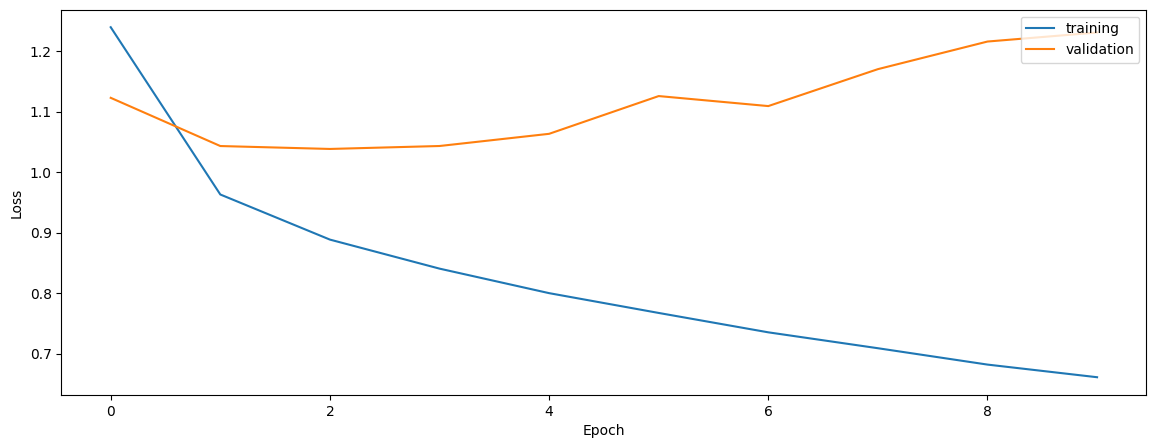

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6633857587428961
0.5866974958779885
0.534688528157925


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6337971641930171
0.6045353982300885
0.5151990130248362


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6304537911372334
0.6104942450914015
0.508840494669132


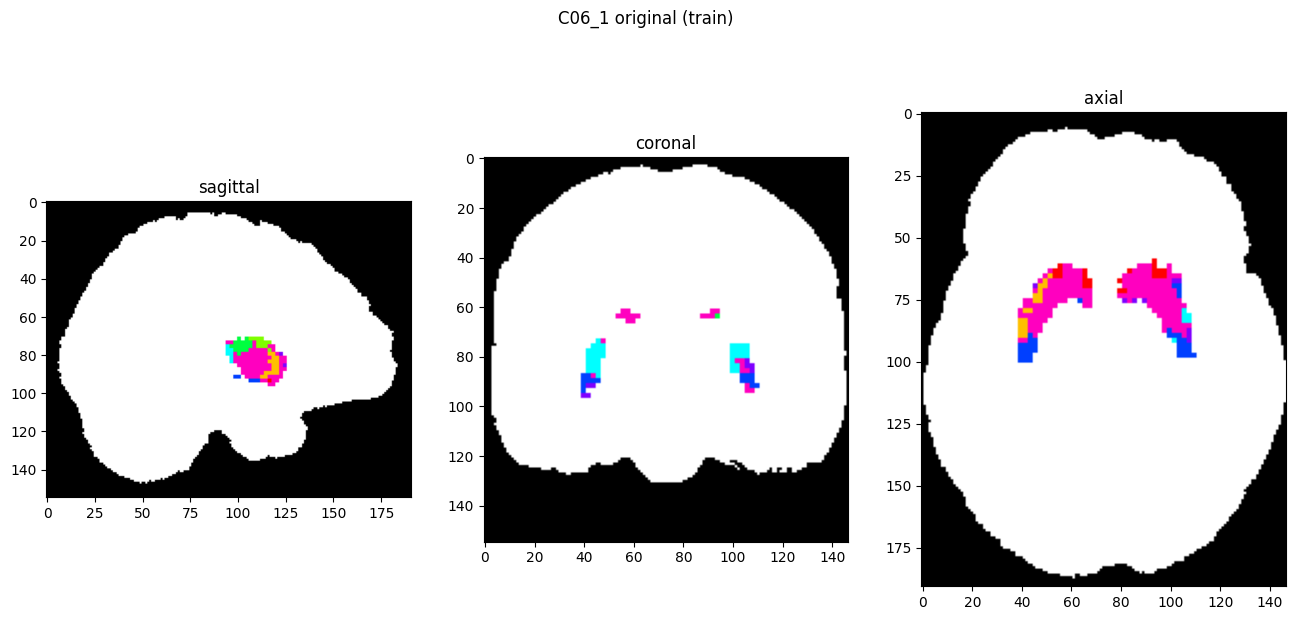

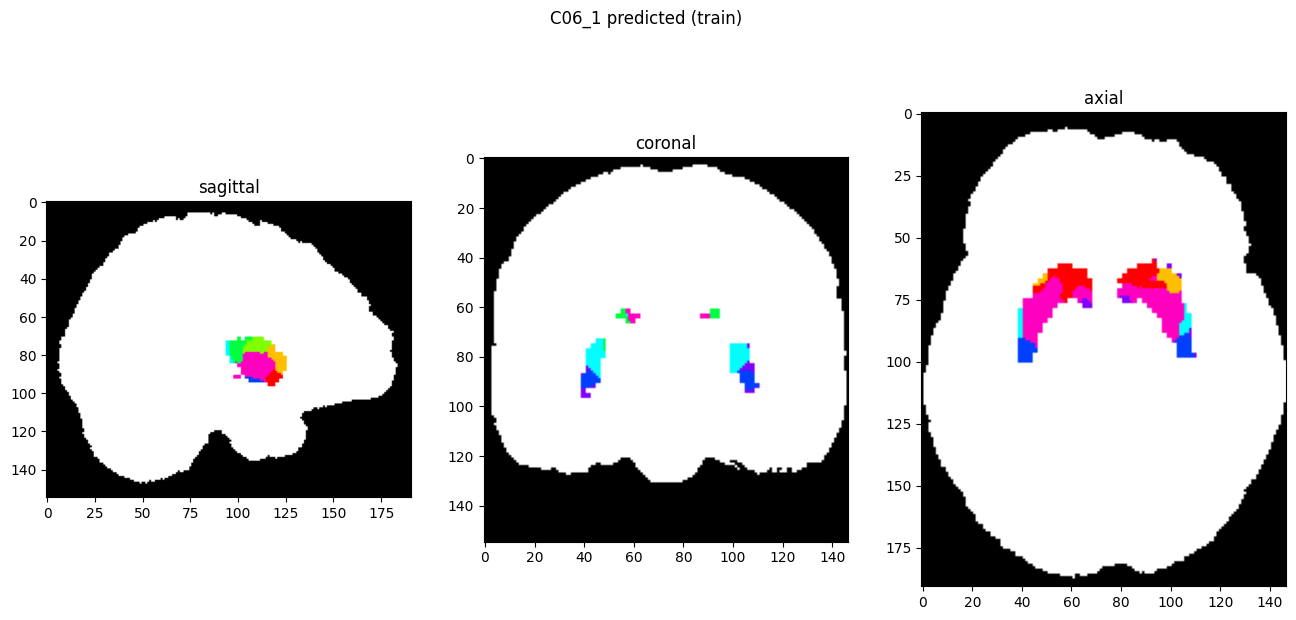

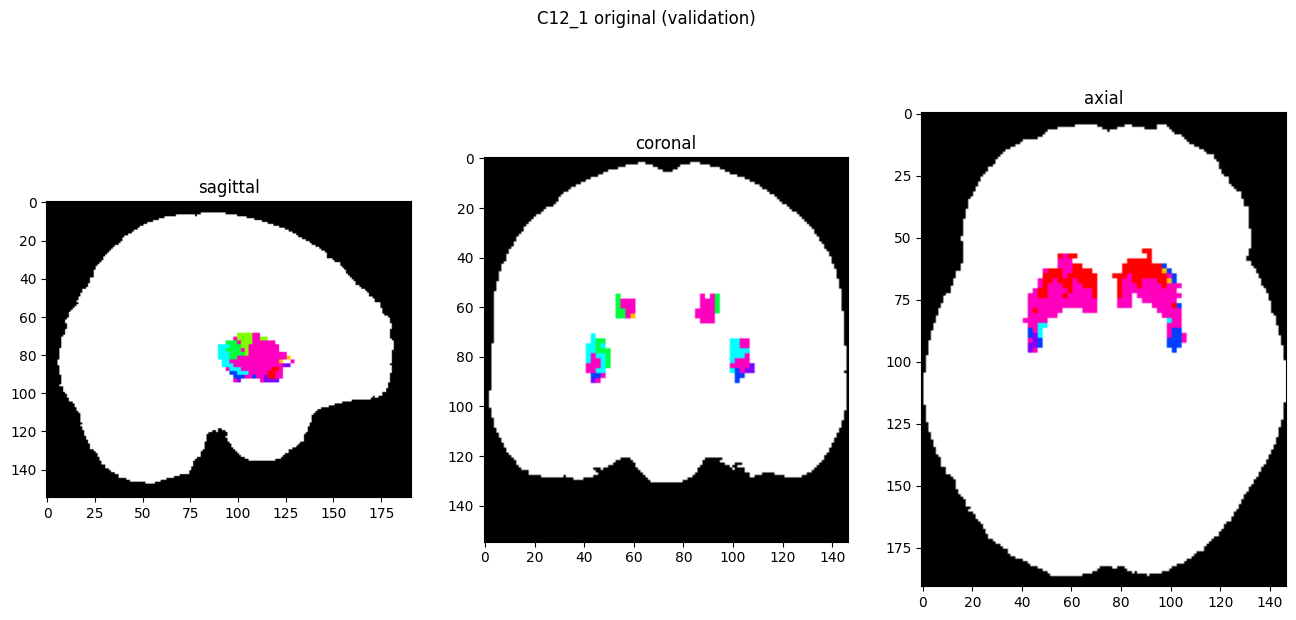

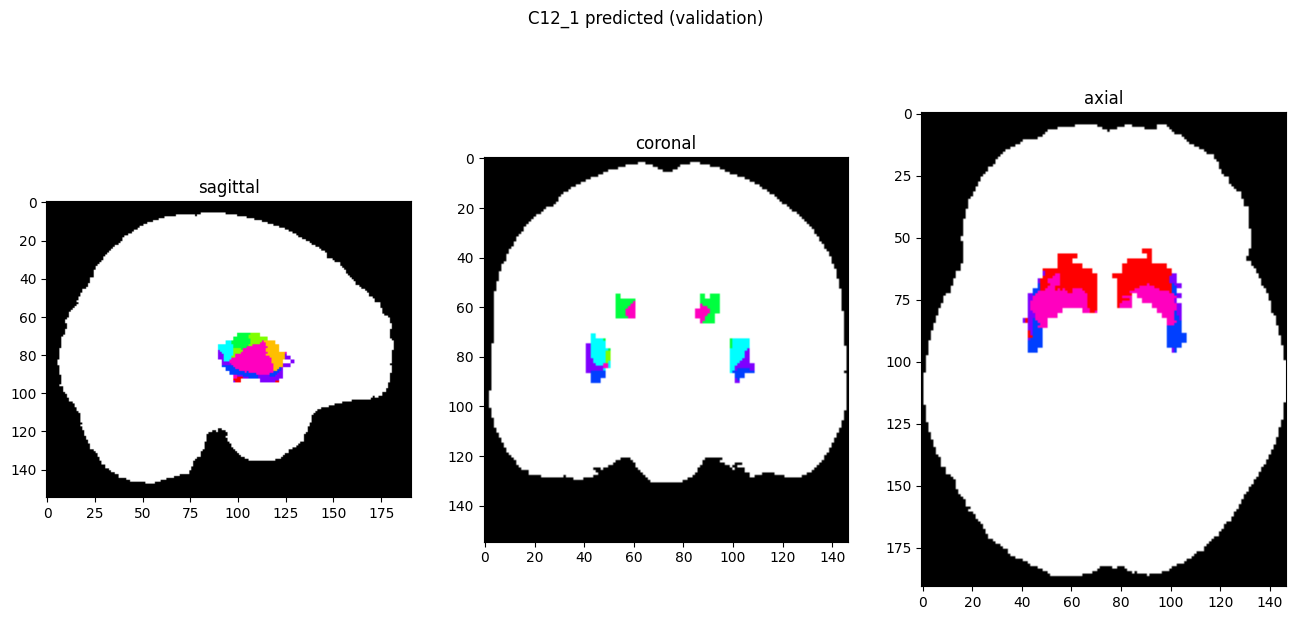

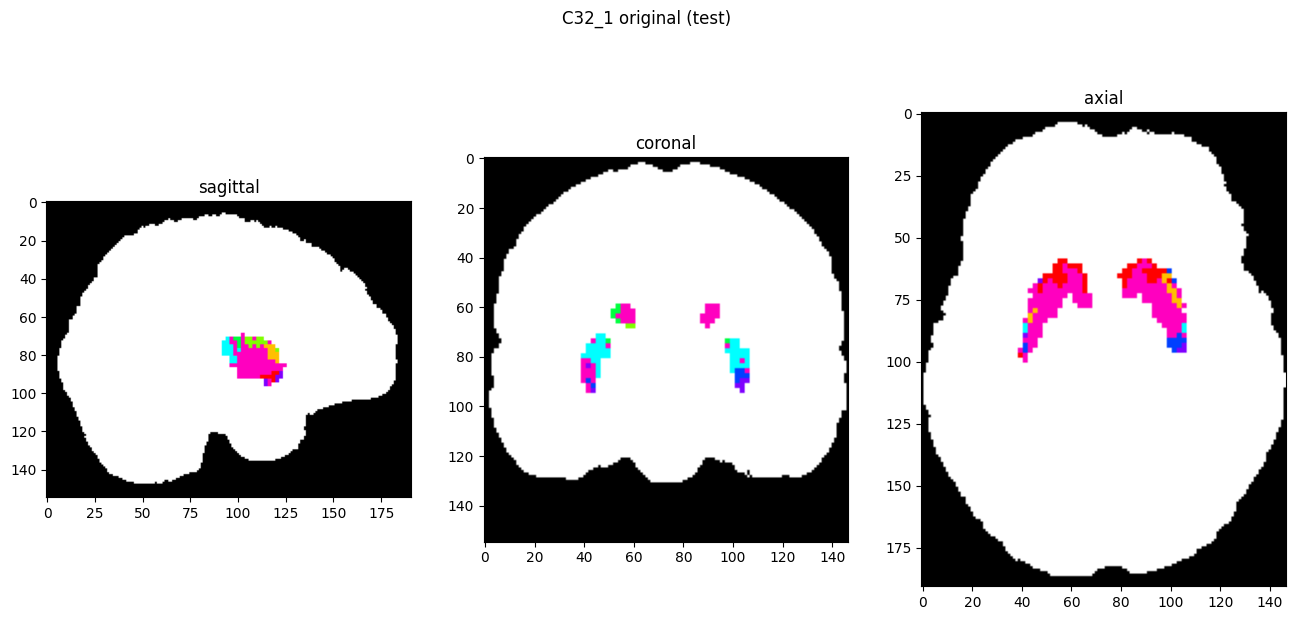

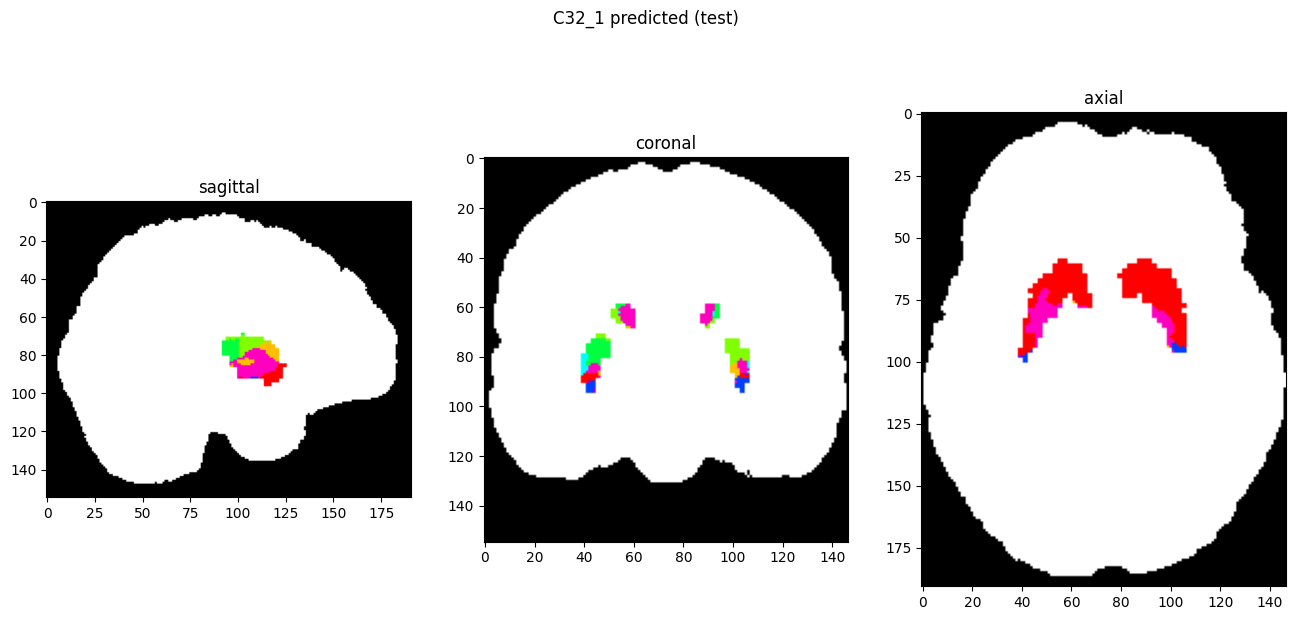

In [10]:
showResults(model, gen, threshold=0)